In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import ants

In [10]:
test_path = '/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-02-0086/'
os.listdir(test_path)

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']

In [99]:
img = ants.image_read(test_path + 'CT1_SEG.nii.gz')
img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 23)
	 Spacing    : (0.7812, 0.7812, 6.5)
	 Origin     : (-104.048, -85.0245, -55.8041)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [105]:
# Reorient fixed
img = ants.reorient_image2(img, orientation = 'RPI')
img

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 23)
	 Spacing    : (0.7812, 0.7812, 6.5)
	 Origin     : (-104.048, 114.1943, -55.8041)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [122]:
img_res = ants.resample_image(img, (1, 1, 1), False, 0)
img_res

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (200, 200, 150)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-104.048, 114.1943, -55.8041)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [123]:
img_res_reverse = ants.resample_image(img_res, img.spacing, False, 0)
img_res_reverse

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 23)
	 Spacing    : (0.7812, 0.7812, 6.5)
	 Origin     : (-104.048, 114.1943, -55.8041)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [117]:
np.allclose(img_res_reverse.numpy(), img.numpy())

False

In [118]:
#bspline
mae = np.sum(np.absolute(img_res_reverse.numpy() - img.numpy()))
mae, img_res_reverse.numpy().mean(),  img.numpy().mean()

(7622.27, 0.07419364, 0.07419022)

In [124]:
#linear
mae = np.sum(np.absolute(img_res_reverse.numpy() - img.numpy()))
mae, img_res_reverse.numpy().mean(),  img.numpy().mean()

(9900.097, 0.07431353, 0.07419022)

In [125]:
np.sum(img_res_reverse.numpy()), np.sum(img.numpy())

(112014.86, 111829.0)

In [92]:
#bspline
mae = np.sum(np.absolute(img_res_reverse.numpy() - img.numpy()))
mae, img_res_reverse.numpy().mean(),  img.numpy().mean()

(1987788.2, 172.29662, 172.29372)

In [42]:
#linear
mae = np.sum(np.absolute(img_res_reverse.numpy() - img_fixed.numpy()))
mae, img_res_reverse.numpy().mean(),  img_fixed.numpy().mean()

(228727150.0, 209.80838, 209.68625)

In [46]:
#nearest
mae = np.sum(np.absolute(img_res_reverse.numpy() - img_fixed.numpy()))
mae, img_res_reverse.numpy().mean(),  img_fixed.numpy().mean()

(17707284.0, 209.7501, 209.68625)

In [50]:
#gaussian
mae = np.sum(np.absolute(img_res_reverse.numpy() - img_fixed.numpy()))
mae, img_res_reverse.numpy().mean(),  img_fixed.numpy().mean()

(65220820.0, 209.75346, 209.68625)

In [53]:
#windowed sinc
mae = np.sum(np.absolute(img_res_reverse.numpy() - img_fixed.numpy()))
mae, img_res_reverse.numpy().mean(),  img_fixed.numpy().mean()

(7953960.0, 211.56853, 209.68625)

In [56]:
#bspline
mae = np.sum(np.absolute(img_res_reverse.numpy() - img_fixed.numpy()))
mae, img_res_reverse.numpy().mean(),  img_fixed.numpy().mean()

(6945182.0, 209.69185, 209.68625)

### Resampling to image with transform

In [60]:
def rigid_reg(fixed, moving):
    """Rigidly register `moving` image onto `fixed` image and apply resulting transformation on `mask`.
    Returns mask in `fixed` resolution."""
    
    if type(fixed) is str:
        # Read images if input is pathlike
        fixed = ants.image_read(fixed)
        moving = ants.image_read(moving)
    
    # Compute registration if input is ants.image
    res = ants.registration(fixed=fixed, moving=moving,
                            type_of_transform='Rigid')
    
    new_img = ants.apply_transforms(fixed, moving,
                                    transformlist = res['fwdtransforms'][0])
    forward_trans = res['fwdtransforms'][0]
    
    inv_trans = res['invtransforms'][0]
    
    return new_img, forward_trans, inv_trans

In [93]:
img_res = ants.resample_image(img, (1, 1, 1), False, 0)
# transformation
resample = ants.registration(fixed=img_res, moving=img,
                                type_of_transform='Rigid')
# apply transform
img_res = ants.apply_transforms(img_res, img,
                                transformlist = resample['fwdtransforms'][0])
#
img_res_reverse = ants.apply_transforms(img, img_res,
                                        transformlist = resample['invtransforms'][0])

In [95]:
np.allclose(img_res_reverse.numpy(), img.numpy())

False

In [98]:
#rigid
mae = np.sum(np.absolute(img_res_reverse.numpy() - img.numpy()))
mae, img_res_reverse.numpy().mean(),  img.numpy().mean()

(9012015.0, 172.40034, 172.29372)

In [79]:
#Translation
mae = np.sum(np.absolute(img_res_reverse.numpy() - img_fixed.numpy()))
mae, img_res_reverse.numpy().mean(),  img_fixed.numpy().mean()

(18342246.0, 210.02597, 209.68625)

In [82]:
#dence rigid
mae = np.sum(np.absolute(img_res_reverse.numpy() - img_fixed.numpy()))
mae, img_res_reverse.numpy().mean(),  img_fixed.numpy().mean()

(18703406.0, 210.1516, 209.68625)

### Calculating DICE

In [132]:
%run ../main_pipeline/stats/metrics.py

FileNotFoundError: [Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/gbm/inference/gbm_3a_atlas_spacing'

In [196]:
def plot_qc(image, mask, patient_id= 'lol'):
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    idx = np.argsort(mask.sum(axis=(0,1)))[-3:]
    for i in range(3):
        axs[i, 0].imshow(image[..., idx[i]], cmap='gray')
        axs[i, 1].imshow(mask[..., idx[i]], cmap='gray')
        axs[i, 2].imshow(image[..., idx[i]]+200*mask[..., idx[i]], cmap='gray')
    axs[0,0].set_title(patient_id)
    plt.tight_layout()
    plt.plot()

TCGA-02-0086


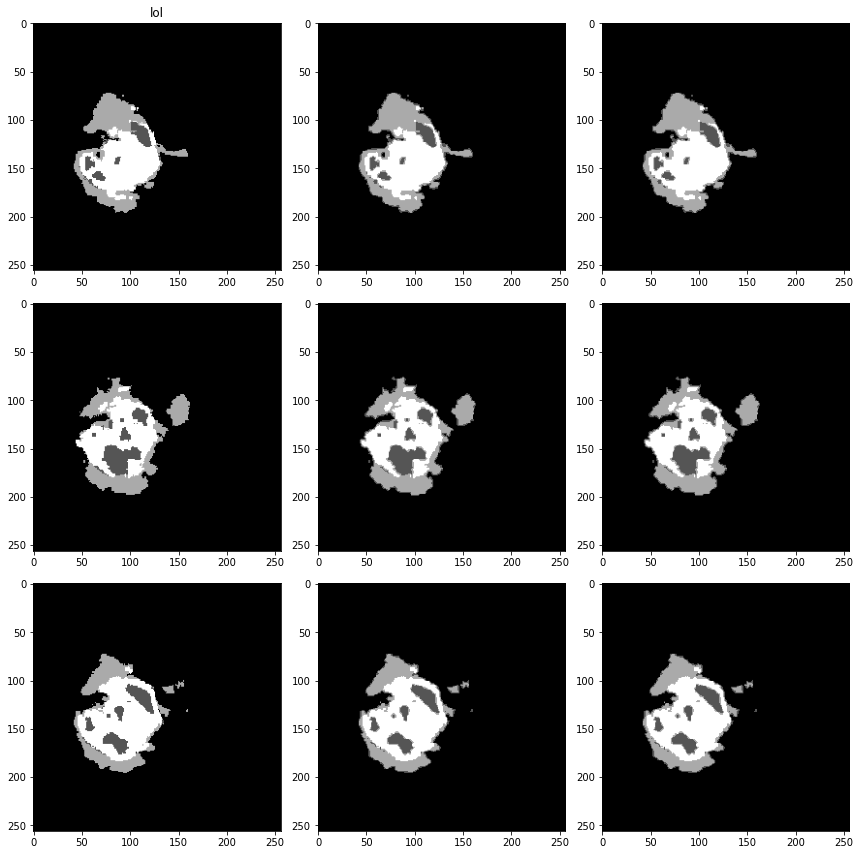

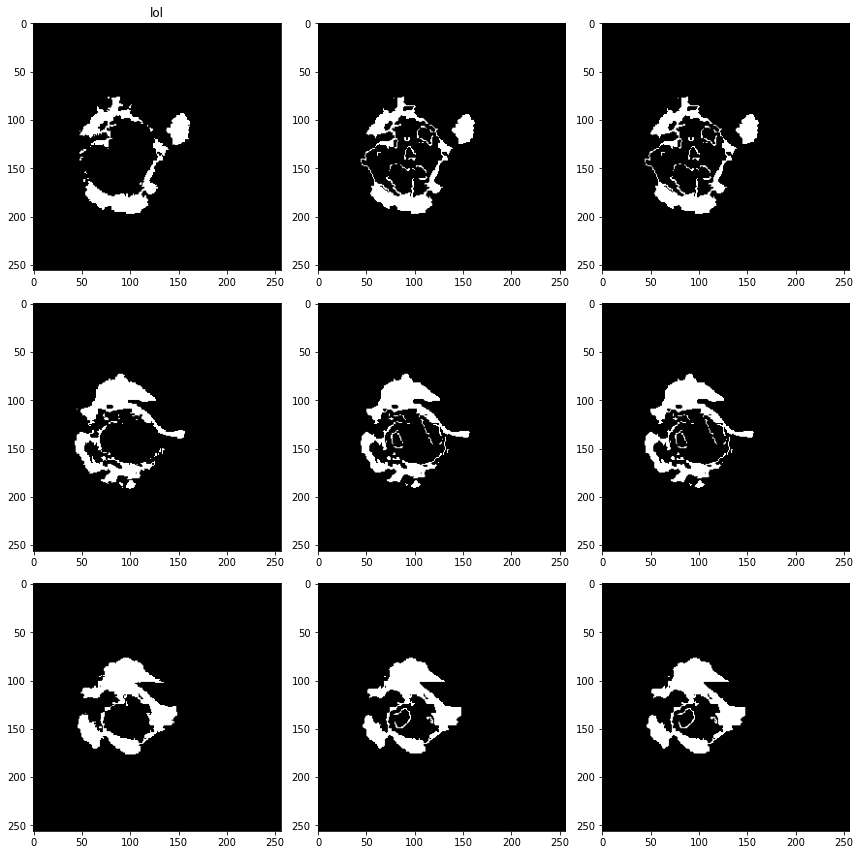

Dice  0.5191914231933874 S Dice 0.301309794964368
TCGA-02-0102


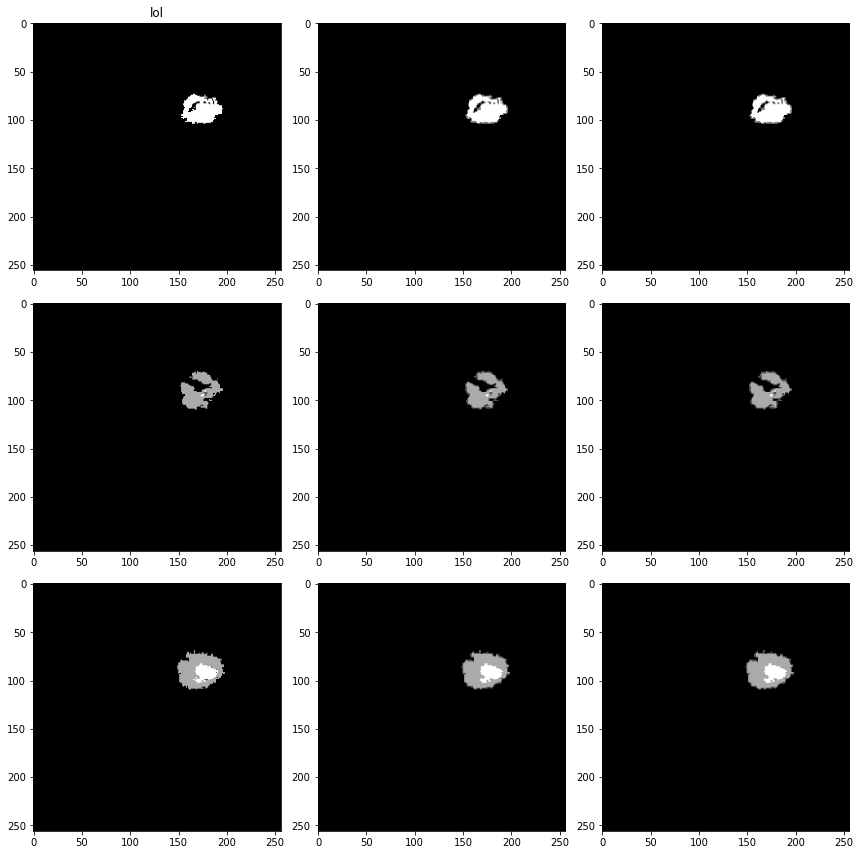

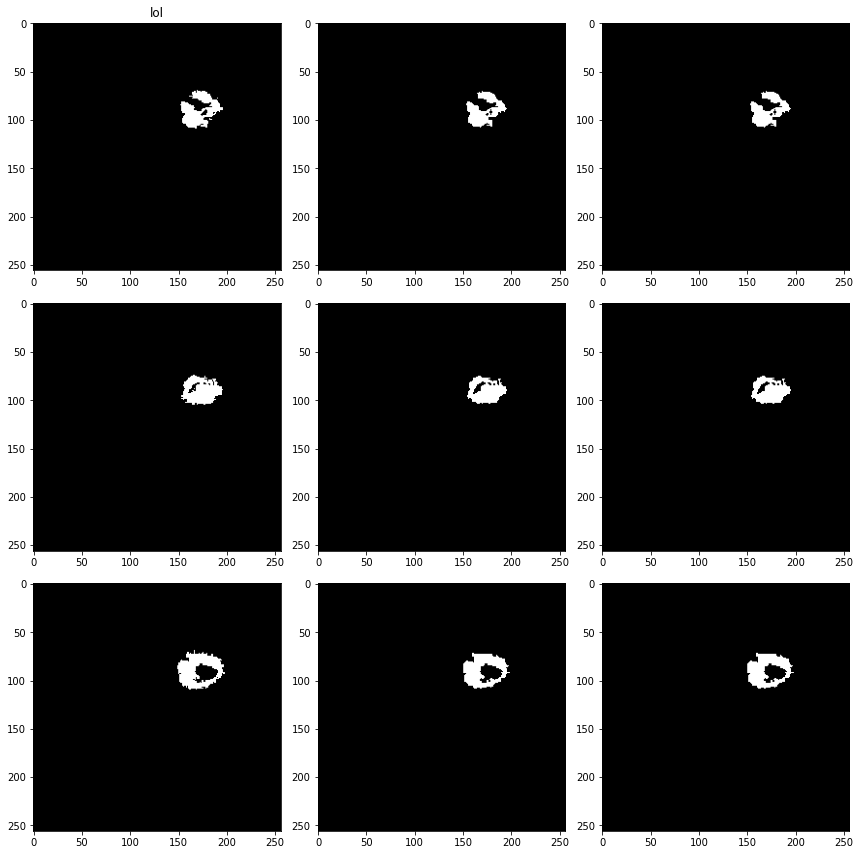

Dice  0.020512820512820513 S Dice 0.05975620788329506
TCGA-02-0059


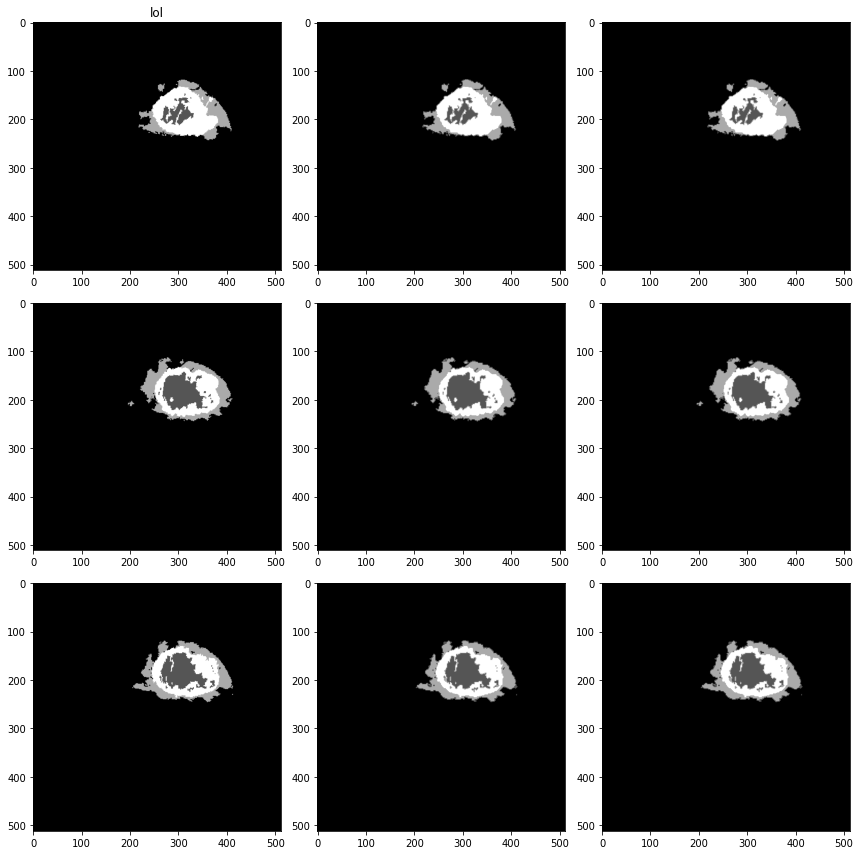

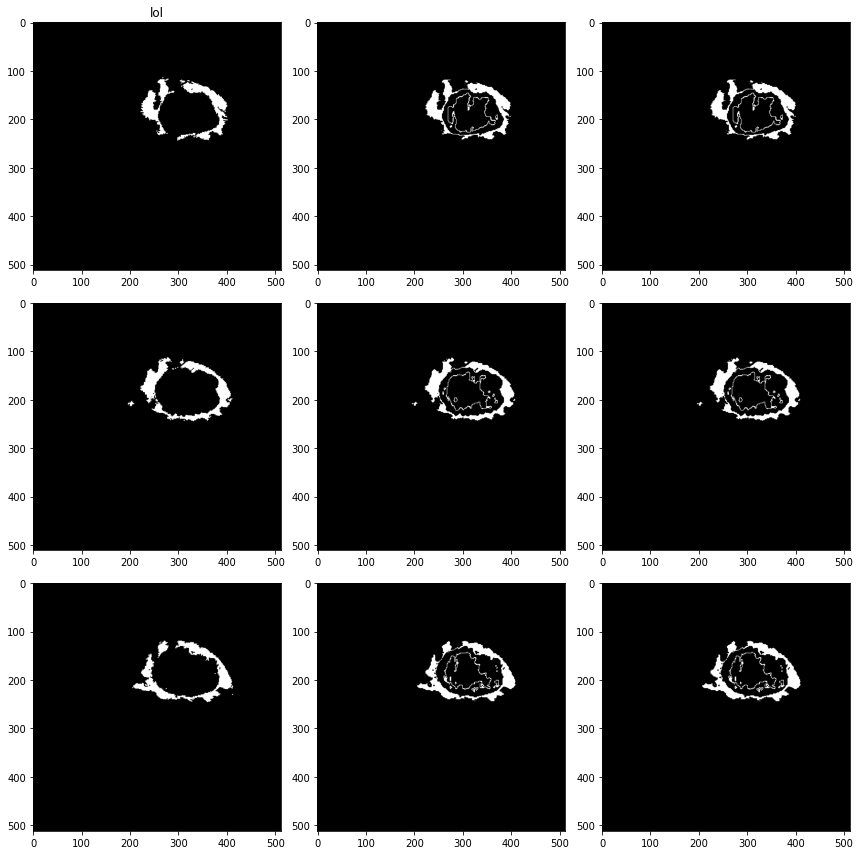

Dice  0.7125198227137803 S Dice 0.3386129078508565
TCGA-02-0069


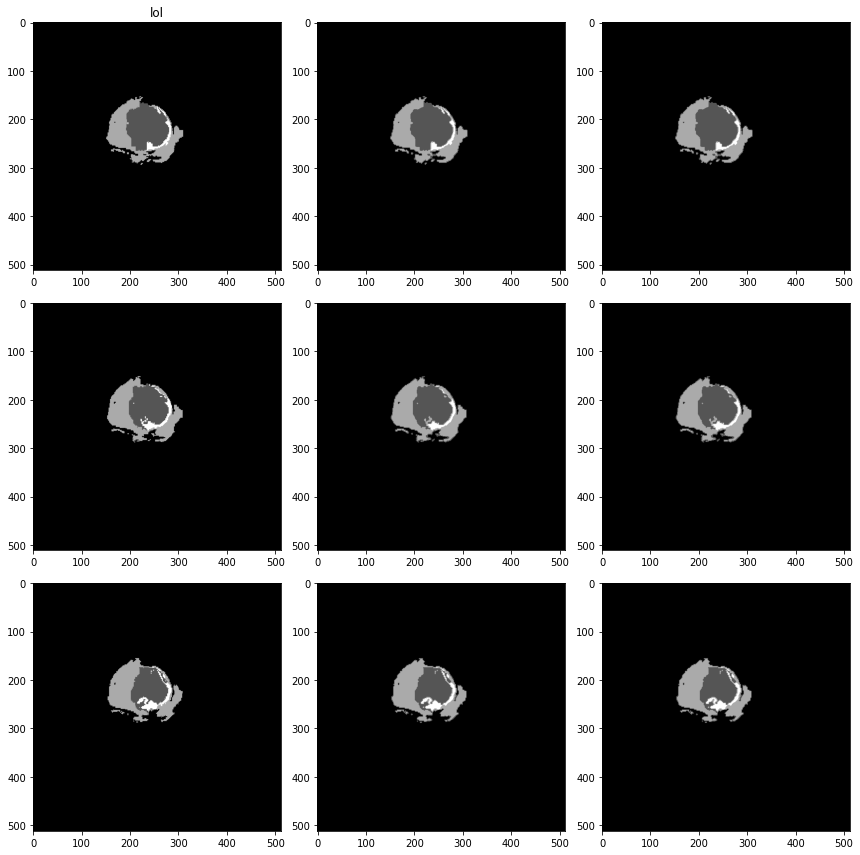

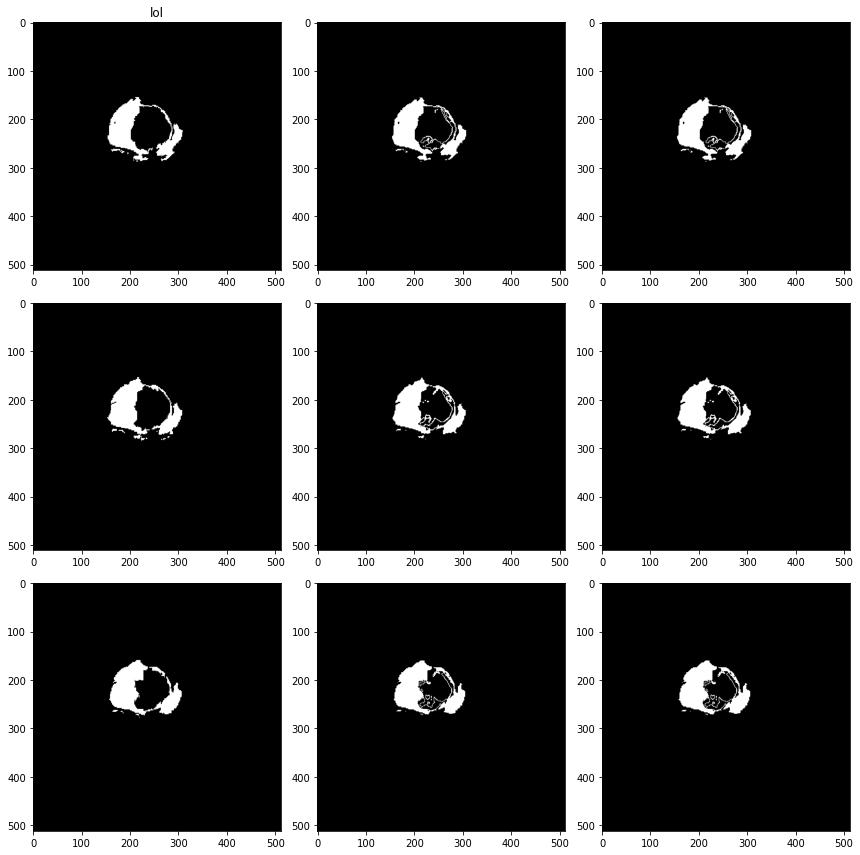

Dice  0.8290842526249652 S Dice 0.44833820051860285
TCGA-19-2624


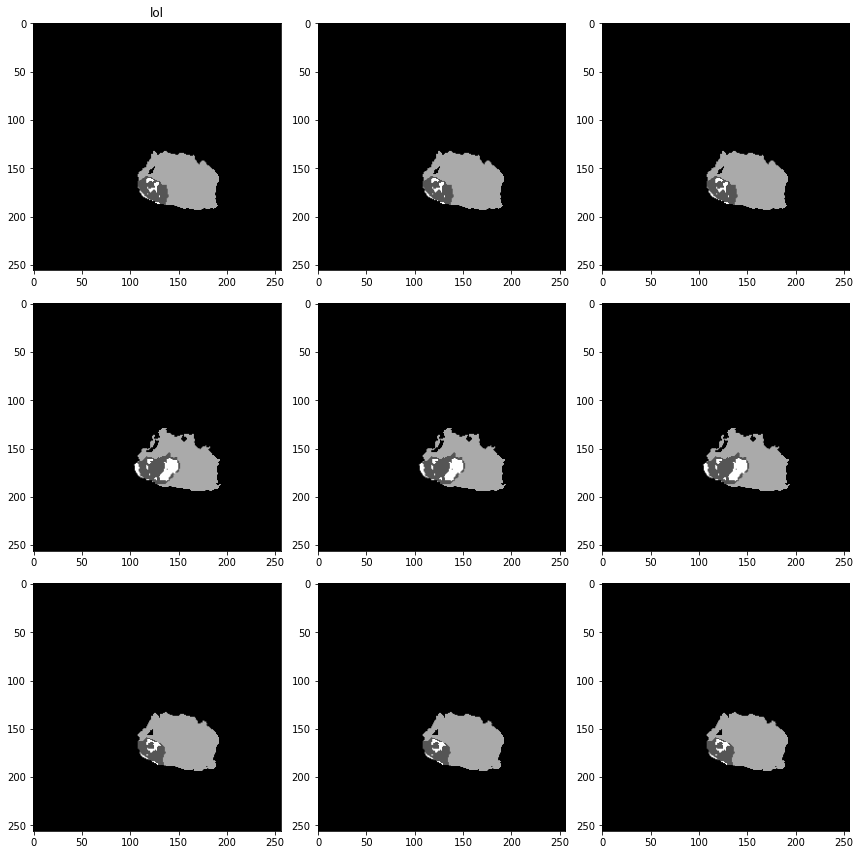

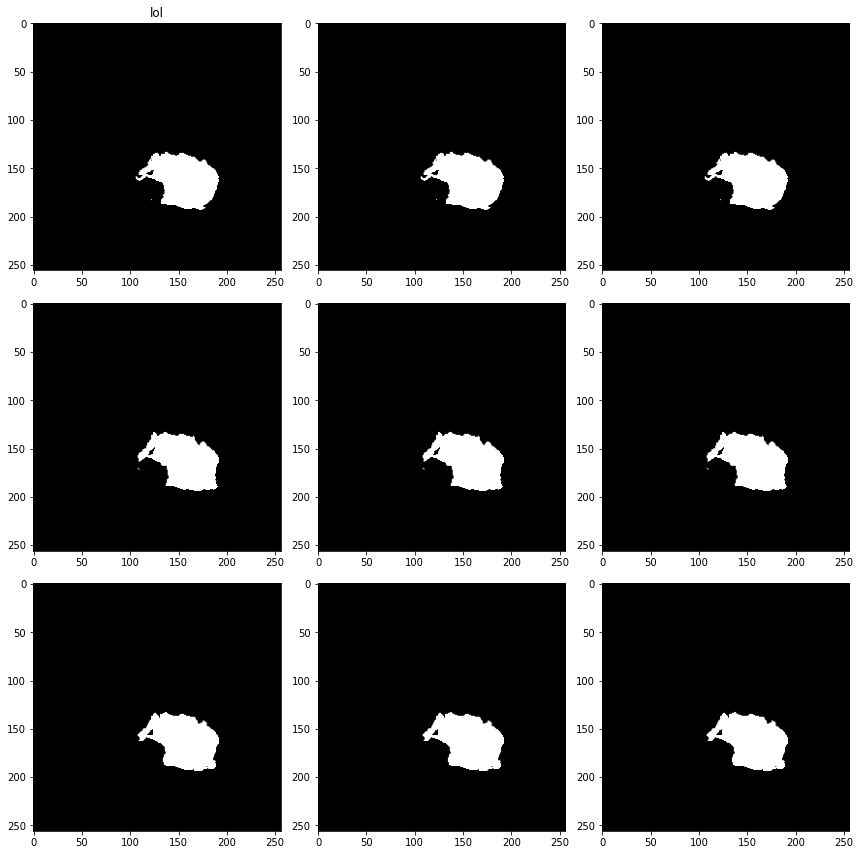

Dice  1.0 S Dice 1.0
TCGA-06-0182


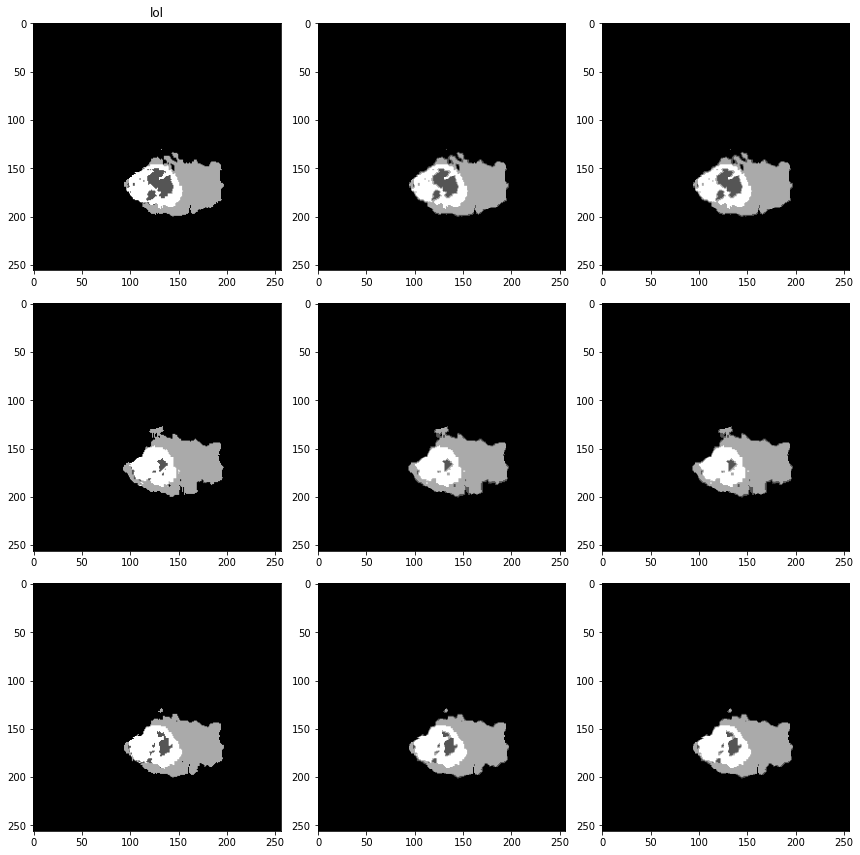

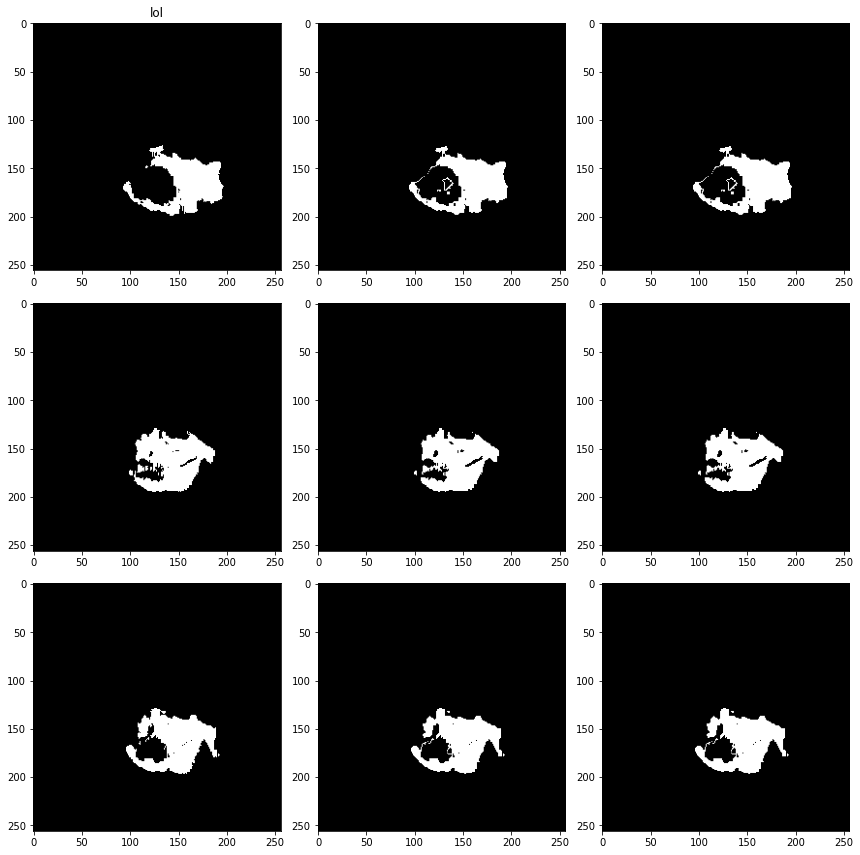

Dice  0.3650756693830035 S Dice 0.22601233687426606
TCGA-08-0360


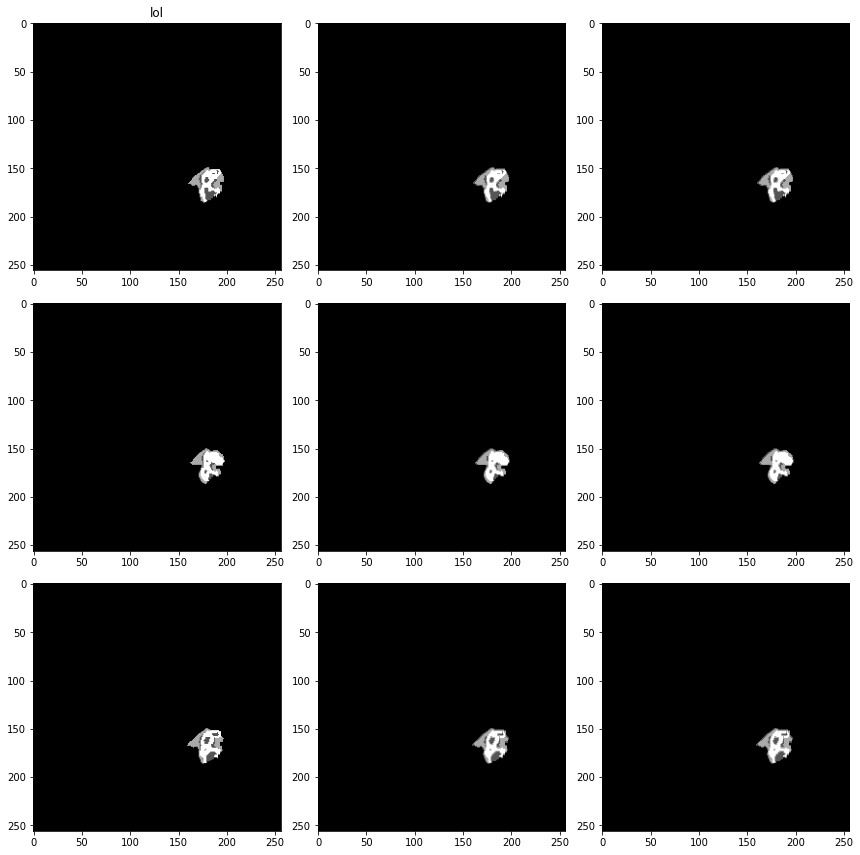

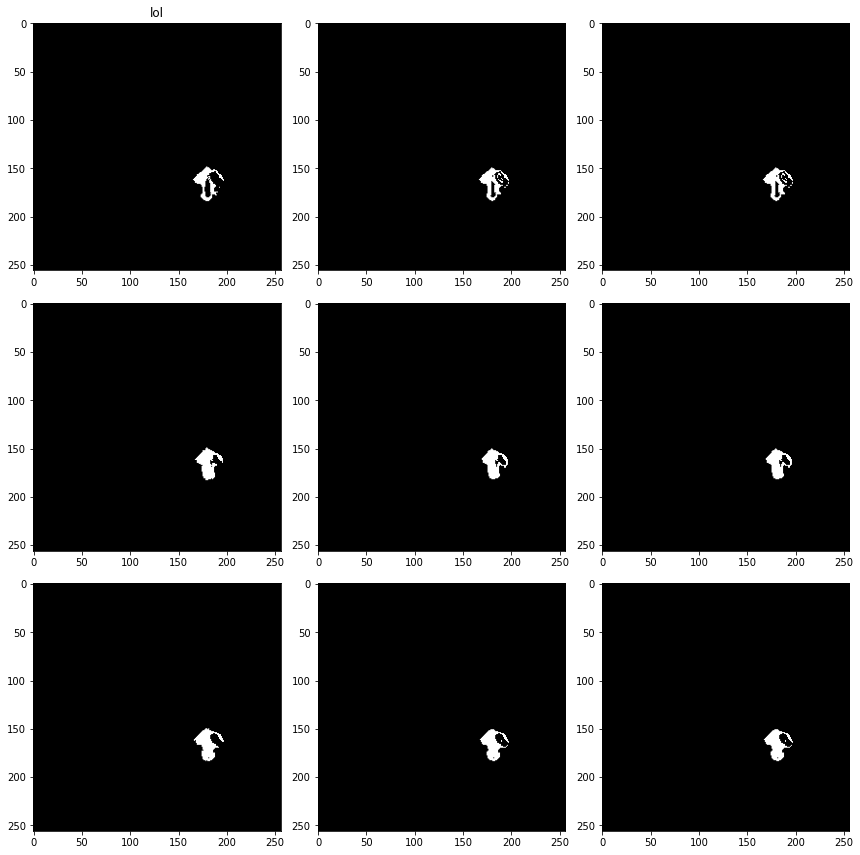

Dice  0.454337899543379 S Dice 0.4977153379039002
TCGA-02-0006


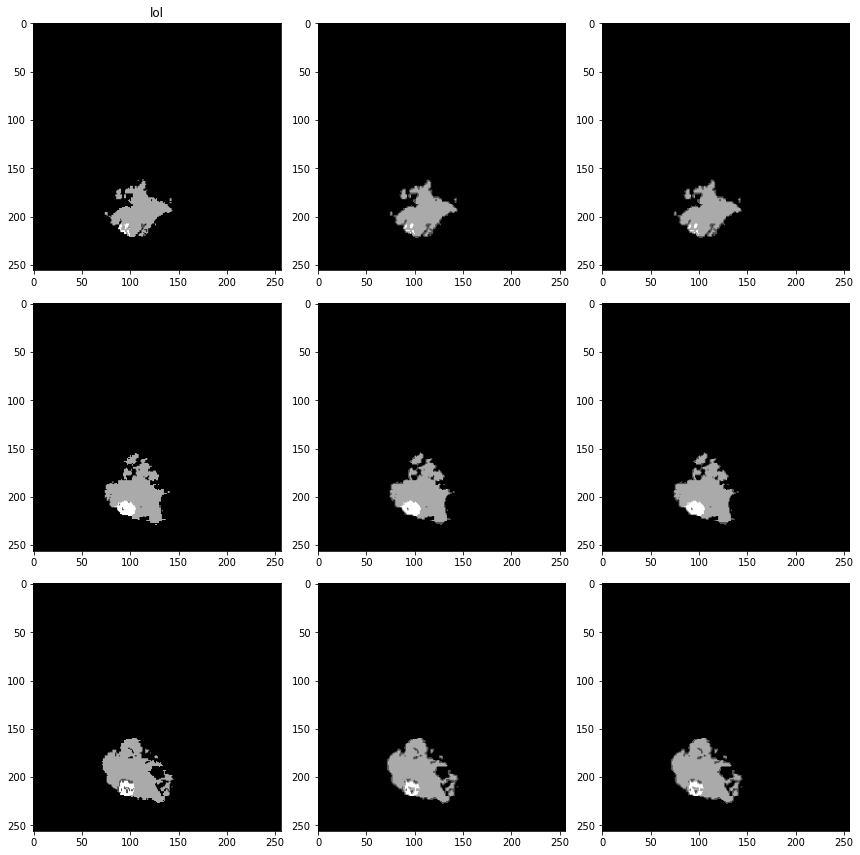

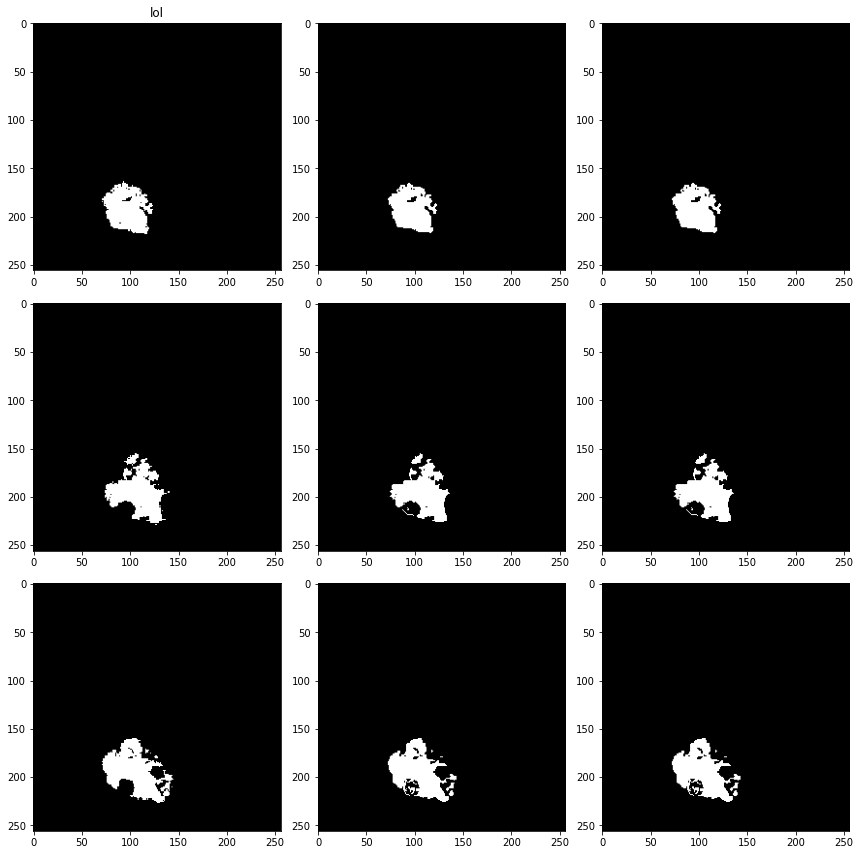

Dice  0.03617115130127922 S Dice 0.0663531755259267
TCGA-19-2631


ValueError: operands could not be broadcast together with shapes (192,256,28) (193,256,28) 

In [195]:
# With resample
path = '/anvar/public_datasets/preproc_study/gbm/1_reg'

dices = []
s_dices = []
for image in os.listdir(path_to_1_reg):
    print(image)
    img = ants.image_read(path + '/' + image +'/' + 'CT1_SEG.nii.gz')
    # resample
    img_res = ants.resample_image(img, (1, 1, 1), False, 0)
    # apply inverse transform
    img_res_reverse = ants.resample_image(img_res, img.spacing, False, 0)
    # round inverse labels
    pred = np.round(img_res_reverse.numpy(), 0)
    # calculate metrics
    distances = metrics.compute_surface_distances((img[:,:,:]==1), (pred[:,:,:]==1), spacing)
    dice = metrics.compute_dice_coefficient((img[:,:,:]==1), (pred[:,:,:]==1))
    s_dice = metrics.compute_surface_dice_at_tolerance(distances, 1)
    
    dices.append(dice)
    s_dices.append(s_dice)
    plot_qc(img[:,:,:], pred[:,:,:])
    plot_qc(img[:,:,:]==2, pred[:,:,:]==2)
    plt.show()
    print('Dice ',dice, 'S Dice', s_dice)
    try:
        if np.allclose(img_mask.numpy(),  img_res_reverse.numpy()):
            print('For ', image, mod,  'images are the same')
    except Exception as e:
        pass

#### Repeating the experiment with interpolating chanel by chanel

In [523]:
def resample_by_channels(img, channels = [1,2,3], interpolator = 0):
    # empty array
    img_res = ants.resample_image(img, (1, 1, 1), False, interpolator)
    result_arr = np.zeros_like(img_res.numpy())

    for channel in channels:
        # float is needed by ants to save an image
        temp_img = img.new_image_like((img[:,:,:] == int(channel))*float(channel))
        temp_img_res = ants.resample_image(temp_img, (1, 1, 1), False, interpolator)
        temp_arr = np.round(temp_img_res.numpy(), 0)
        result_arr += (temp_arr[:,:,:] == int(channel))*float(channel)
    img_res =  img_res.new_image_like(result_arr)
    return img_res

def invert_resample_by_channels(img_res,
                                    img_orig,
                                    channels = [1,2,3], 
                                    interpolator = 0):
        img_res_inv = ants.resample_image(img_res, img_orig.spacing, False, interpolator)
        result_arr = np.zeros_like(img_res_inv.numpy())

        for channel in channels:
        # for each label in labels separately
            temp_img = img_res.new_image_like((img_res[:,:,:] == int(channel))*float(channel))
            temp_img_res = ants.resample_image(temp_img, img_orig.spacing, False, interpolator)
            temp_arr = np.round(temp_img_res.numpy(), 0)
            result_arr += (temp_arr[:,:,:] == int(channel))*float(channel)

        img_res_reverse = img_res_inv.new_image_like(result_arr)
        return img_res_reverse

def invert_registrate_by_channels(img_res, img_orig, channels = [1,2,3], interpolator = 'Rigid'):
    result_arr = np.zeros_like(img_orig.numpy())
    
    registration = ants.registration(fixed = img_orig, moving = img_res, type_of_transform = interpolator)   
    for channel in channels:
    # for each label in labels separately
        temp_img = img_res.new_image_like((img_res[:,:,:] == int(channel))*float(channel))
        temp_img_res = ants.apply_transforms(img_orig, temp_img, transformlist = registration['fwdtransforms'][0])
#         print(temp_img_res.shape)
        temp_arr = np.round(temp_img_res.numpy(), 0)
        result_arr += (temp_arr[:,:,:] == int(channel))*float(channel)
        
    img_res_reverse = img_orig.new_image_like(result_arr)
    return img_res_reverse

def resample_to_spacing_by_channels(img_res, img_orig, channels = [1,2,3], interpolator = 0):
    result_arr = np.zeros_like(img_orig.numpy())

    for channel in channels:
    # for each label in labels separately
        temp_img = img_res.new_image_like((img_res[:,:,:] == int(channel))*float(channel))
        temp_img_res = ants.resample_image(temp_img, img_orig.shape, True, interpolator)
        temp_arr = np.round(temp_img_res.numpy(), 0)
        result_arr += (temp_arr[:,:,:] == int(channel))*float(channel)
        
    img_res_reverse = img_orig.new_image_like(result_arr)
    return img_res_reverse


spaces = img.spacing
interpolator = 0
channels = [1,2,3]

channel = 3

path = '/anvar/public_datasets/preproc_study/gbm/orig'
img = ants.image_read(path + '/TCGA-02-0059/' + 'CT1_SEG.nii.gz')


img_res = resample_by_channels(img)
img_res_reverse = invert_resample_by_channels(img_res, img)

print(np.allclose(img[:,:,:]==channel, img_res_reverse[:,:,:]==channel))
print('DICE', metrics.compute_dice_coefficient((img[:,:,:] == channel), 
                                 (img_res_reverse[:,:,:] == channel)))

False
DICE 0.9033733562035449


#### GBM

TCGA-06-2570


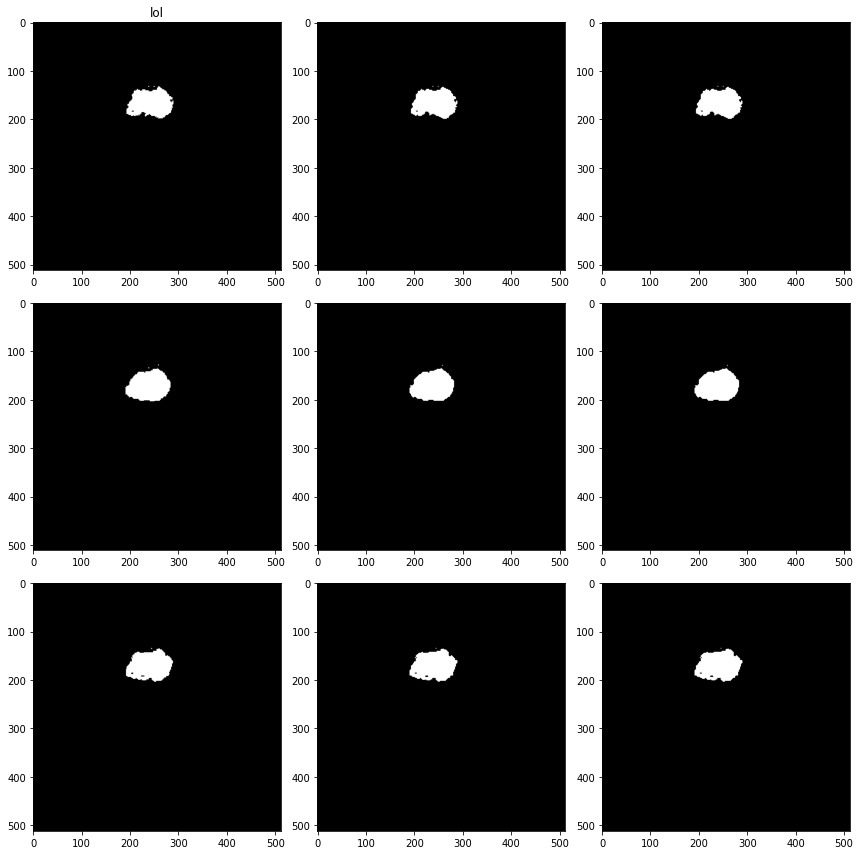

Dice  0.9703653869484179 S _Dice 0.9966513202530913
TCGA-06-0119


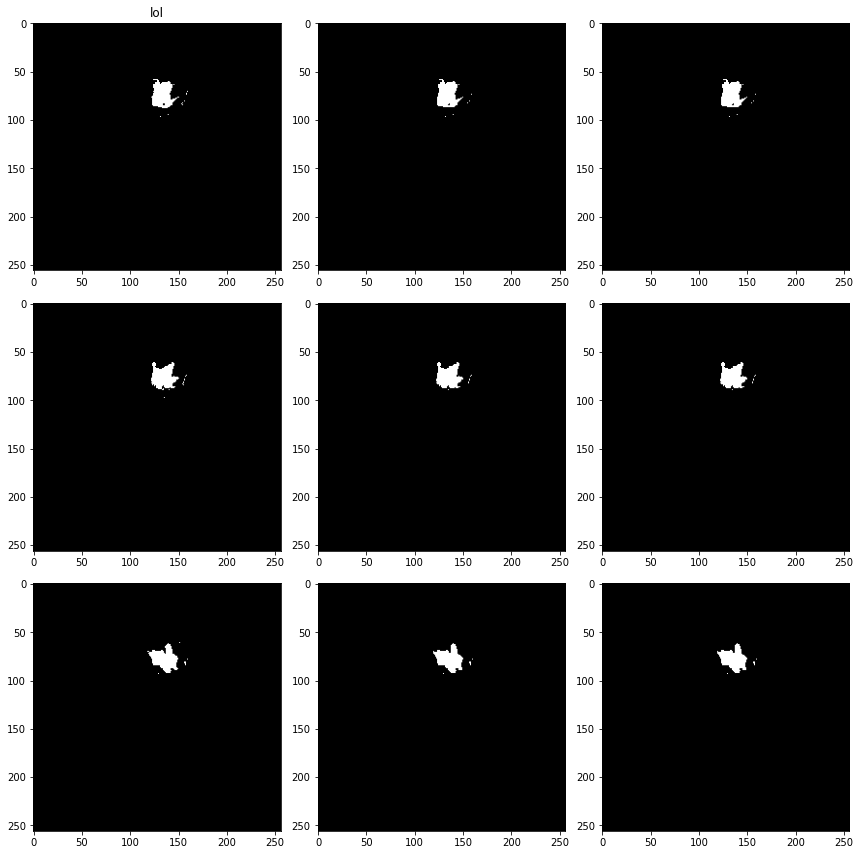

Dice  0.982489480114022 S _Dice 0.992136249553013
TCGA-06-0145


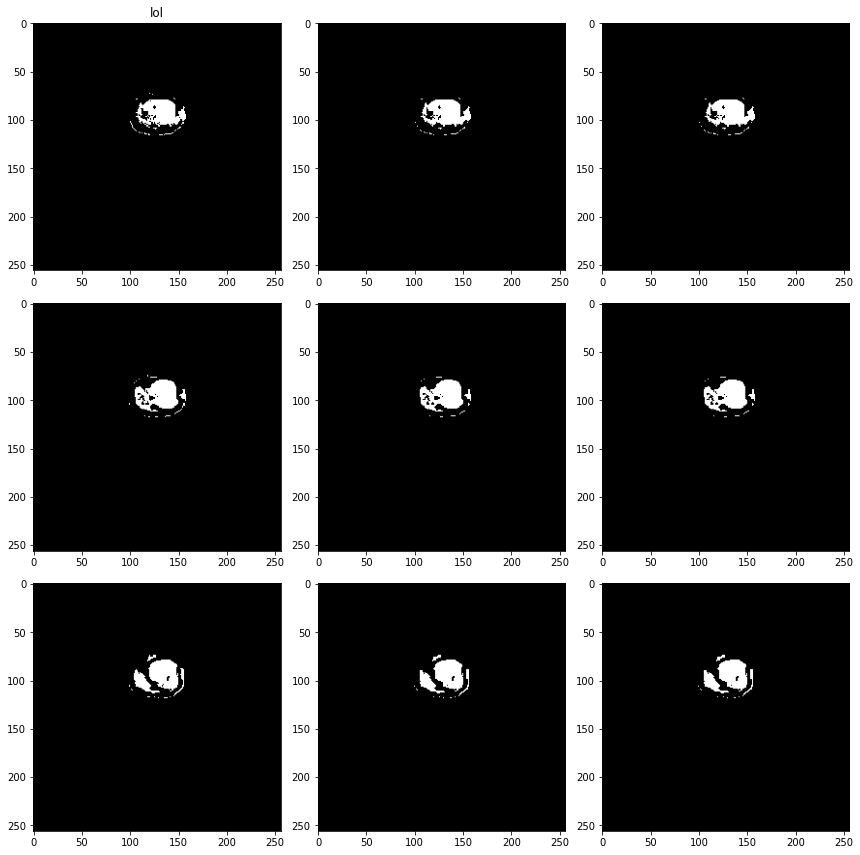

Dice  0.9753205128205128 S _Dice 0.988539219359304
TCGA-08-0509


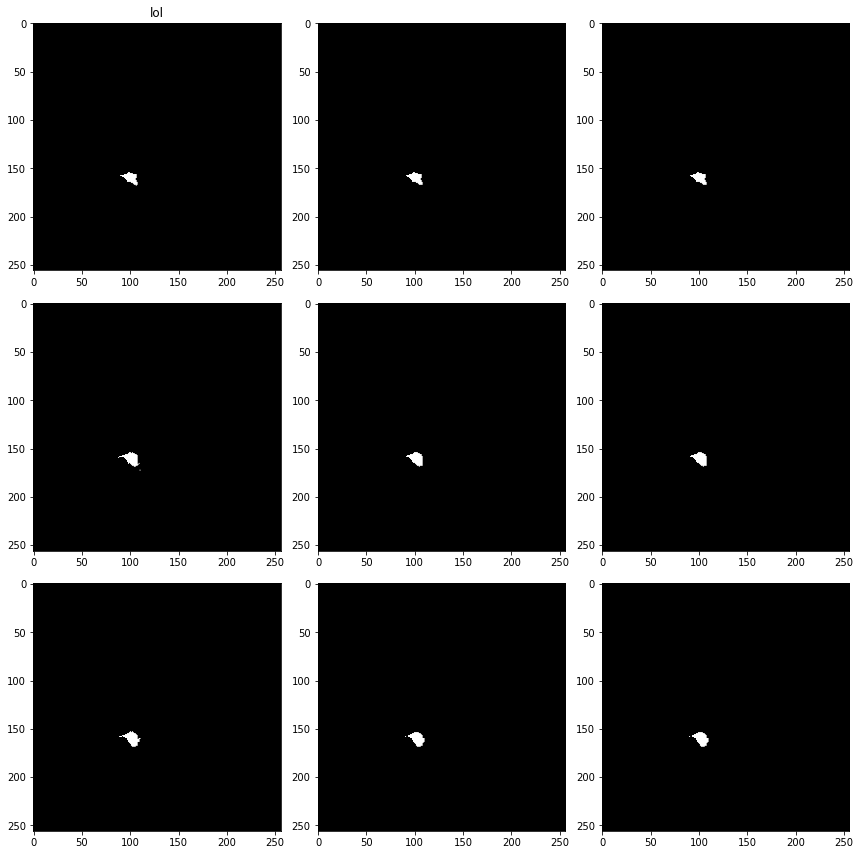

Dice  0.9190772610765288 S _Dice 0.882039539013766
TCGA-06-5408


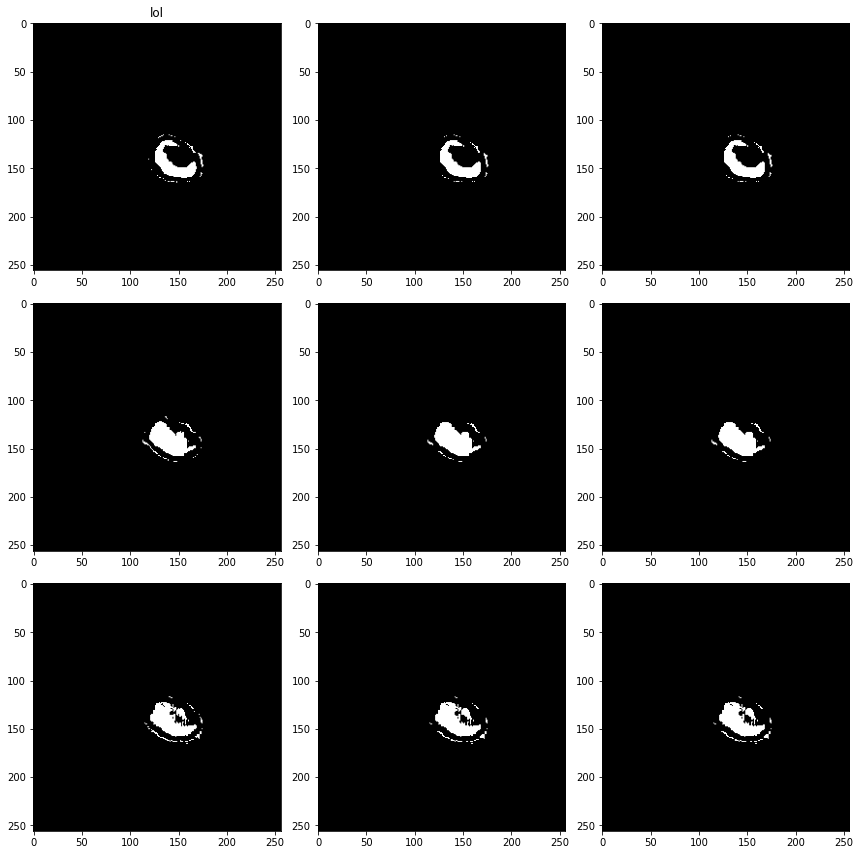

Dice  0.9748867846850556 S _Dice 0.9812431455905101
TCGA-02-0116


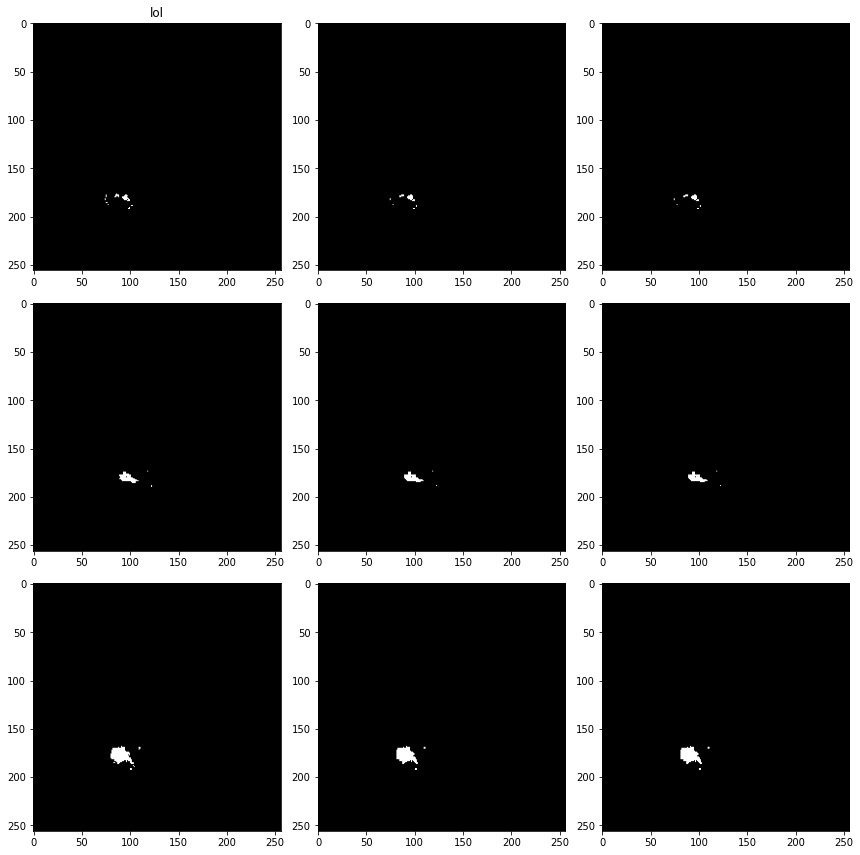

Dice  0.9410456062291435 S _Dice 0.9726828907843543
TCGA-06-0188


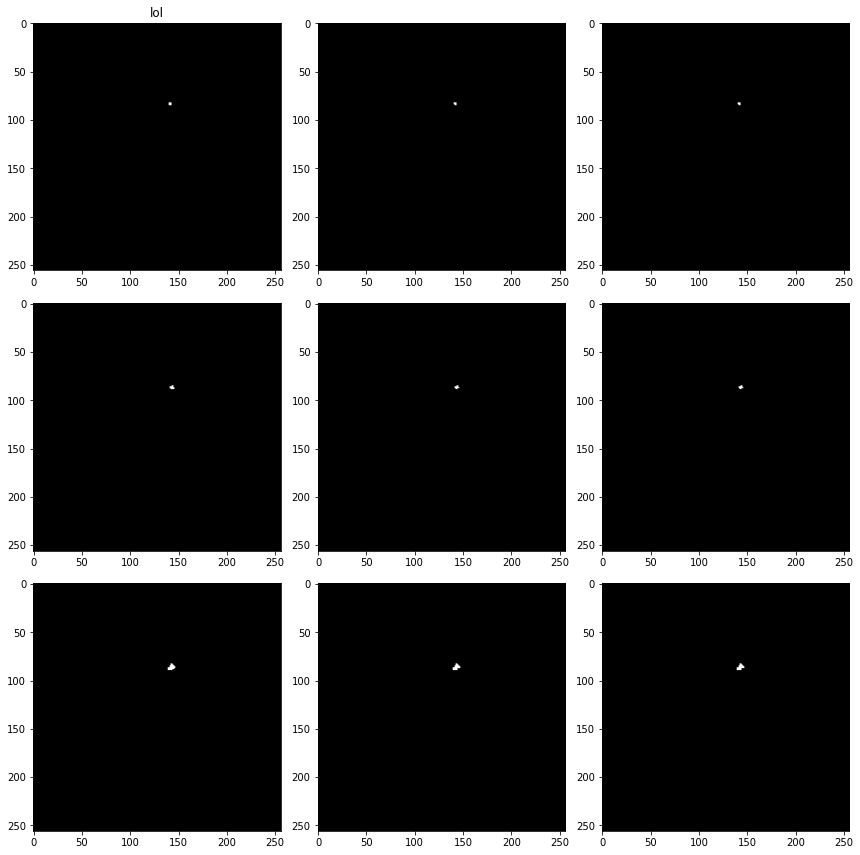

Dice  0.9565217391304348 S _Dice 1.0
TCGA-76-6661


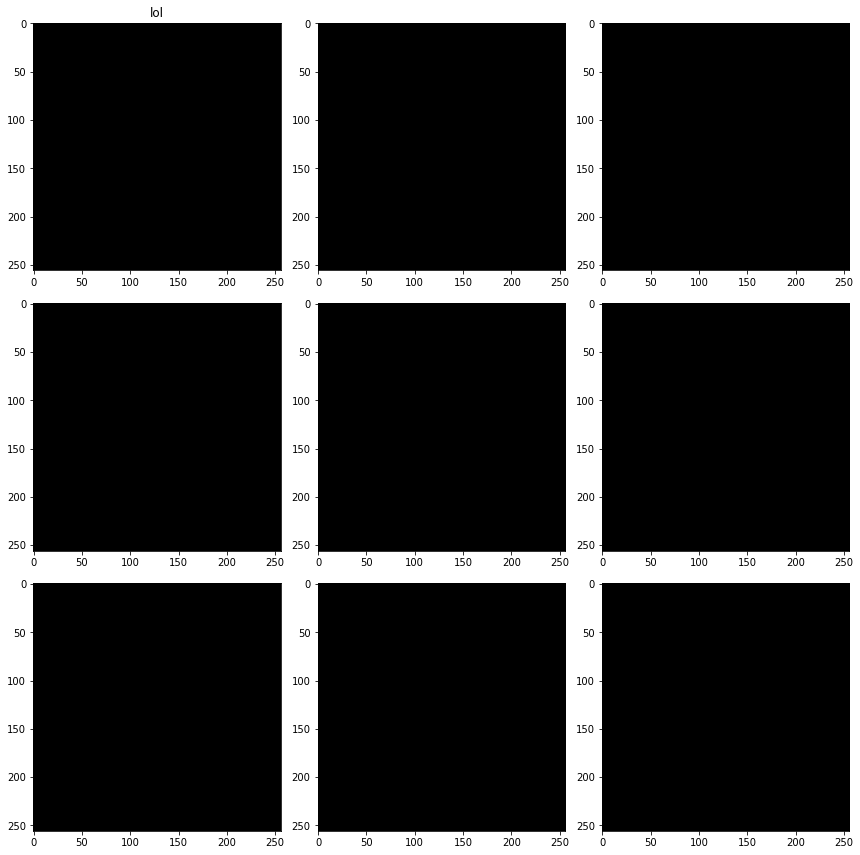

Dice  nan S _Dice nan
TCGA-02-0047


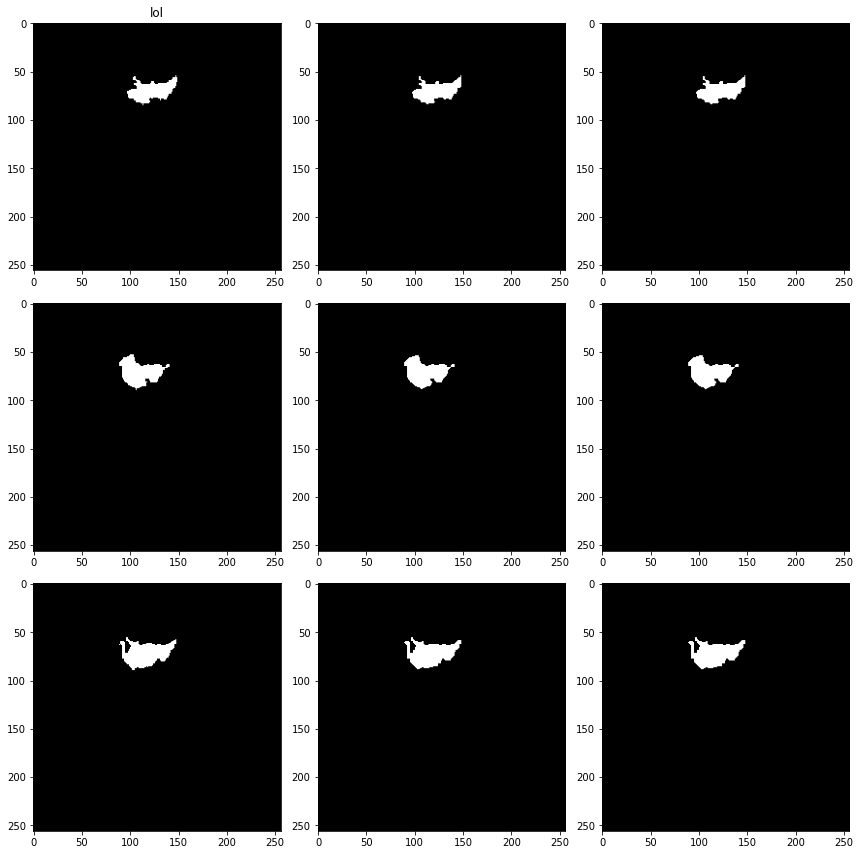

Dice  0.9828157023490461 S _Dice 0.999905878581411
TCGA-12-3650


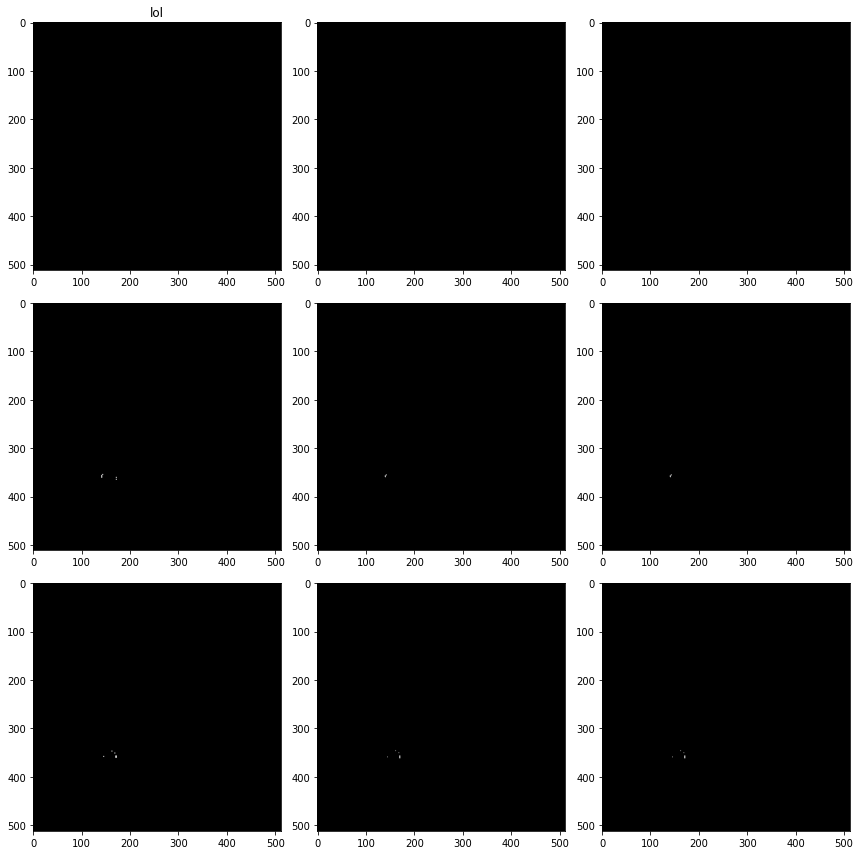

Dice  0.5 S _Dice 0.9176882170114767


In [403]:
path = '/anvar/public_datasets/preproc_study/gbm/orig'

dices = []
s_dices = []
for image in os.listdir(path_to_1_reg)[10:20]:
    print(image)
    img = ants.image_read(path + '/' + image +'/' + 'CT1_SEG.nii.gz')
    # resample and inverse 
    channels = np.unique(img.numpy())[1:]
    img_res = resample_by_channels(img, channels = channels, interpolator = 0)
    
    try:
        img_res_reverse = invert_resample_by_channels(img_res, img, channels = channels, interpolator = 0)
        # calculate metrics
        distances = metrics.compute_surface_distances((img[:,:,:]==1),
                                                      (img_res_reverse[:,:,:]==1), img.spacing)
        dice = metrics.compute_dice_coefficient((img[:,:,:]==1), 
                                                (img_res_reverse[:,:,:]==1))
        s_dice = metrics.compute_surface_dice_at_tolerance(distances, 1)

        dices.append(dice)
        s_dices.append(s_dice)
    #     plot_qc(img[:,:,:]==1, img_res_reverse[:,:,:]==1)
        plot_qc(img[:,:,:]==1, img_res_reverse[:,:,:]==1)
        plt.show()
        print('Dice ',dice, 'S _Dice', s_dice)
    except:
        print('Size mismatch')

#### SCHW

VS-SEG-157


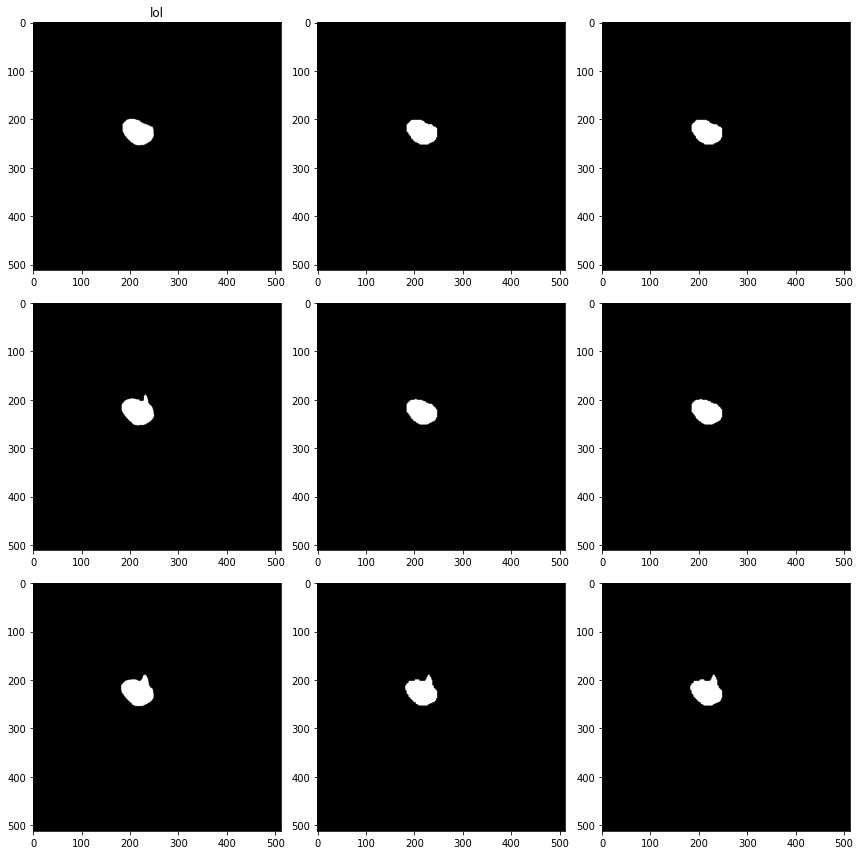

Dice  0.9259479377154404 S Dice 0.916792569388076
VS-SEG-239


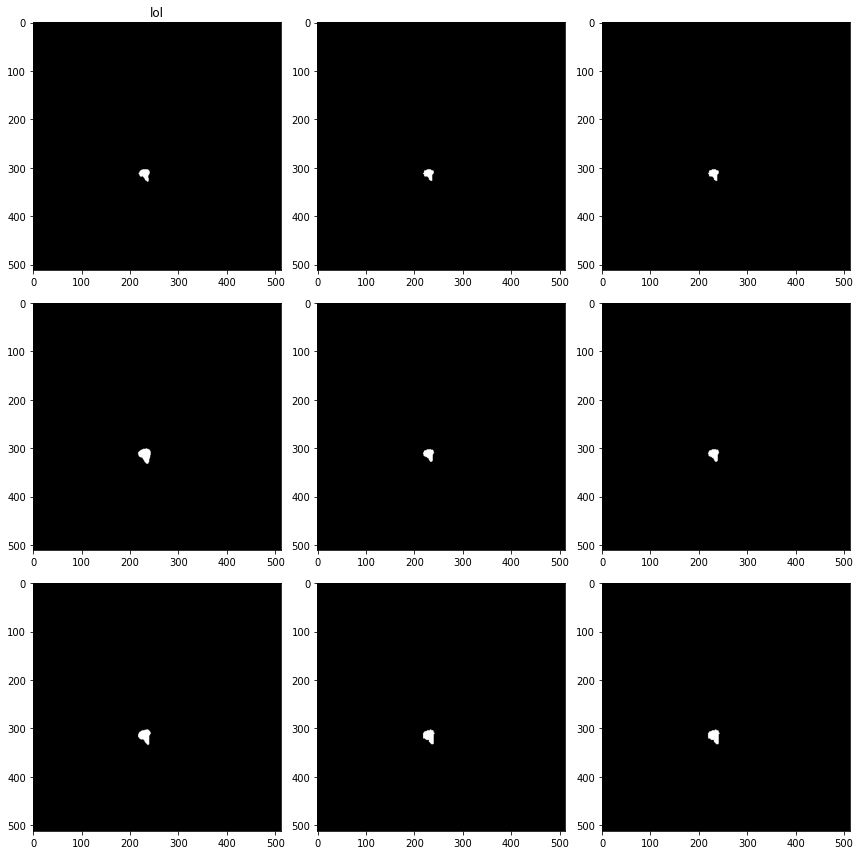

Dice  0.8448979591836735 S Dice 0.9449562301258604
VS-SEG-147


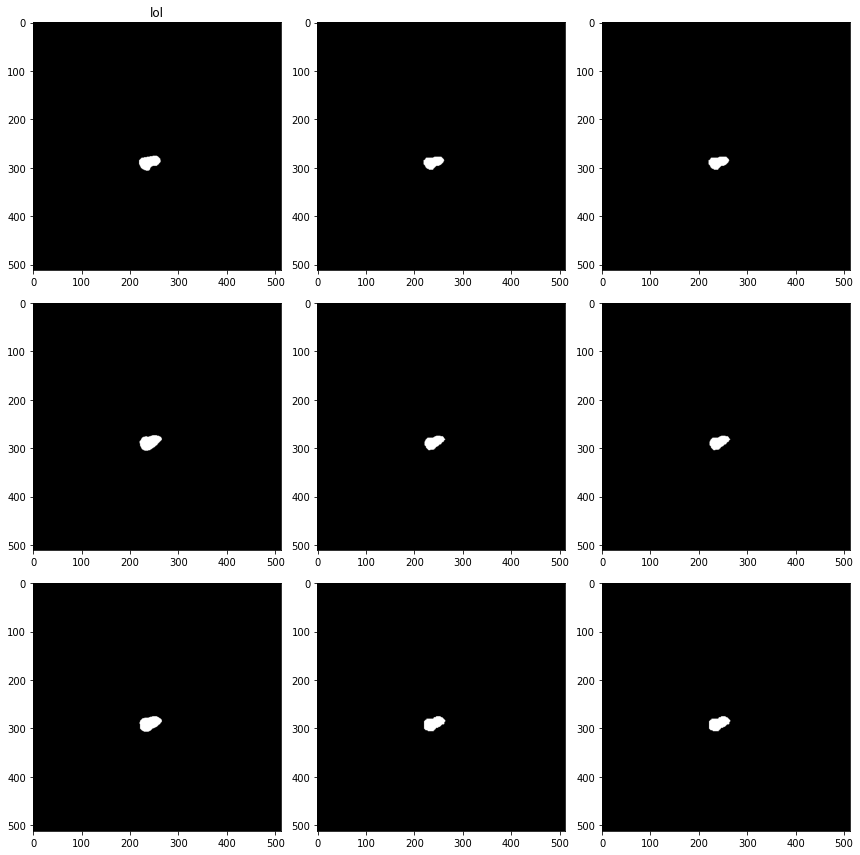

Dice  0.8876627676009711 S Dice 0.932605726601239
VS-SEG-101


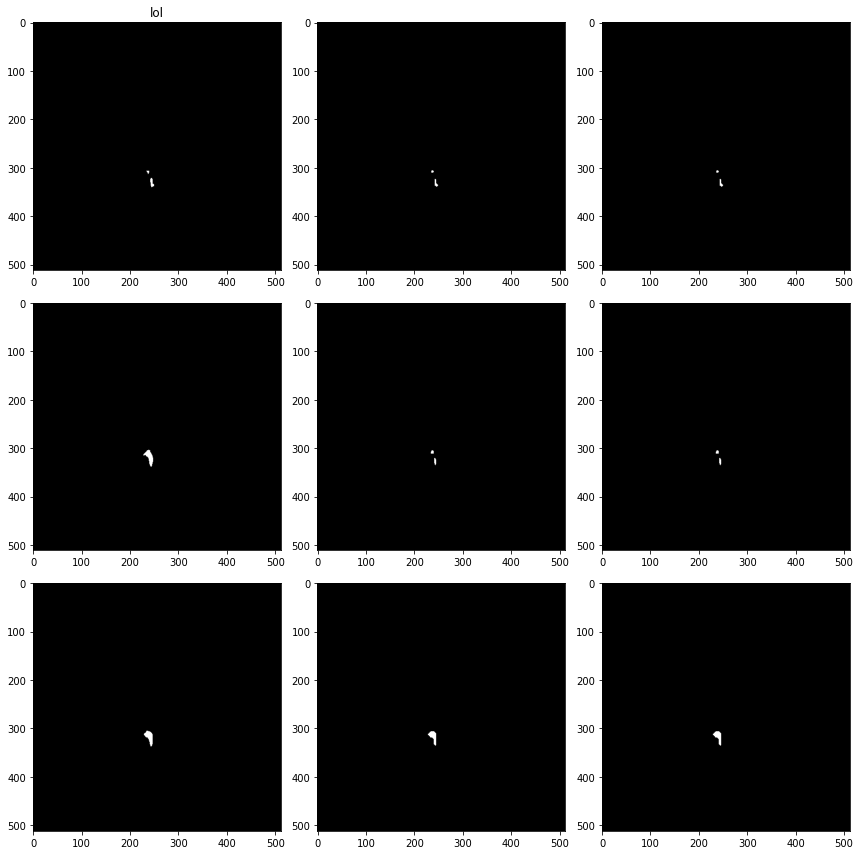

Dice  0.6851098454027664 S Dice 0.8848421953804552
VS-SEG-093


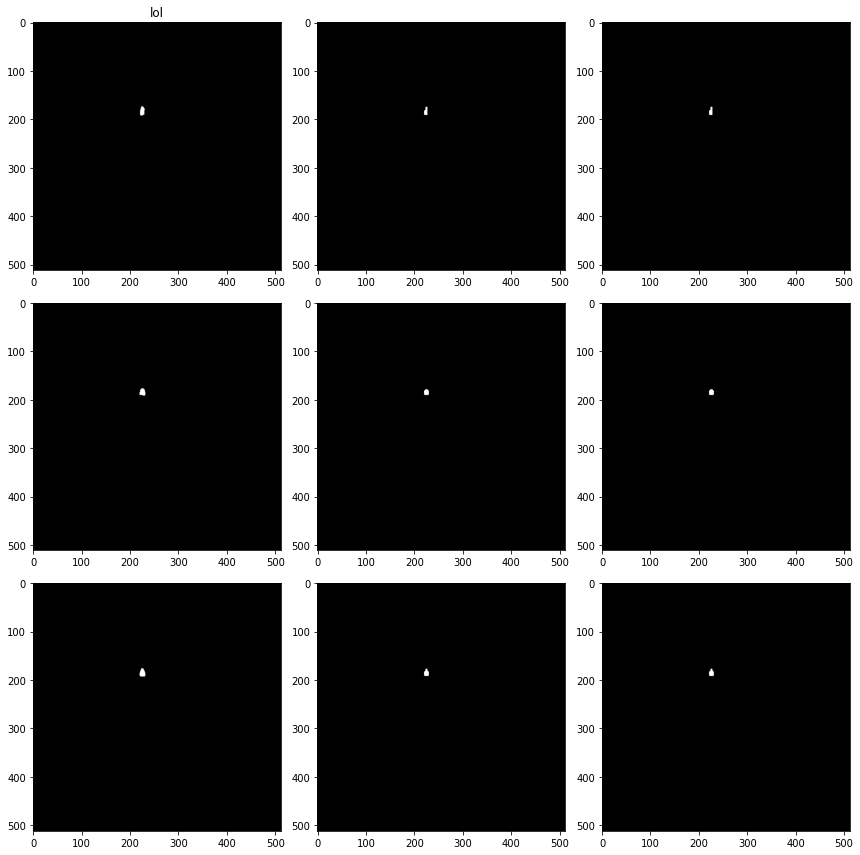

Dice  0.8202846975088968 S Dice 0.9917683167688388
VS-SEG-150


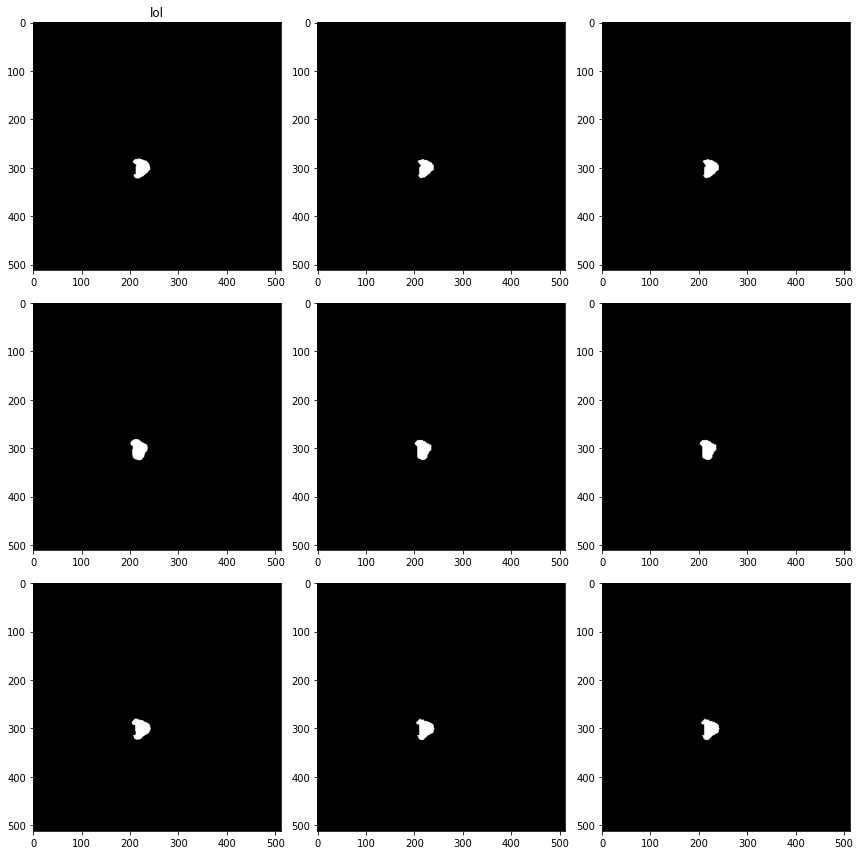

Dice  0.8964238669073523 S Dice 0.9345224474559566
VS-SEG-079


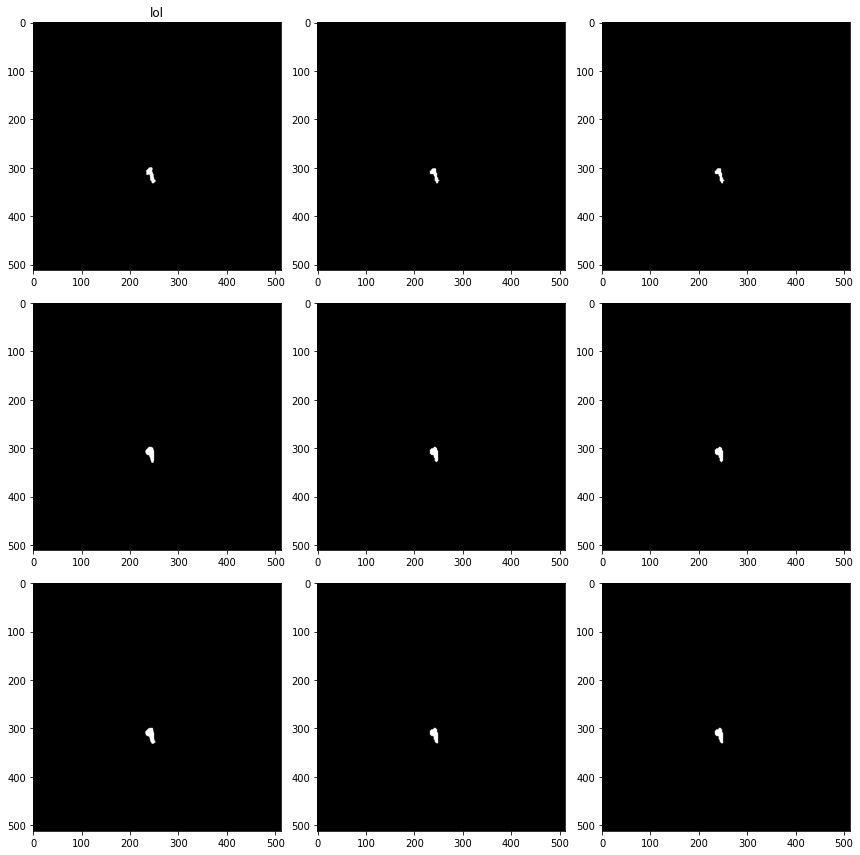

Dice  0.9016620498614959 S Dice 0.9848264495377093
VS-SEG-010


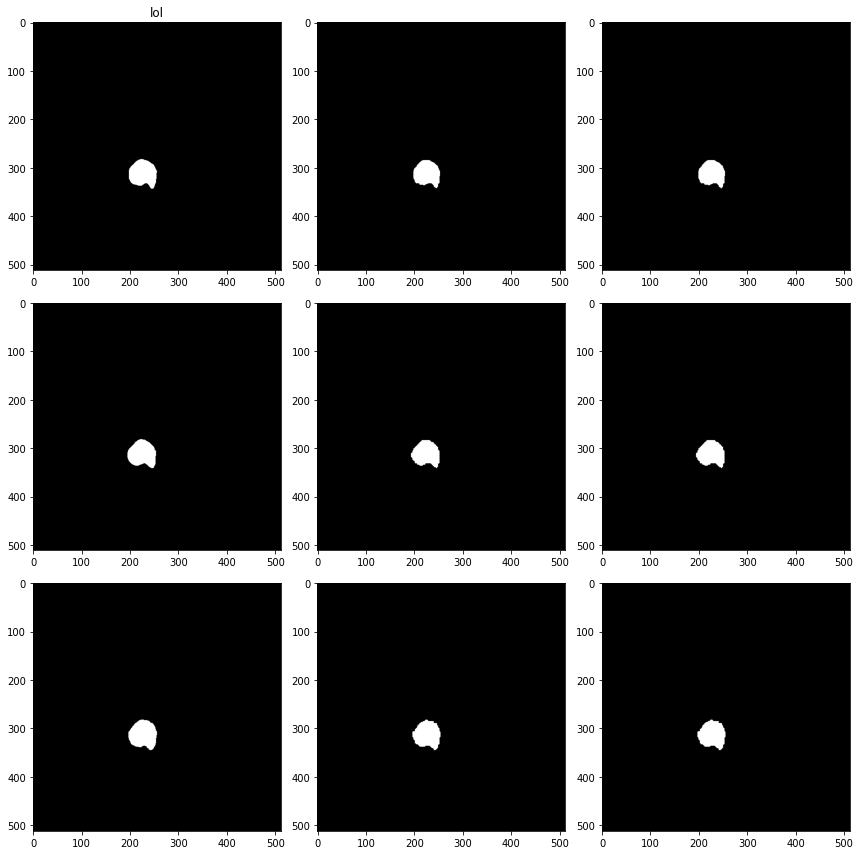

Dice  0.9313030419446093 S Dice 0.9313968600028482
VS-SEG-020


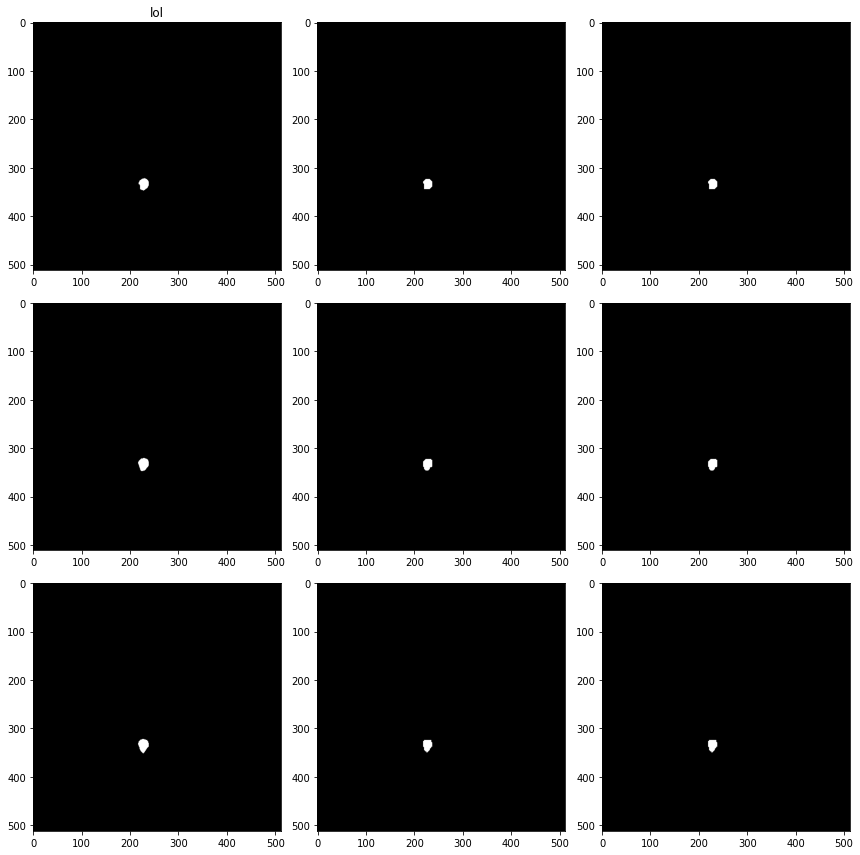

Dice  0.9067877629063098 S Dice 0.9970971816622421
VS-SEG-018


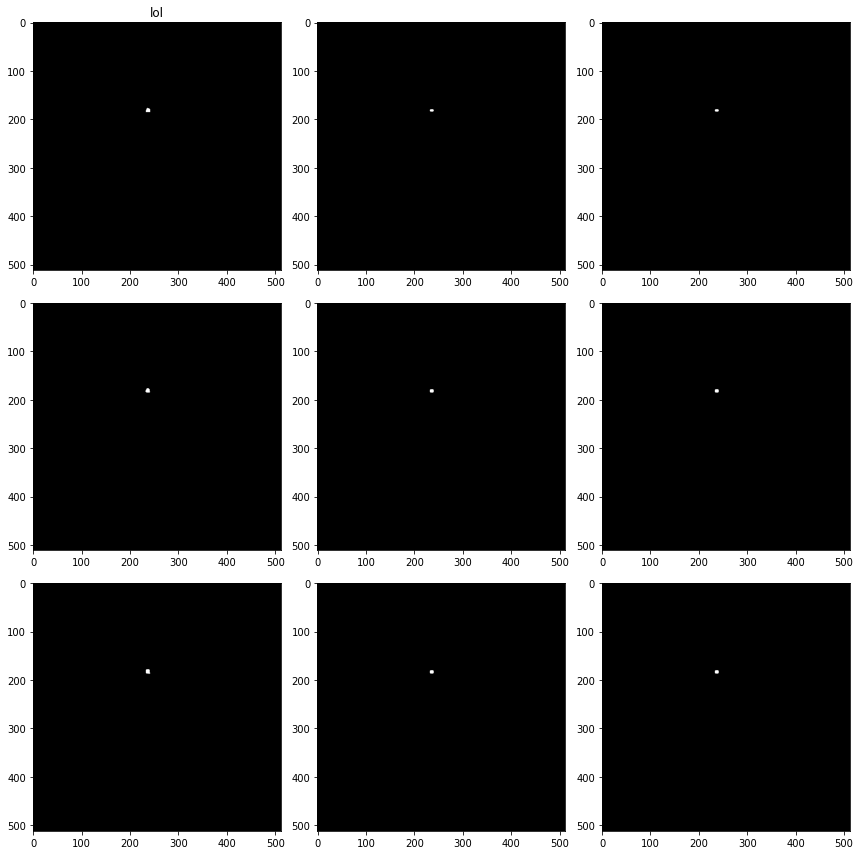

Dice  0.7981859410430839 S Dice 0.995209474126799
VS-SEG-245


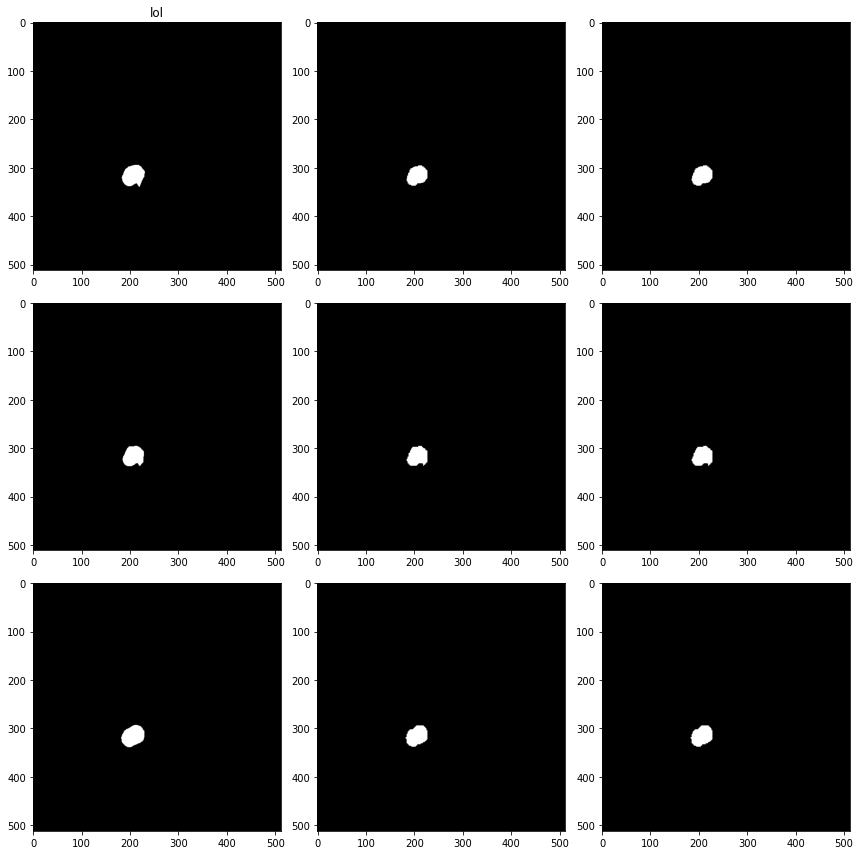

Dice  0.9132116336633663 S Dice 0.923140963148845
VS-SEG-135


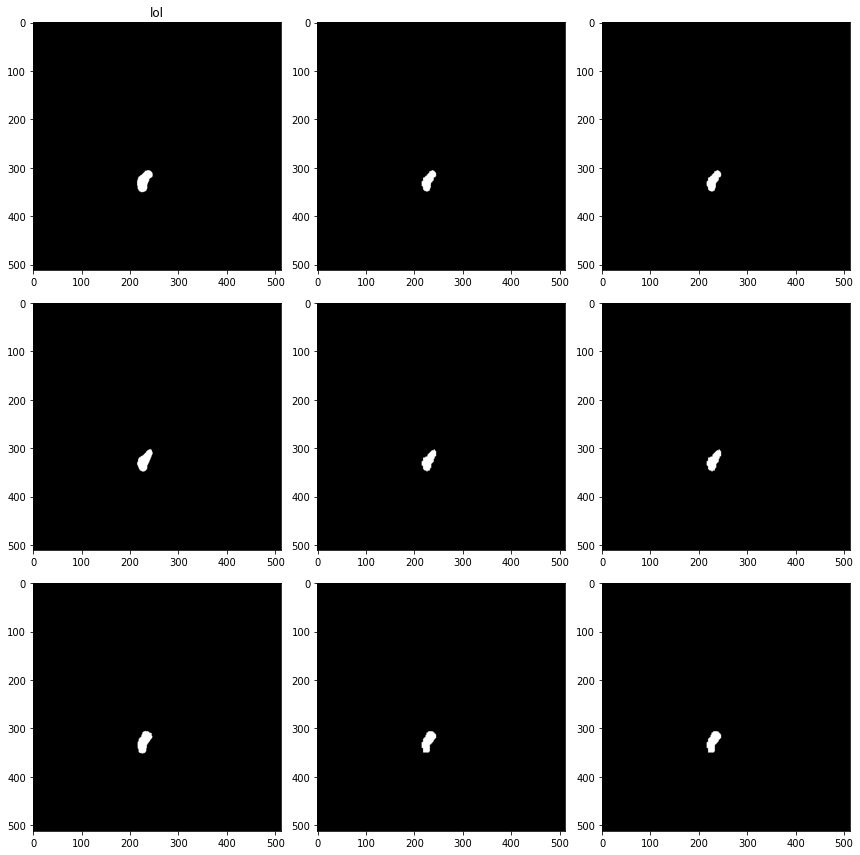

Dice  0.8537396121883657 S Dice 0.9124853619583709
VS-SEG-084


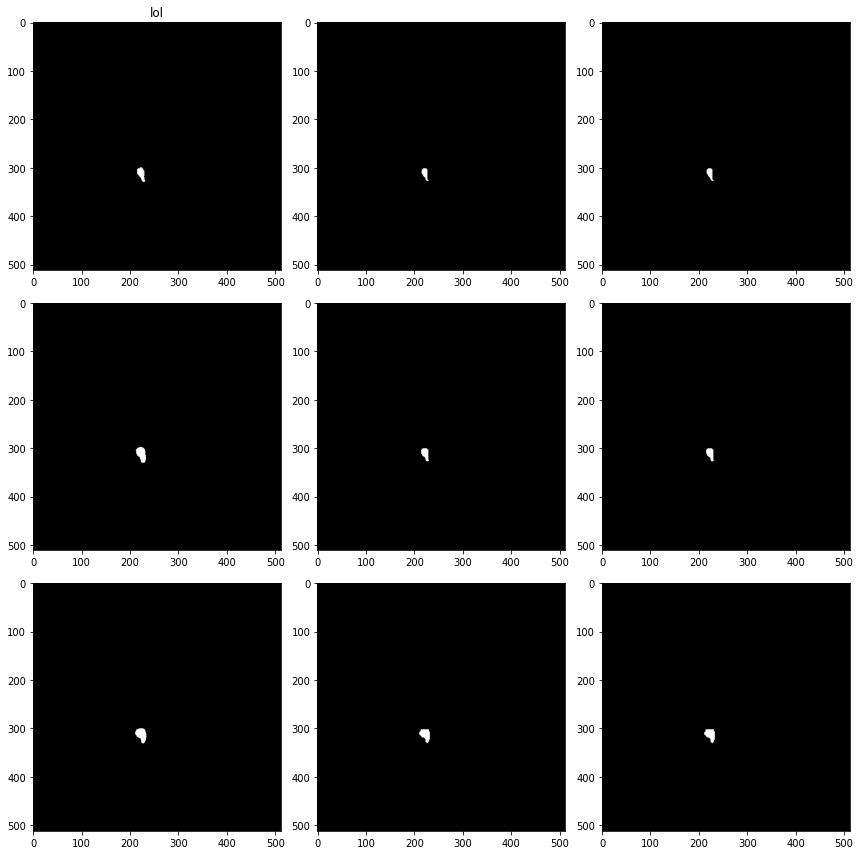

Dice  0.790863245327796 S Dice 0.895397900319278
VS-SEG-056


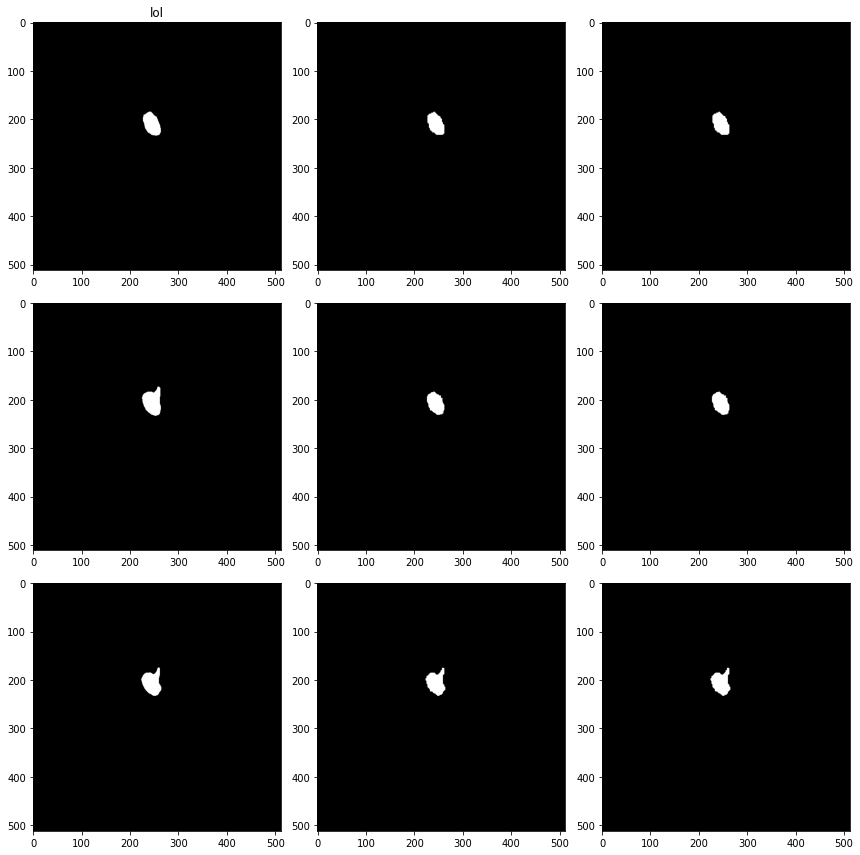

Dice  0.9097258417596163 S Dice 0.9323894227110082
VS-SEG-012


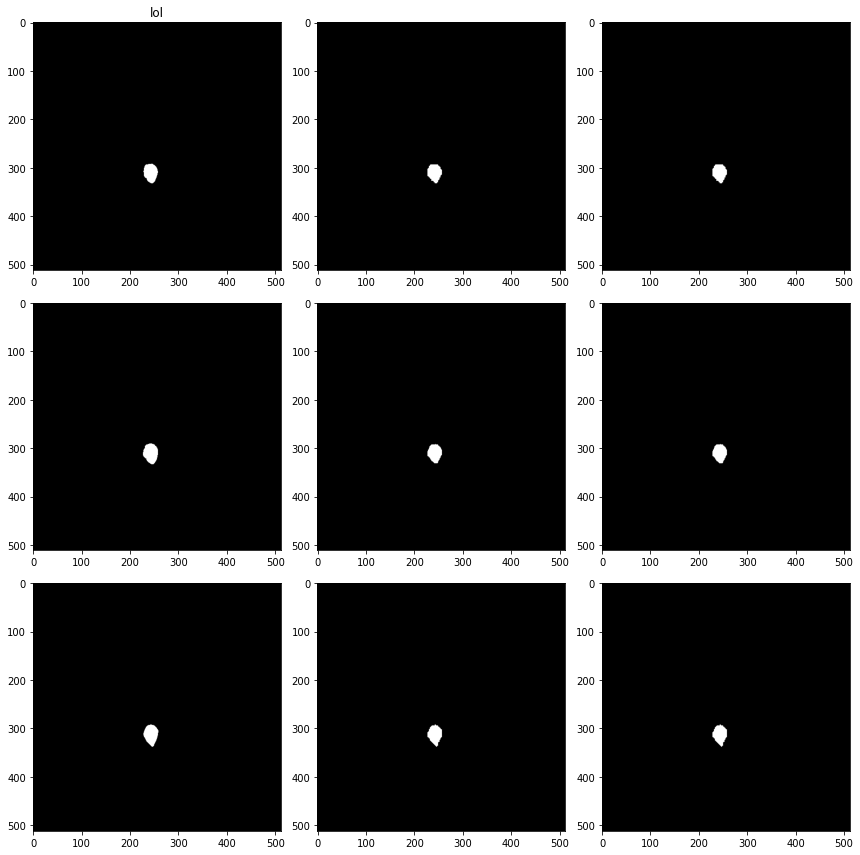

Dice  0.8780042036004752 S Dice 0.8933852756879821
VS-SEG-042


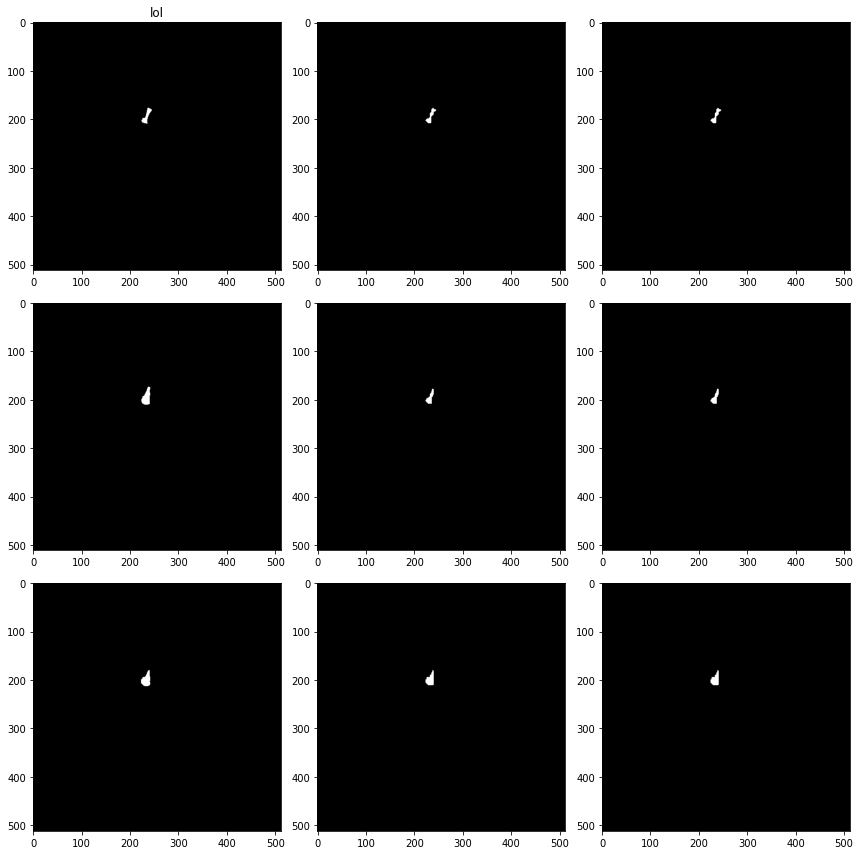

Dice  0.7843298969072164 S Dice 0.9002005395113439
VS-SEG-175


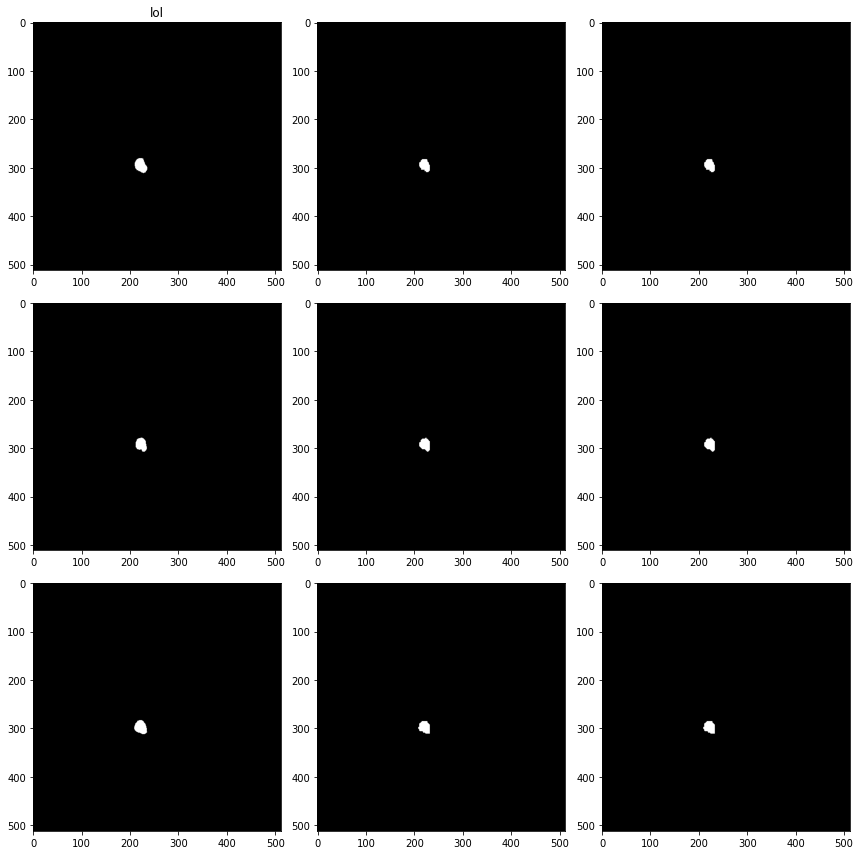

Dice  0.8231481481481482 S Dice 0.8833273388372556
VS-SEG-008


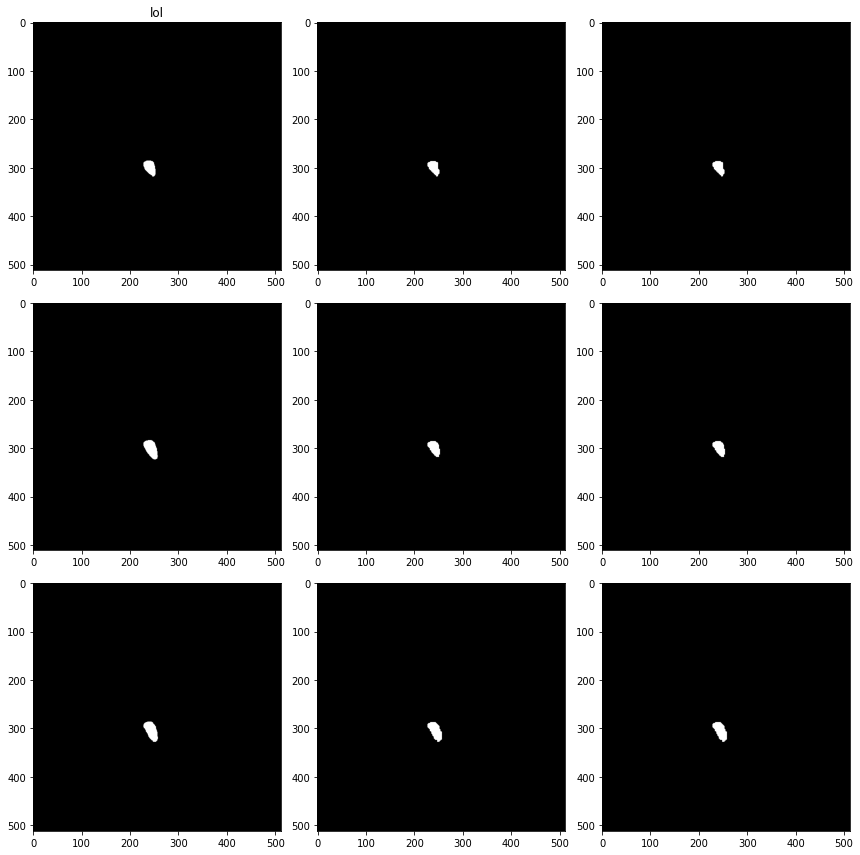

Dice  0.8676159593965882 S Dice 0.9153987935971555
VS-SEG-136


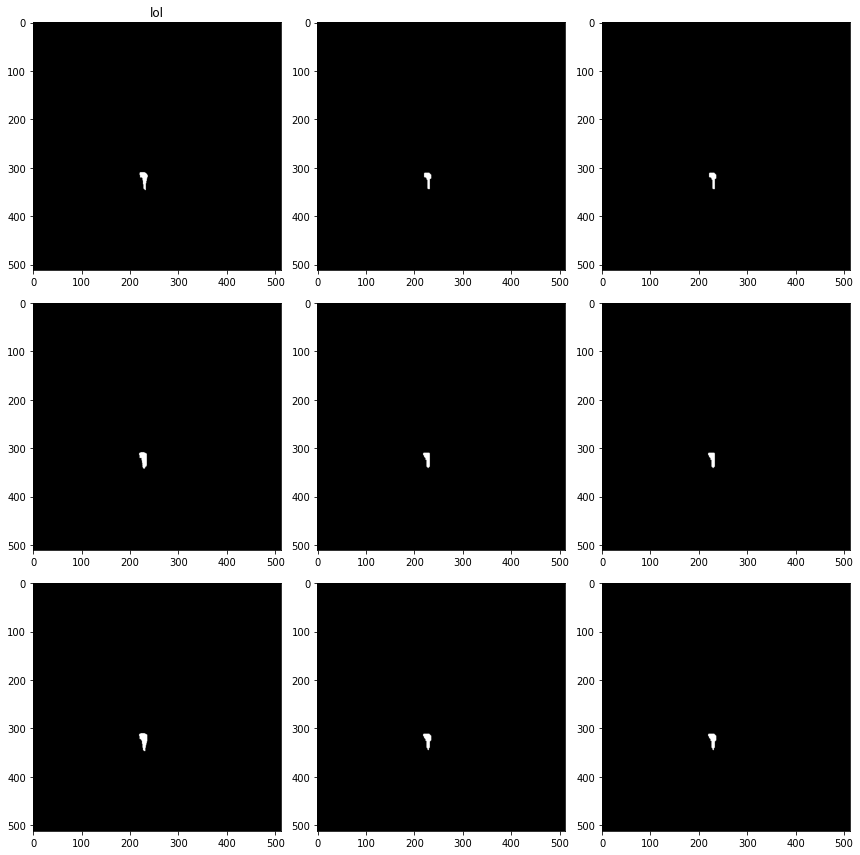

Dice  0.8880468480881847 S Dice 0.9976340849488324
VS-SEG-137


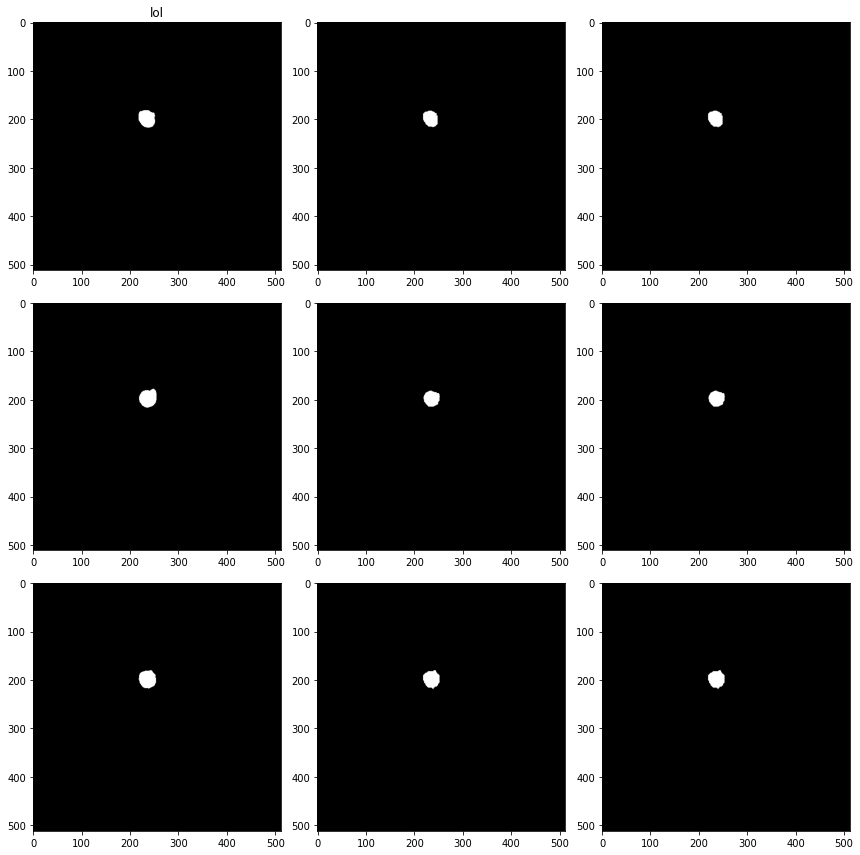

Dice  0.8882740053843853 S Dice 0.9157025934257421
VS-SEG-007


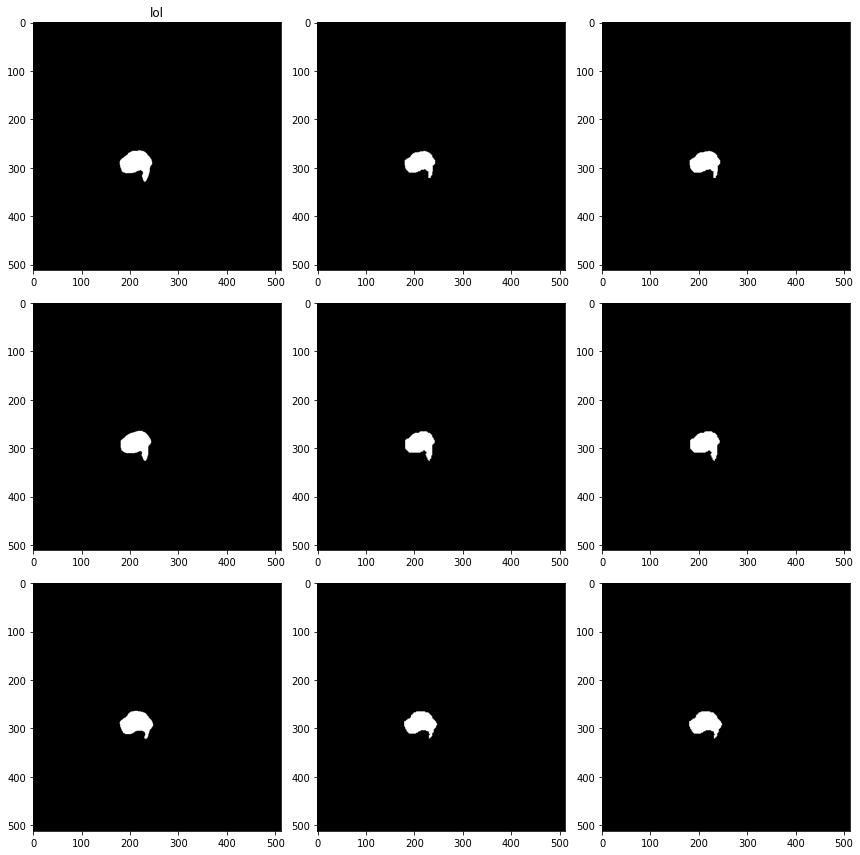

Dice  0.9157747789669614 S Dice 0.9163315908065885
VS-SEG-127


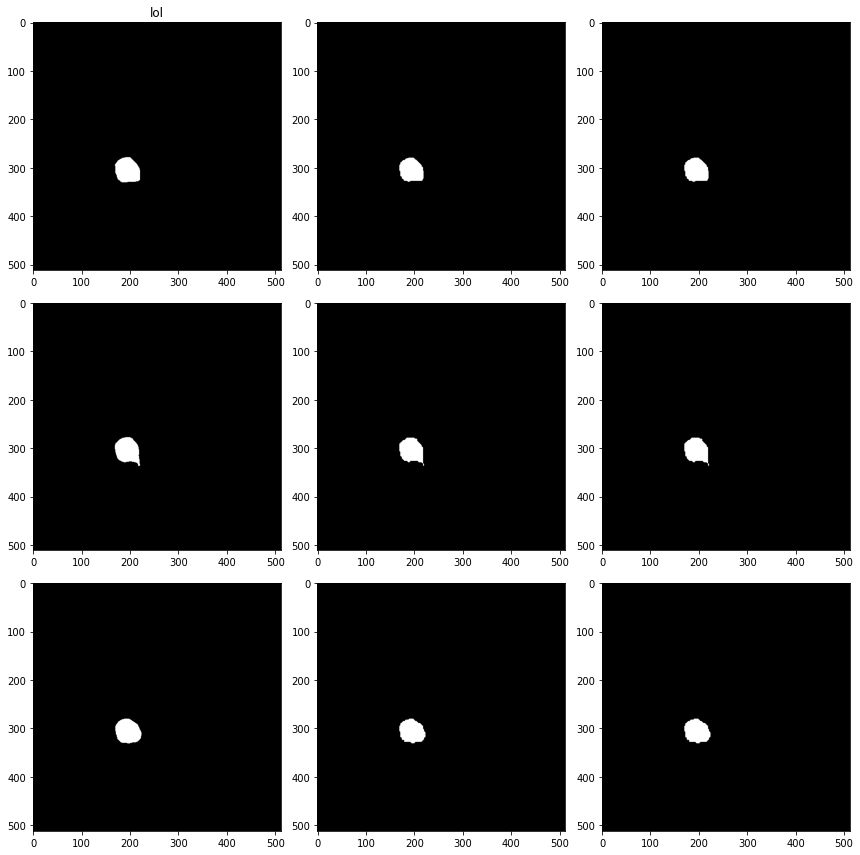

Dice  0.9214683486759859 S Dice 0.9058295229811677
VS-SEG-141


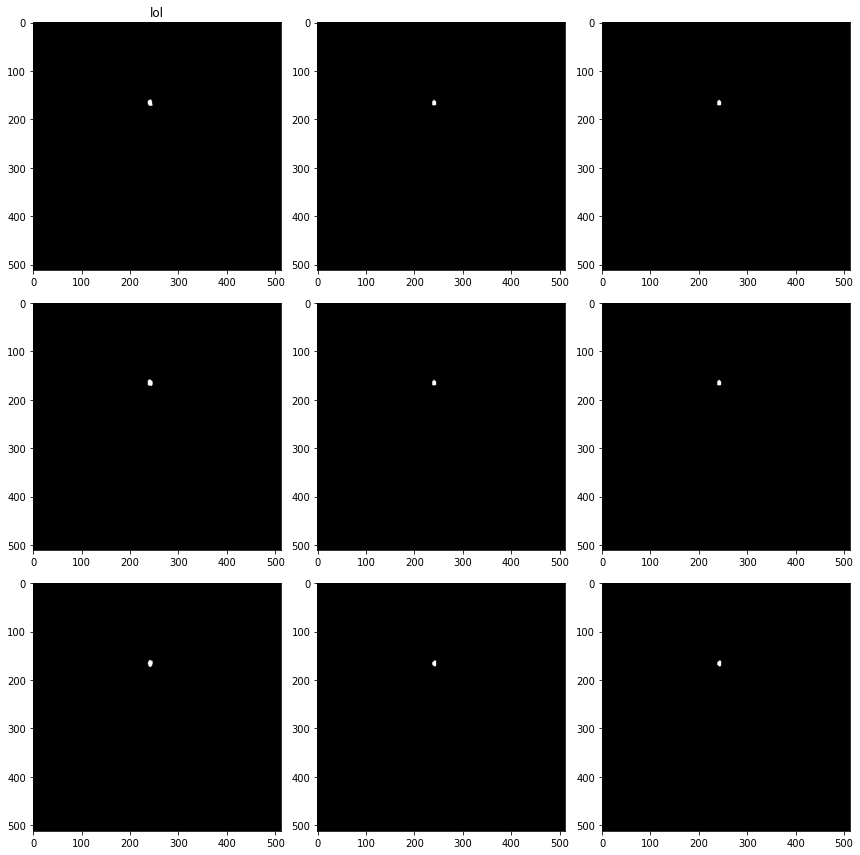

Dice  0.8097982708933718 S Dice 0.988042280868136
VS-SEG-122


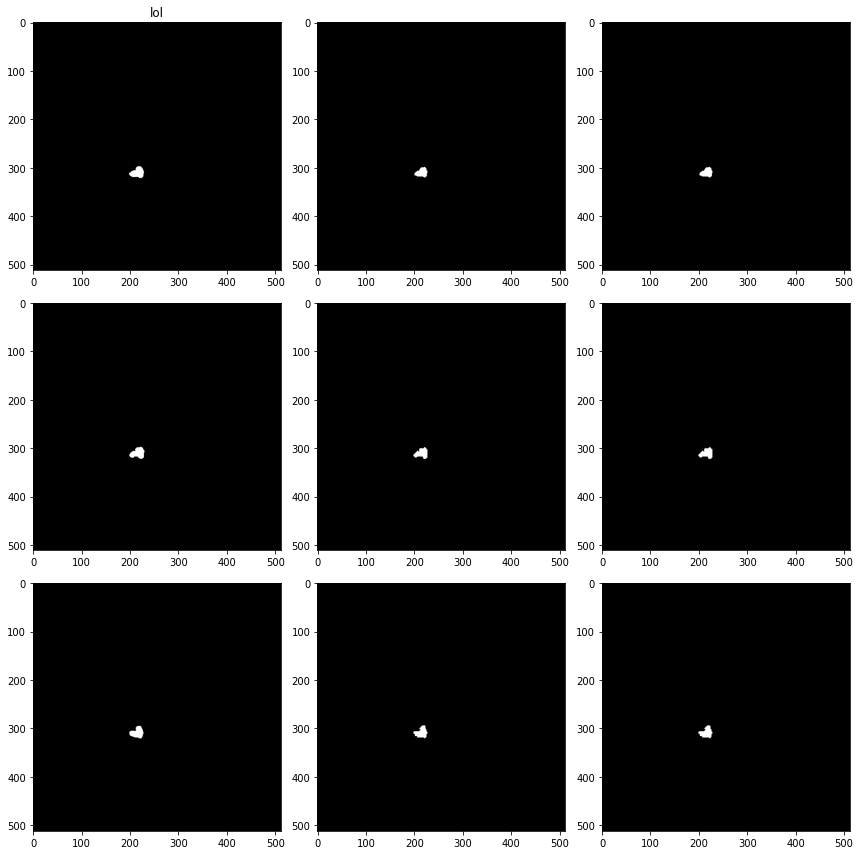

Dice  0.8515751867489445 S Dice 0.9521962015088752
VS-SEG-099


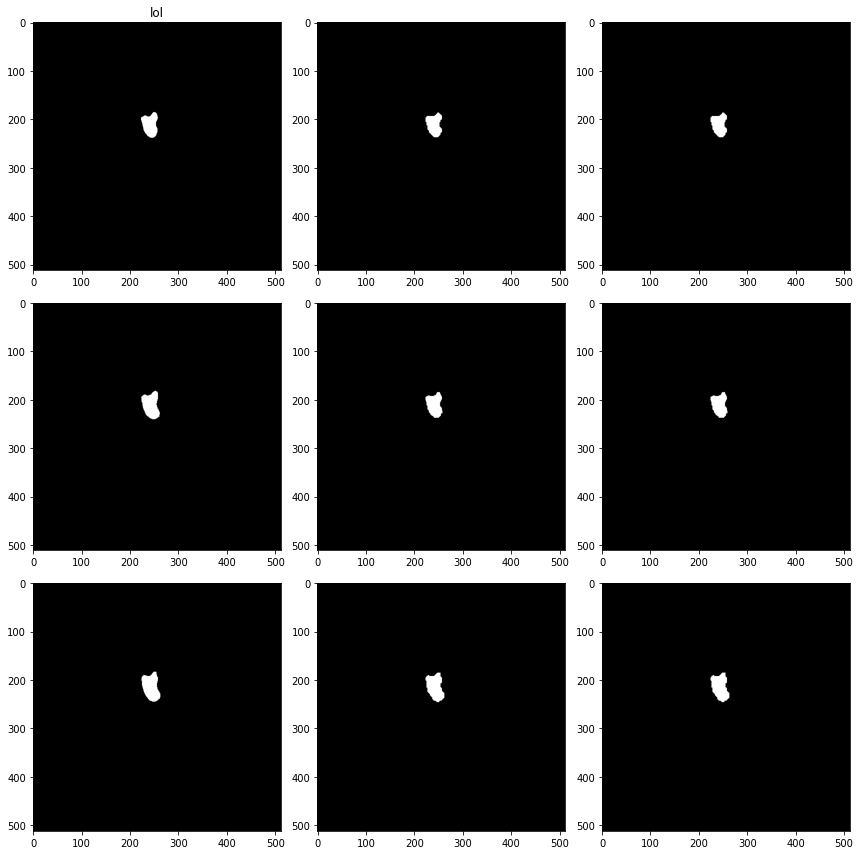

Dice  0.9069777917924231 S Dice 0.9179156388176387
VS-SEG-123


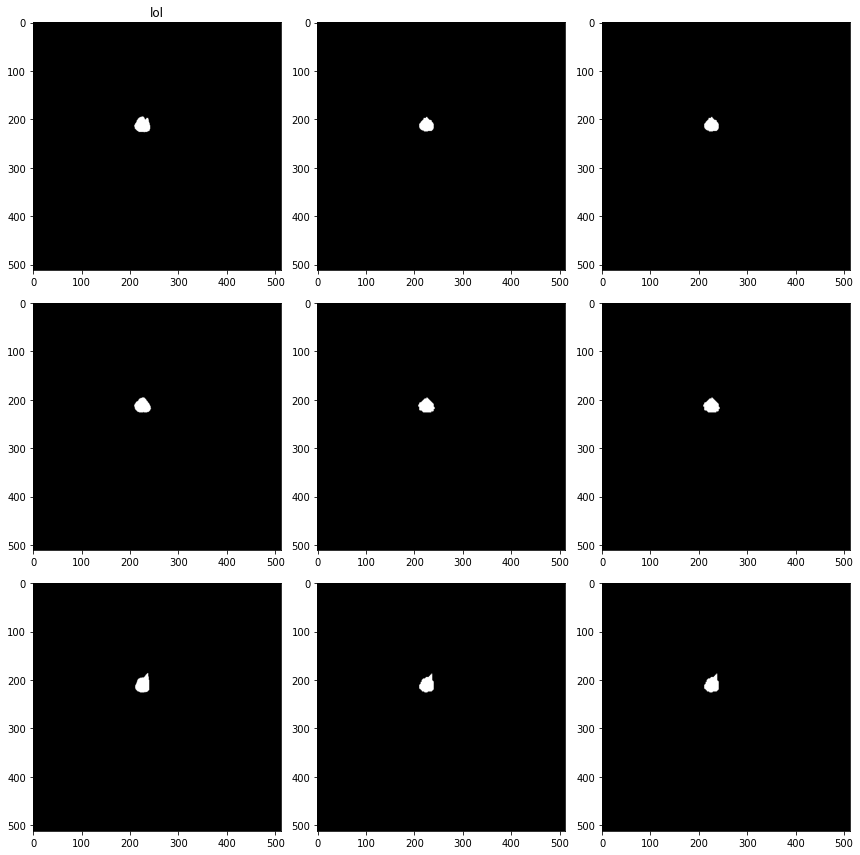

Dice  0.8774078610399733 S Dice 0.9218641973312995
VS-SEG-235


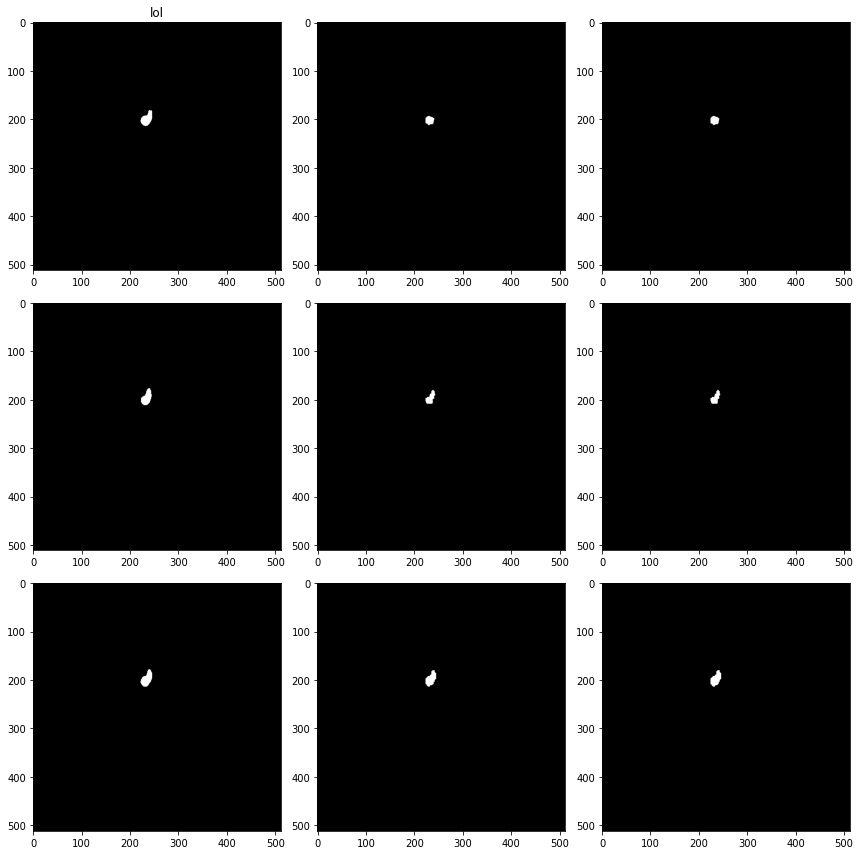

Dice  0.8247920579554602 S Dice 0.9087027950789988
VS-SEG-204


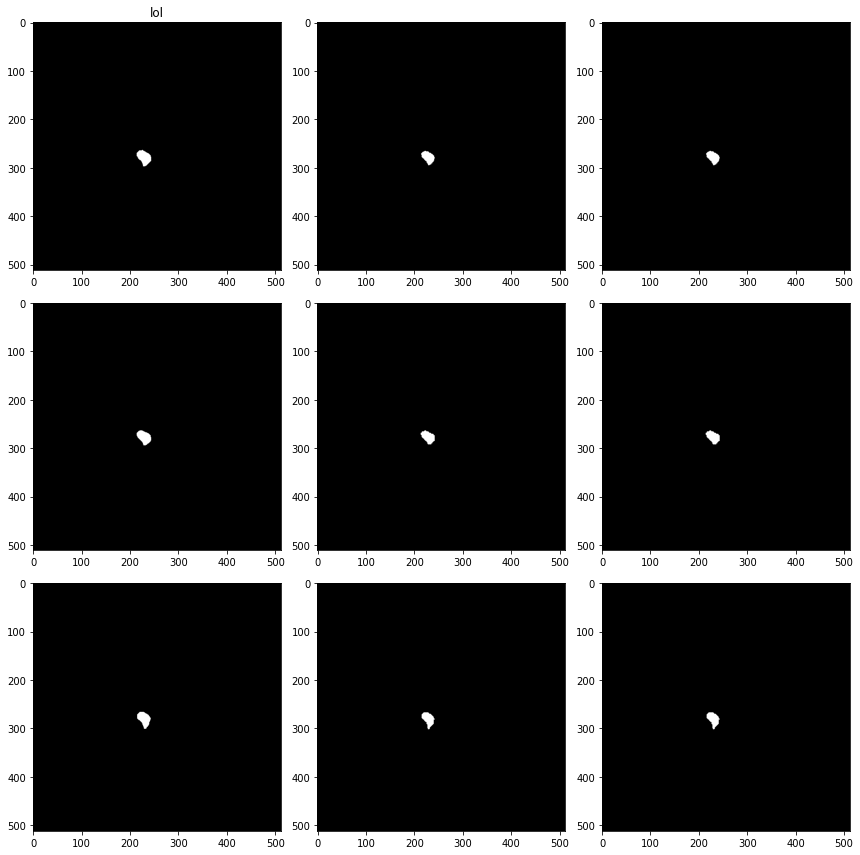

Dice  0.8629336997595328 S Dice 0.9425563396065858
VS-SEG-047


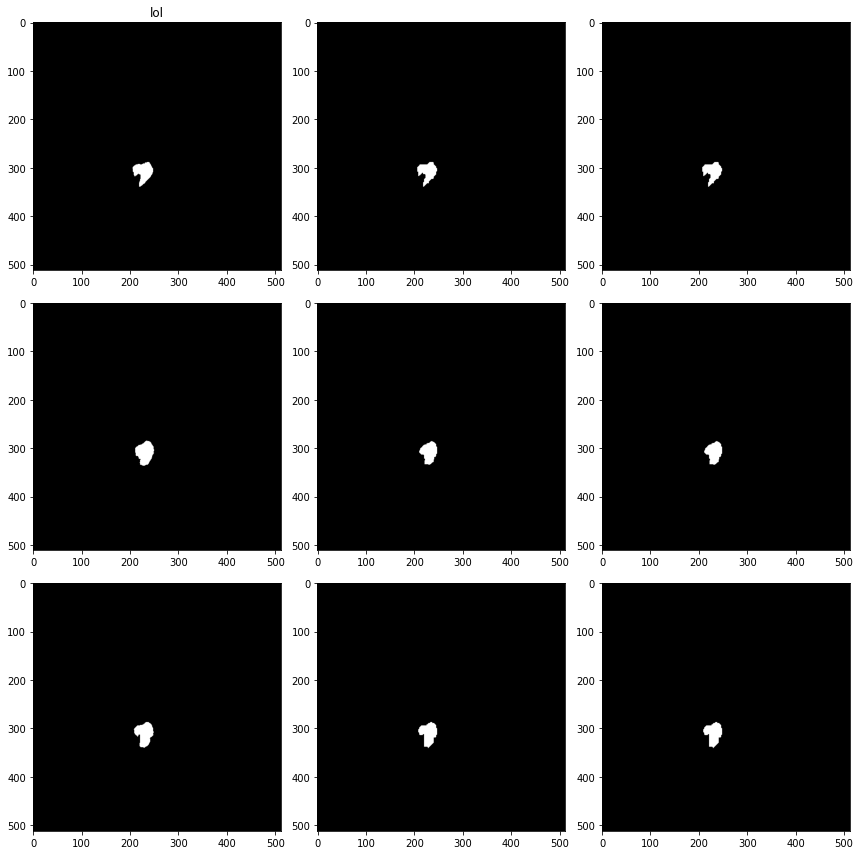

Dice  0.910380092040225 S Dice 0.9389183400878094
VS-SEG-116


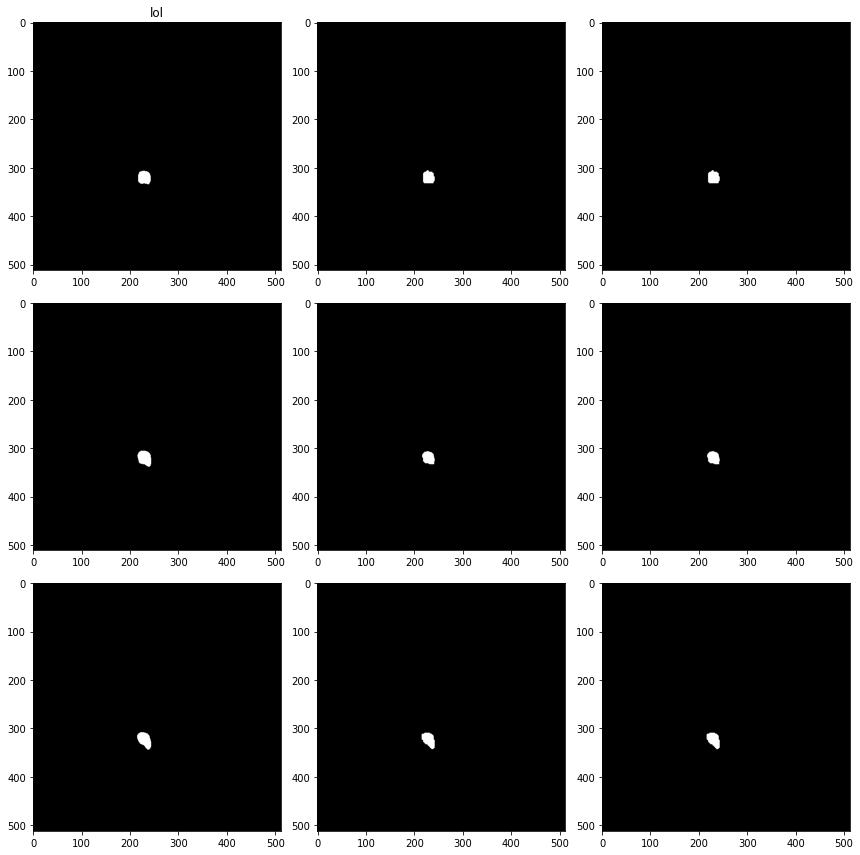

Dice  0.8366093366093366 S Dice 0.9057032142913476
VS-SEG-151


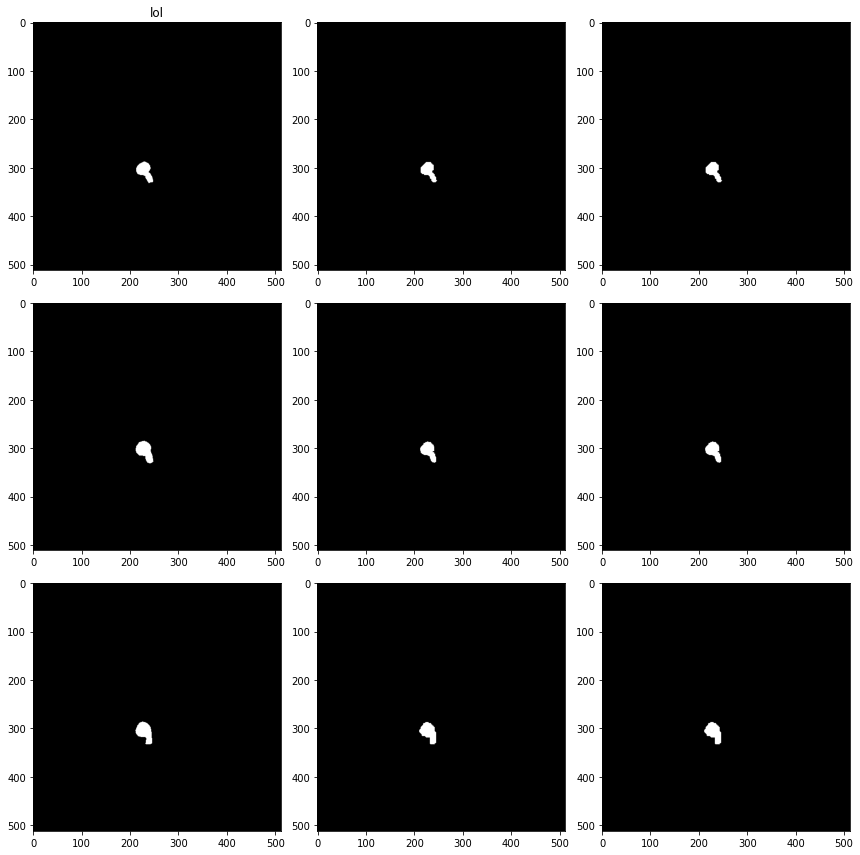

Dice  0.8898744927809757 S Dice 0.9300700975118565
VS-SEG-074


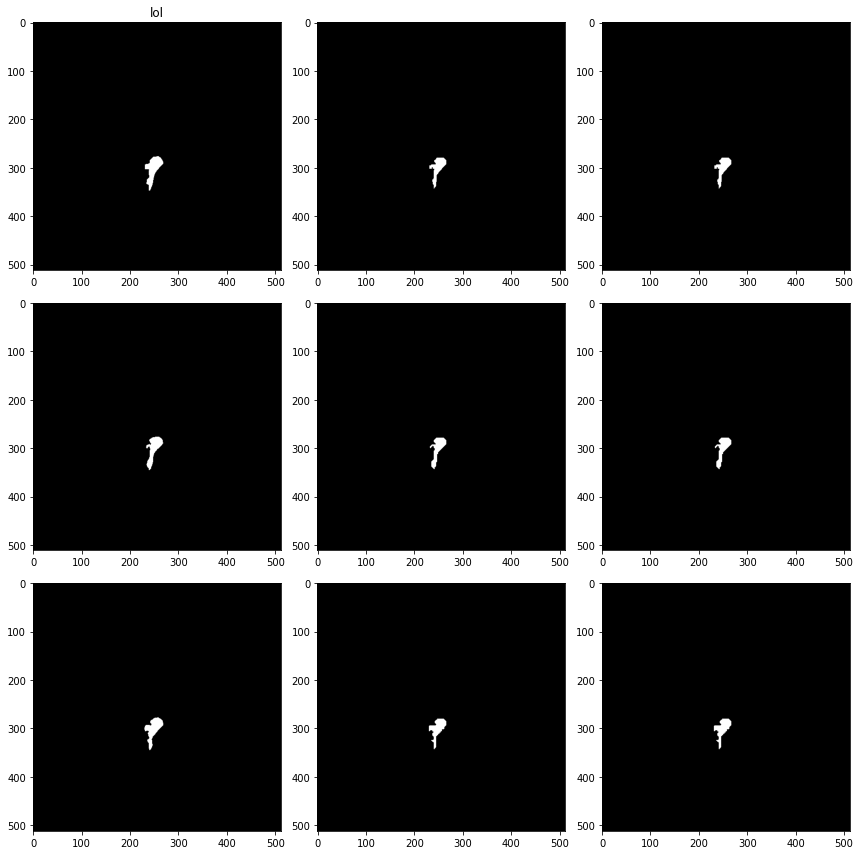

Dice  0.8503547795583194 S Dice 0.9236034845397525
VS-SEG-126


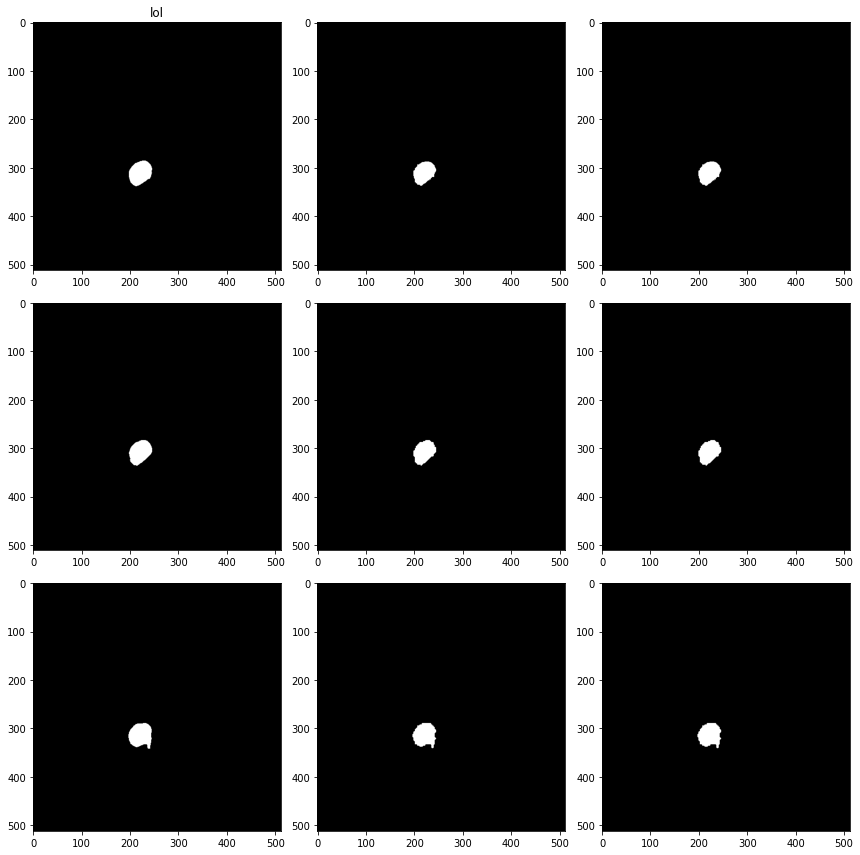

Dice  0.9248669389775962 S Dice 0.9319259100016479
VS-SEG-191


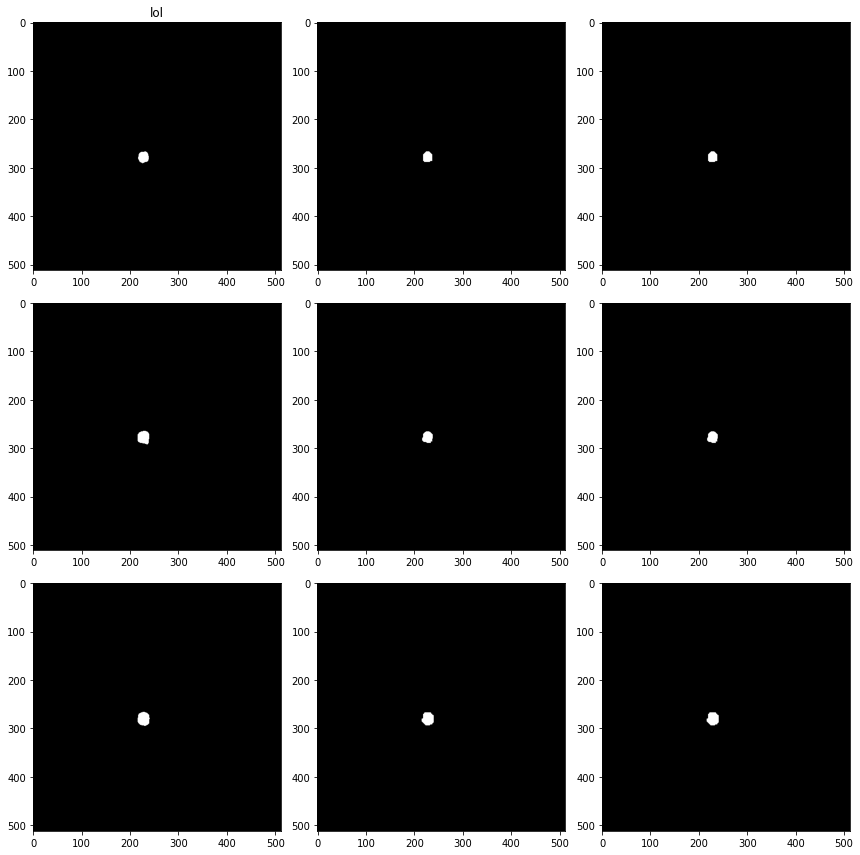

Dice  0.8332179930795848 S Dice 0.8871759761340963
VS-SEG-069


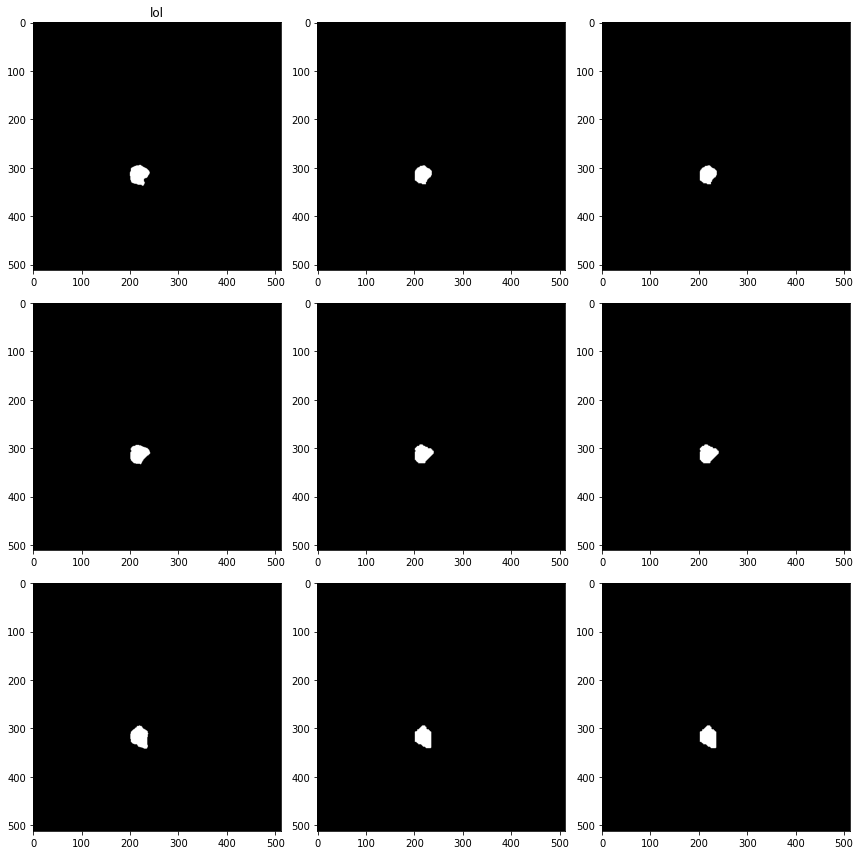

Dice  0.8946940985381701 S Dice 0.9175013557988365
VS-SEG-159


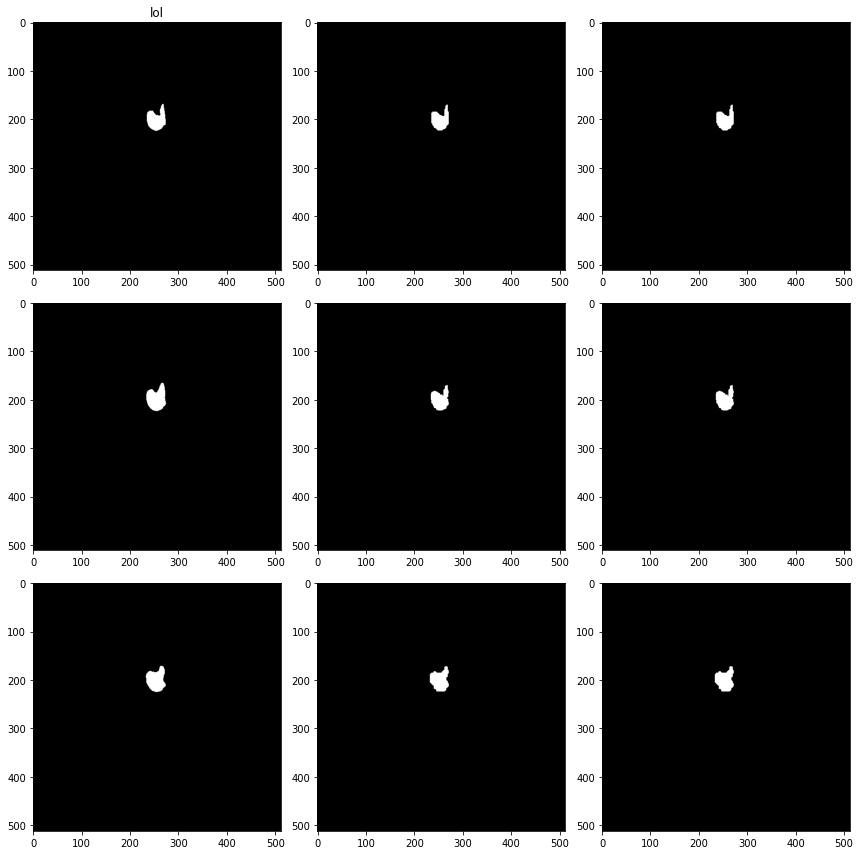

Dice  0.9011294526498697 S Dice 0.9298814684379151
VS-SEG-155


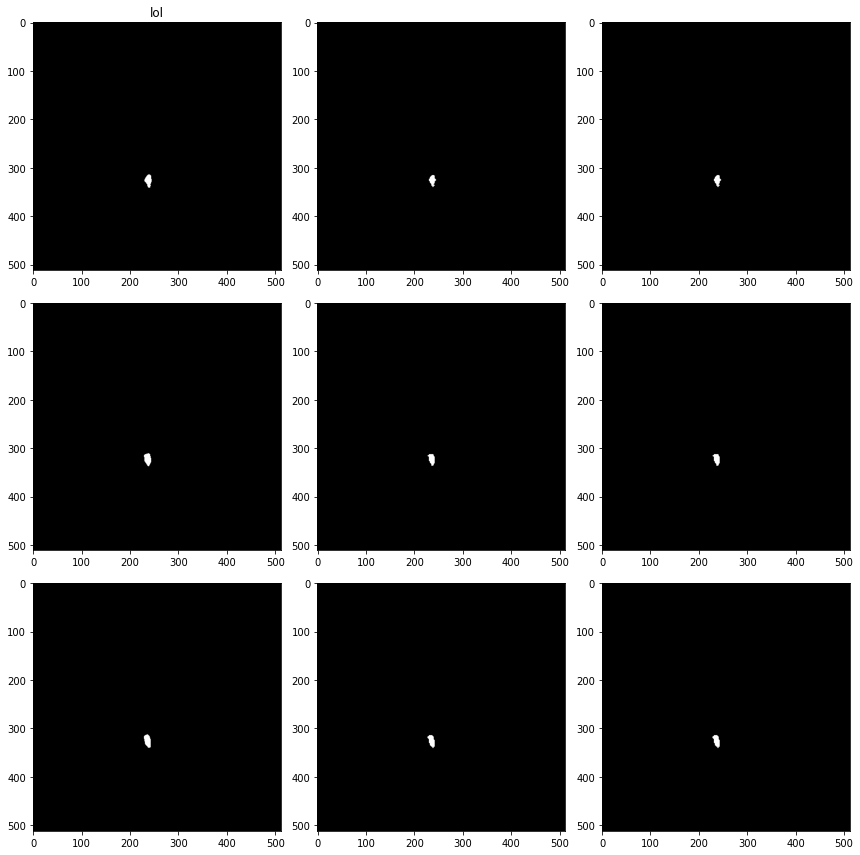

Dice  0.8909413854351688 S Dice 0.9987011081494731
VS-SEG-048


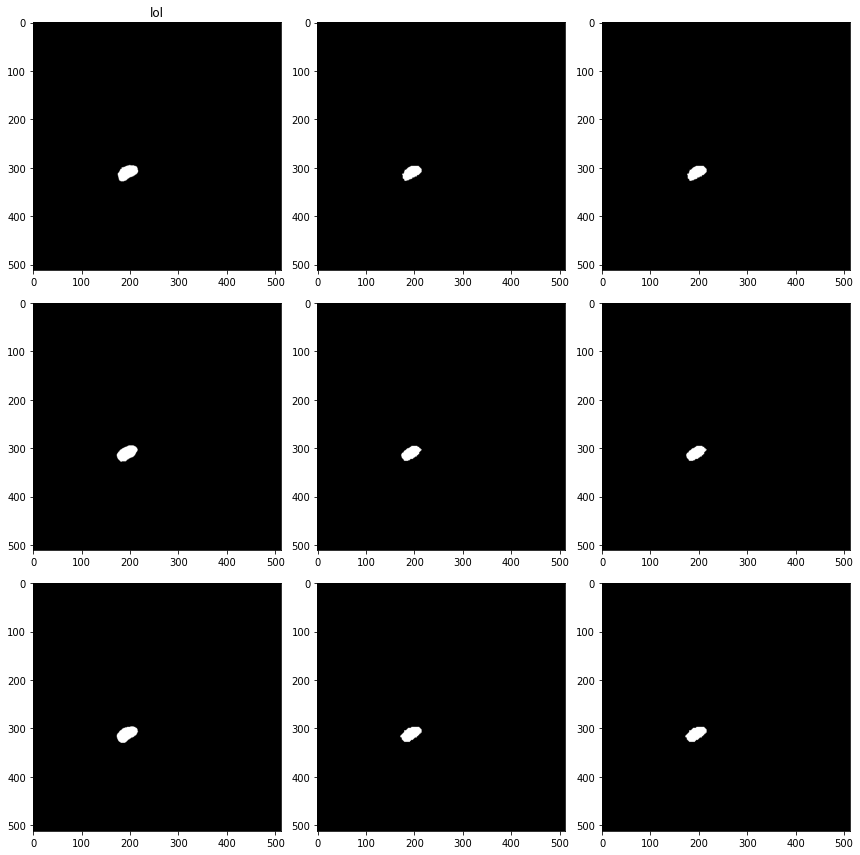

Dice  0.8742972466484071 S Dice 0.9093728675523526
VS-SEG-022


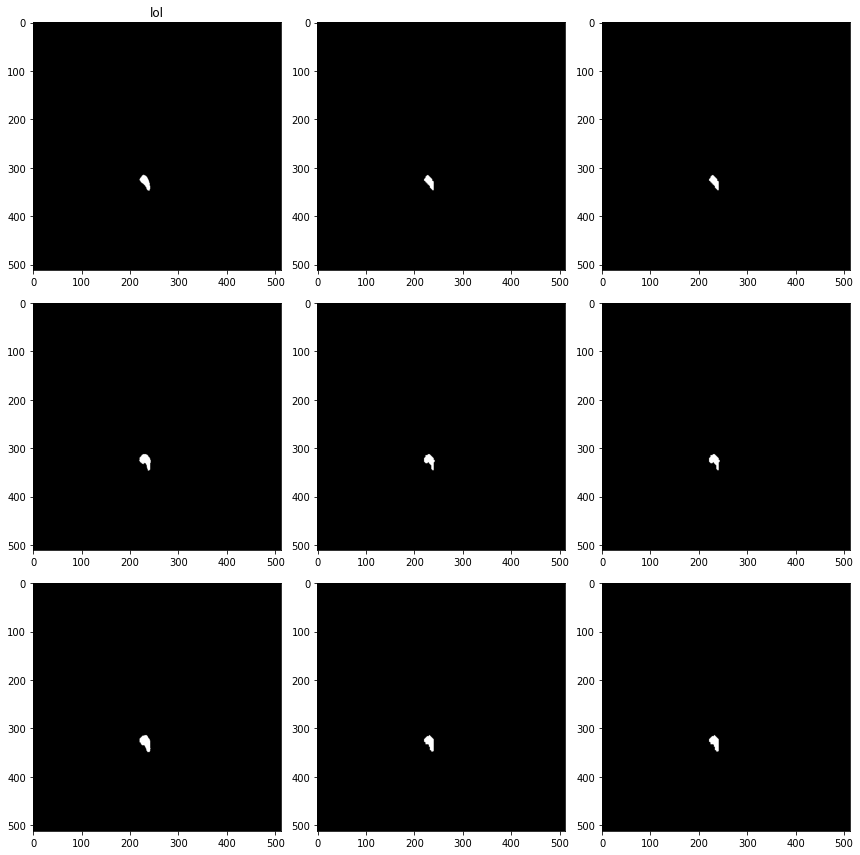

Dice  0.8955143701316143 S Dice 0.9950975981028773
VS-SEG-071


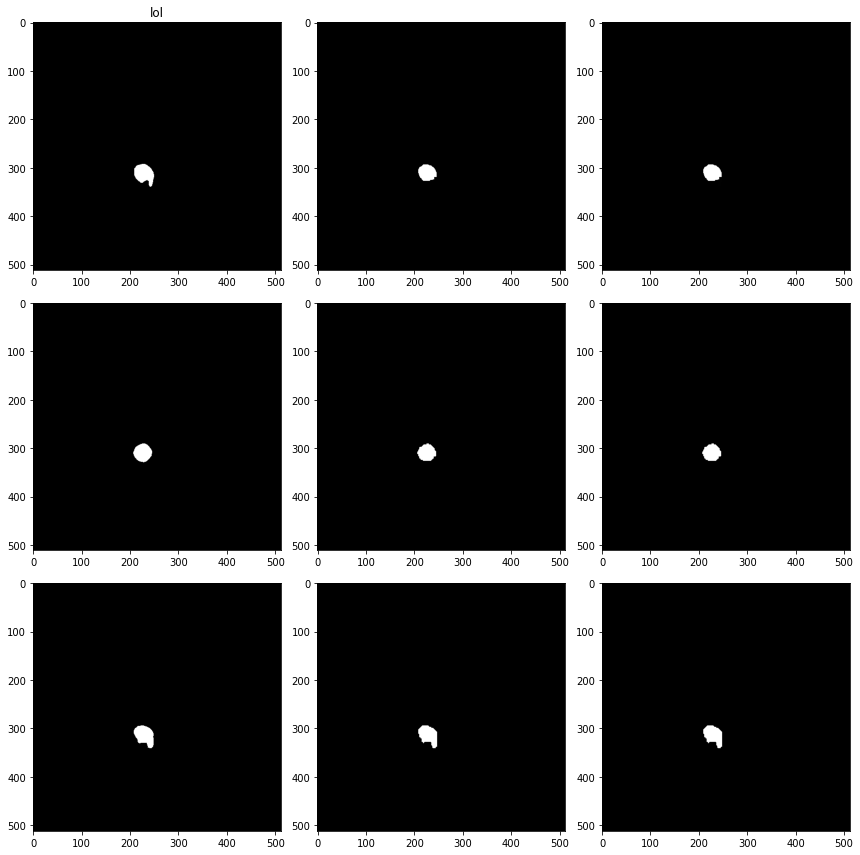

Dice  0.8649555199066647 S Dice 0.8576736965427478
VS-SEG-131


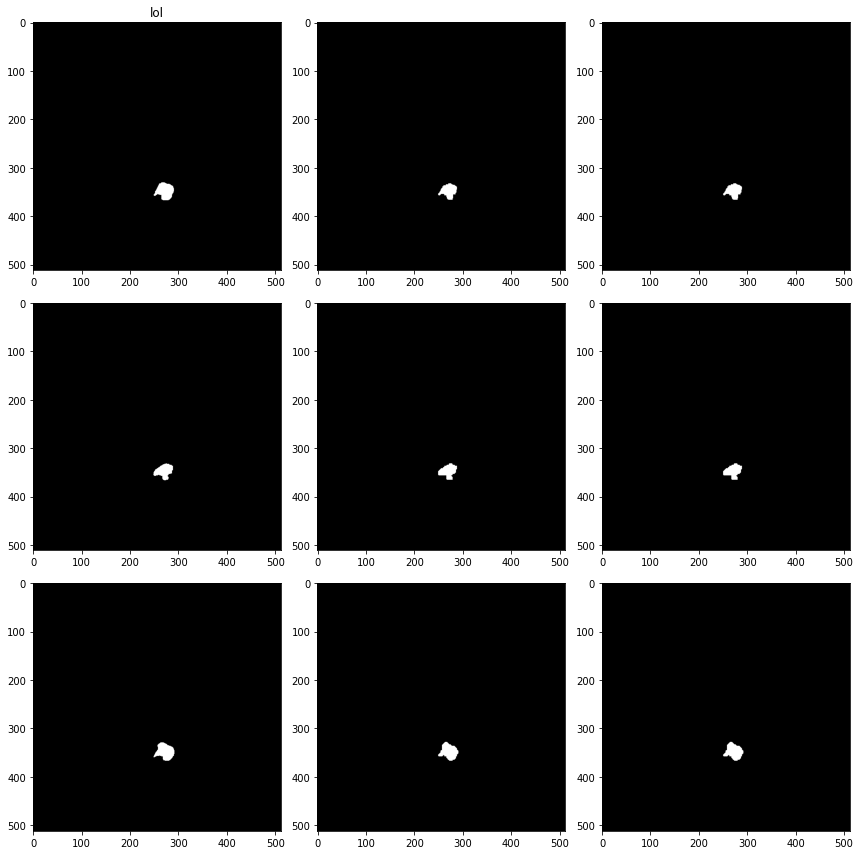

Dice  0.8544419597479163 S Dice 0.8786561274730248
VS-SEG-128


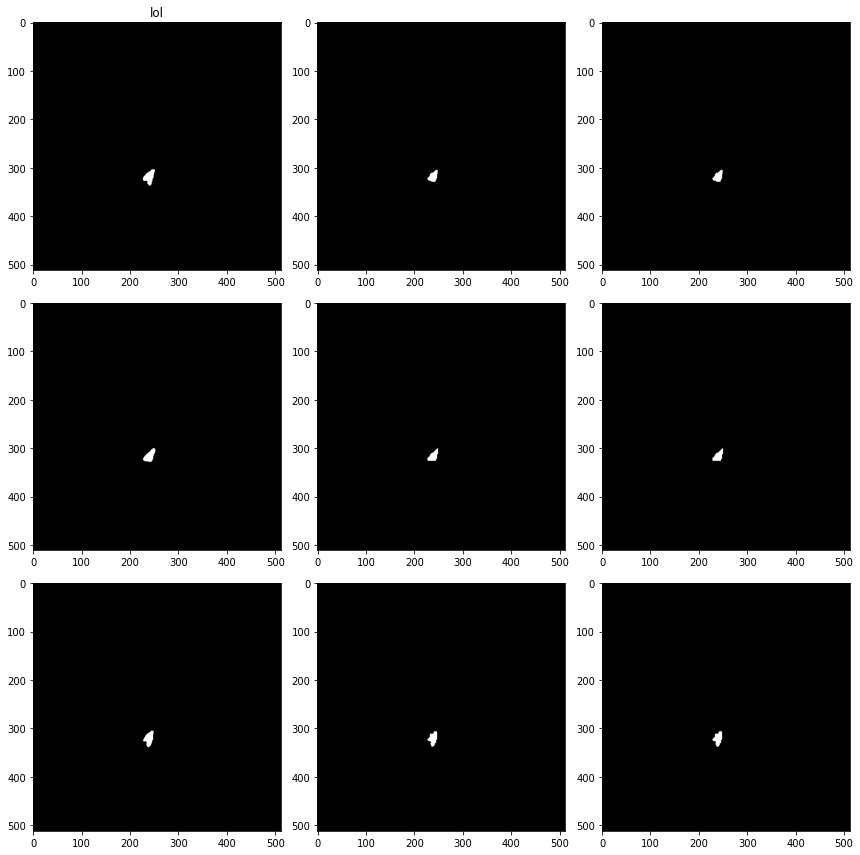

Dice  0.7894080996884735 S Dice 0.9108021923955736
VS-SEG-237


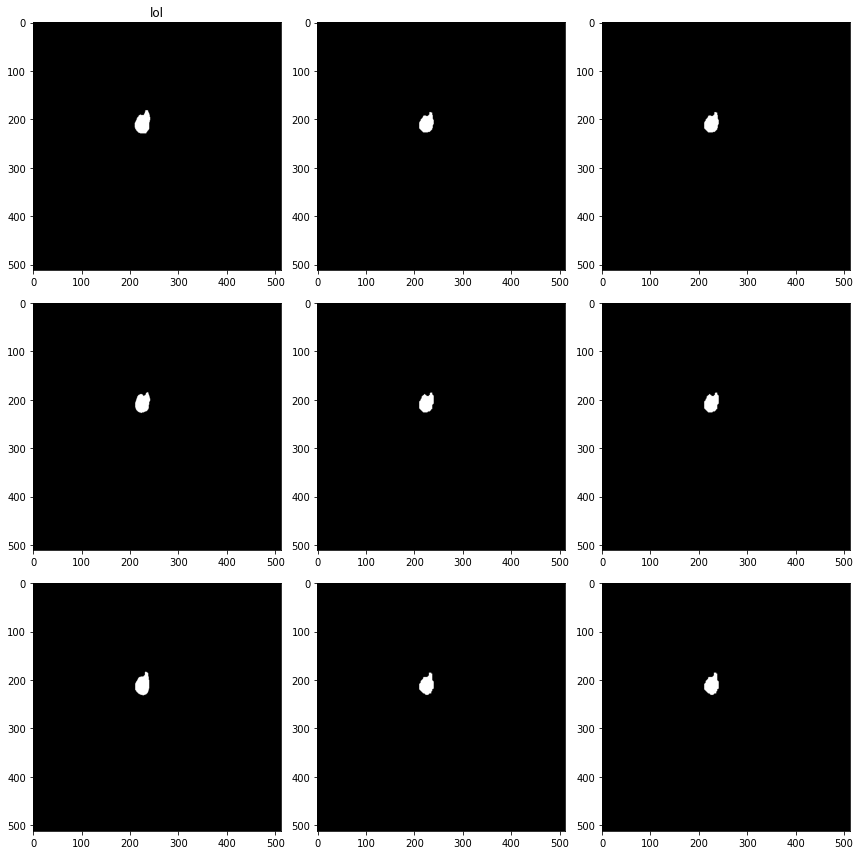

Dice  0.8715154055753511 S Dice 0.8995573872724614
VS-SEG-115


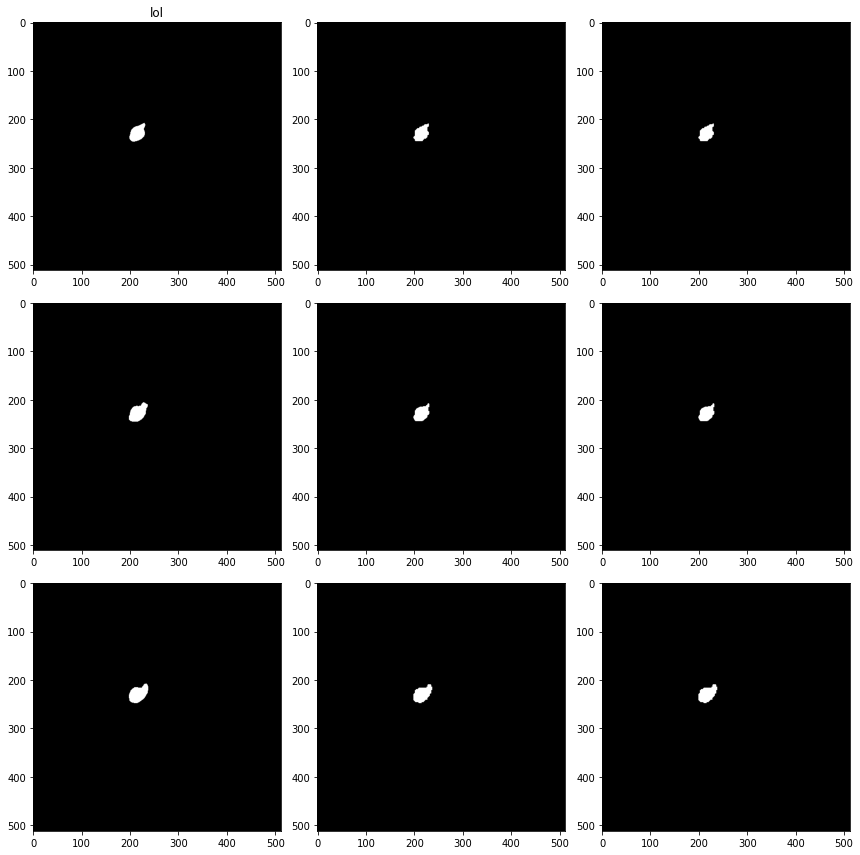

Dice  0.874826147426982 S Dice 0.9074560489451949
VS-SEG-247


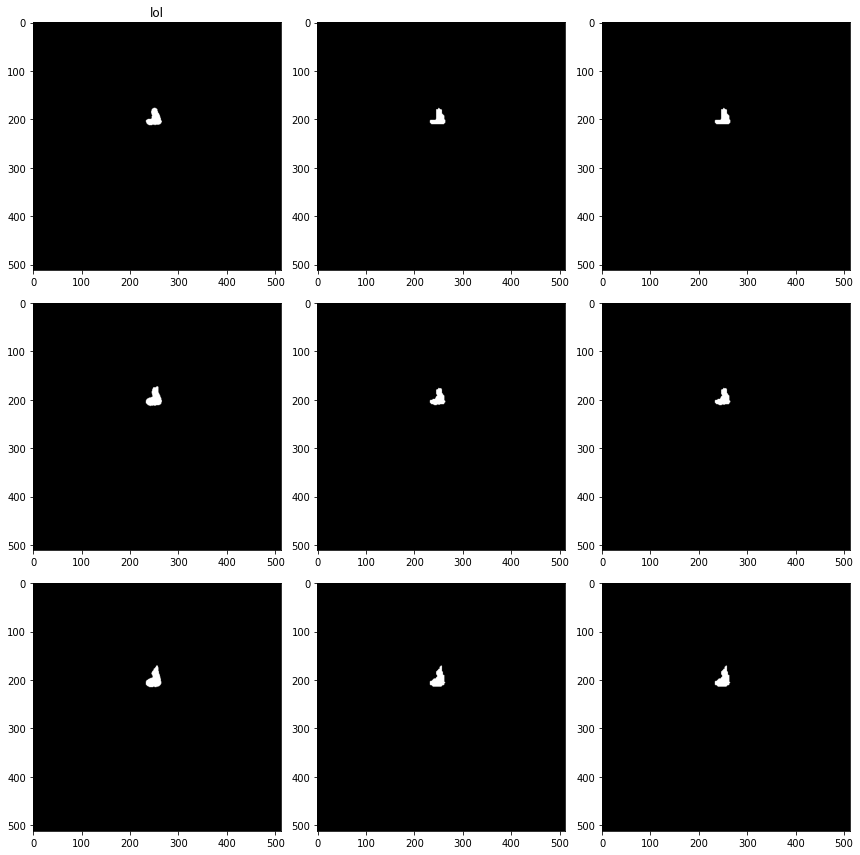

Dice  0.8599859517677358 S Dice 0.9293557622021449
VS-SEG-036


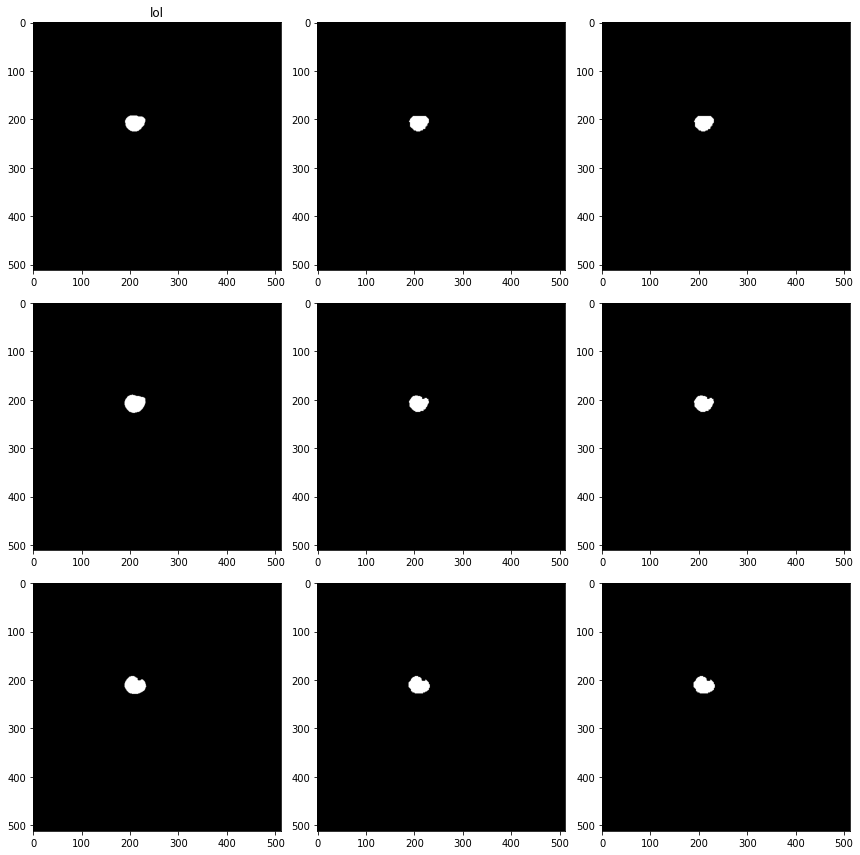

Dice  0.9078268426484167 S Dice 0.9344591817678559
VS-SEG-238


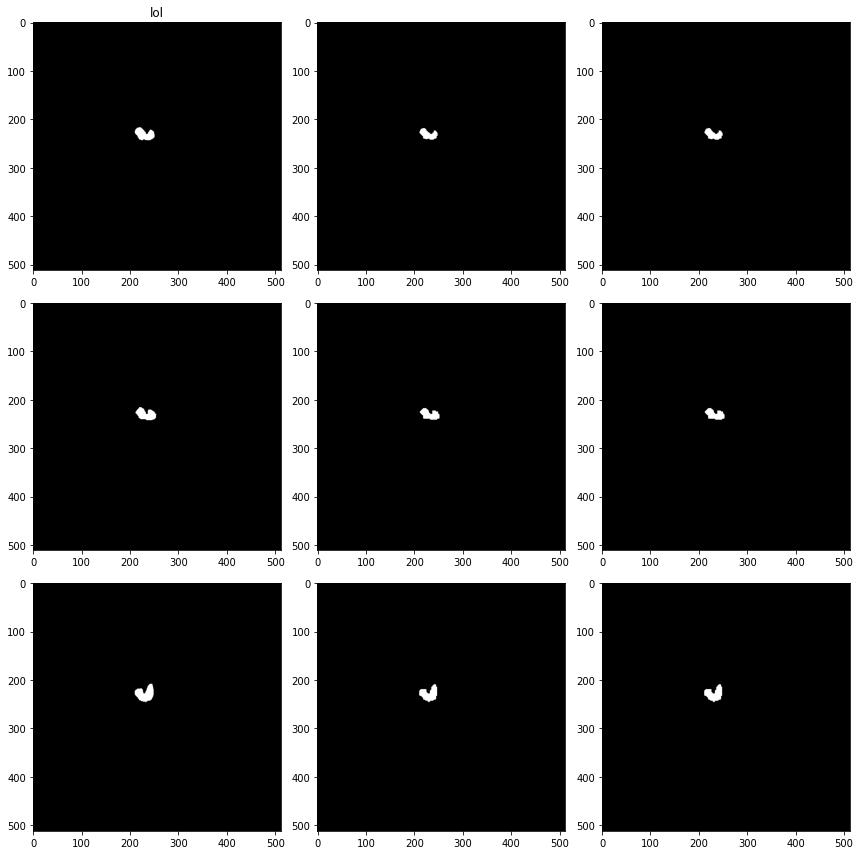

Dice  0.841343669250646 S Dice 0.9274186999341919
VS-SEG-112


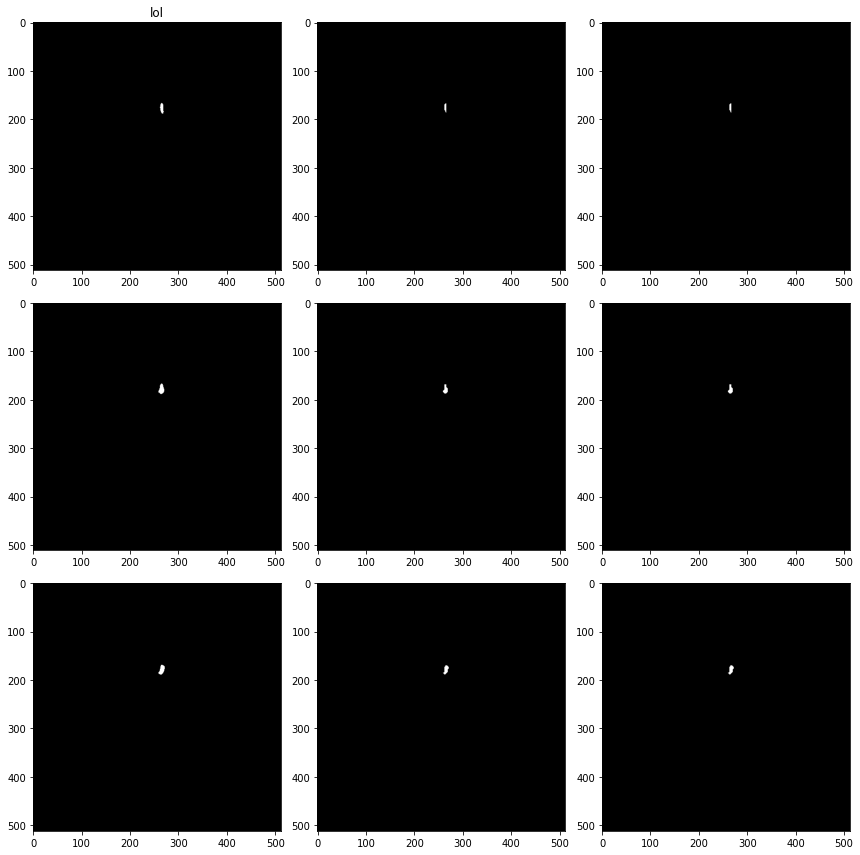

Dice  0.7878787878787878 S Dice 0.9793678332683508
VS-SEG-210


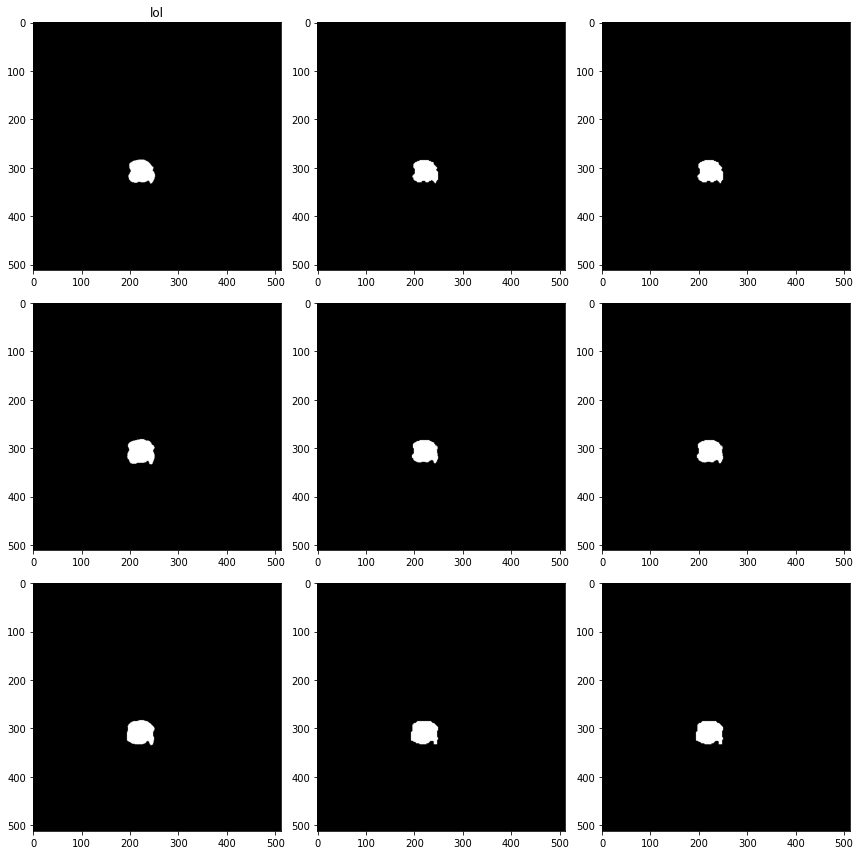

Dice  0.916972324108036 S Dice 0.9119181988305063
VS-SEG-221


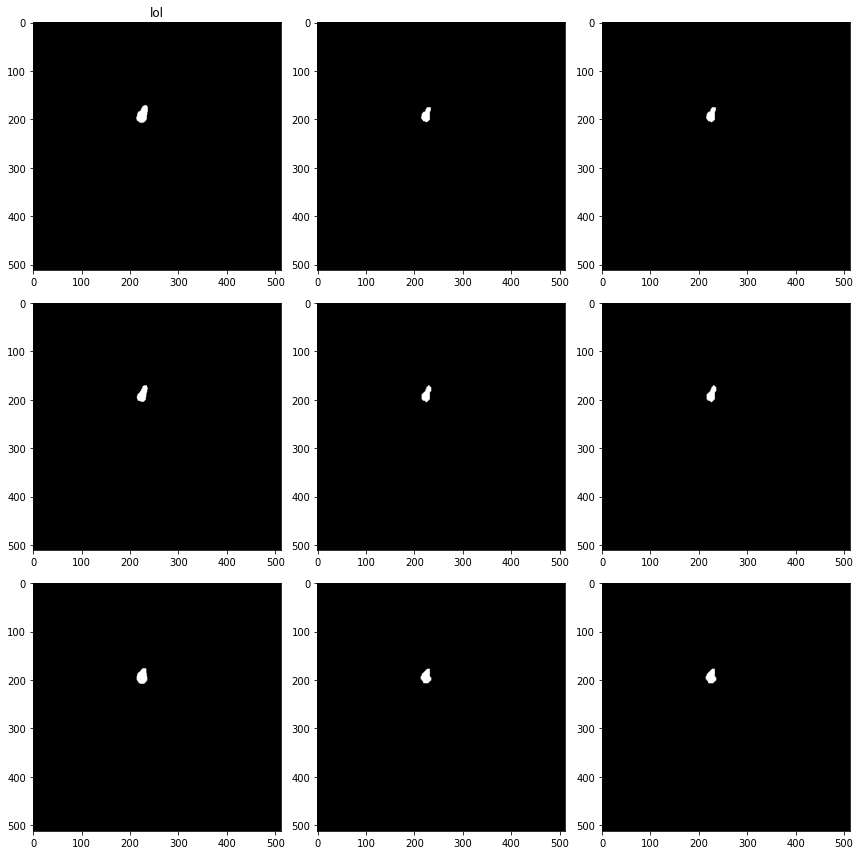

Dice  0.7952175019079115 S Dice 0.8737609769488216
VS-SEG-092


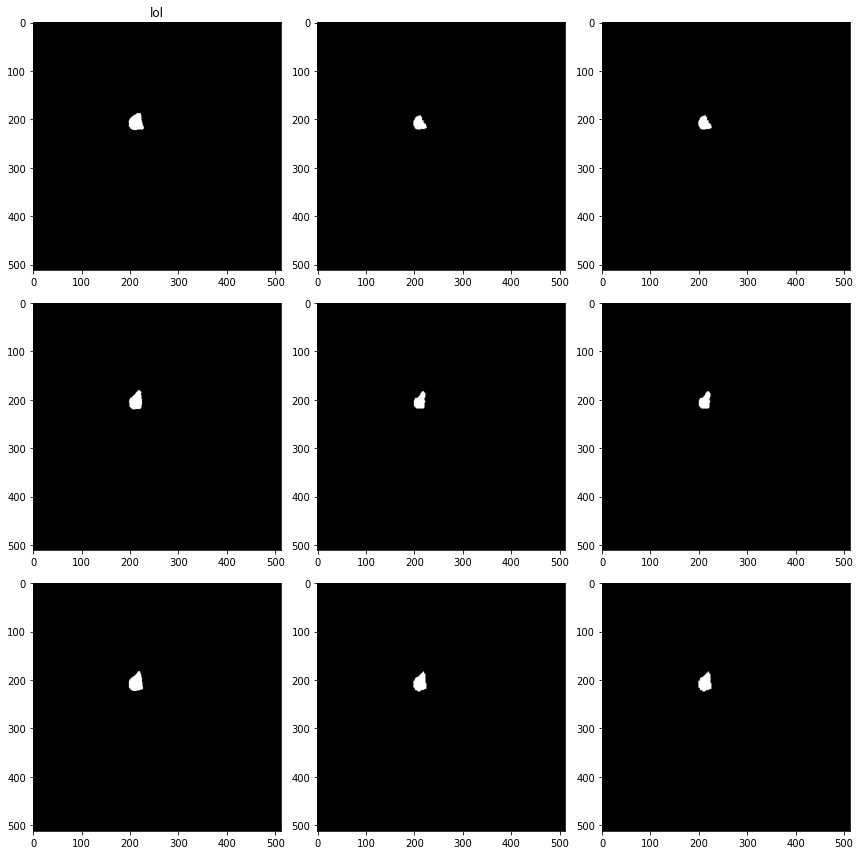

Dice  0.8608642726719415 S Dice 0.9188123151154953
VS-SEG-176


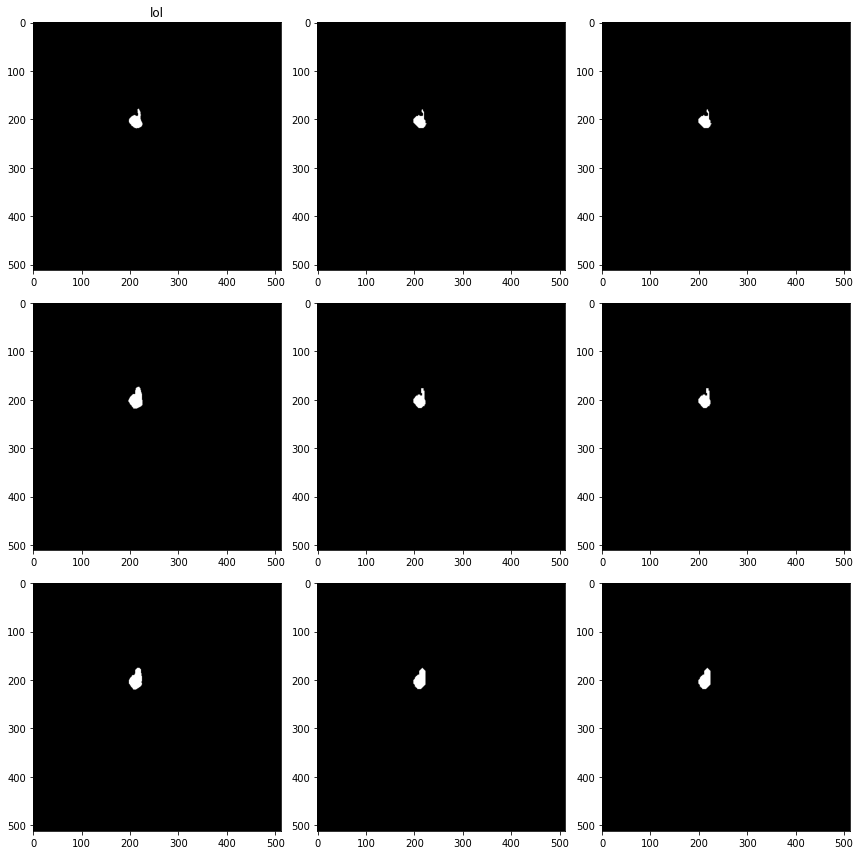

Dice  0.8360755636806825 S Dice 0.889211638738185
VS-SEG-200


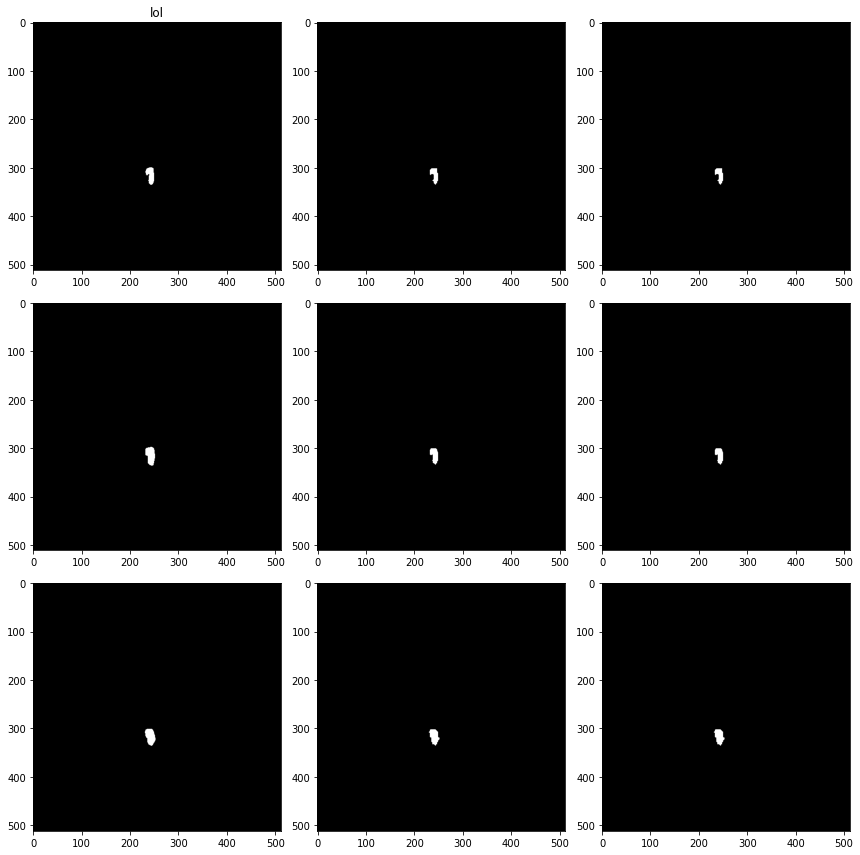

Dice  0.8545541249403911 S Dice 0.9394997080741431
VS-SEG-246


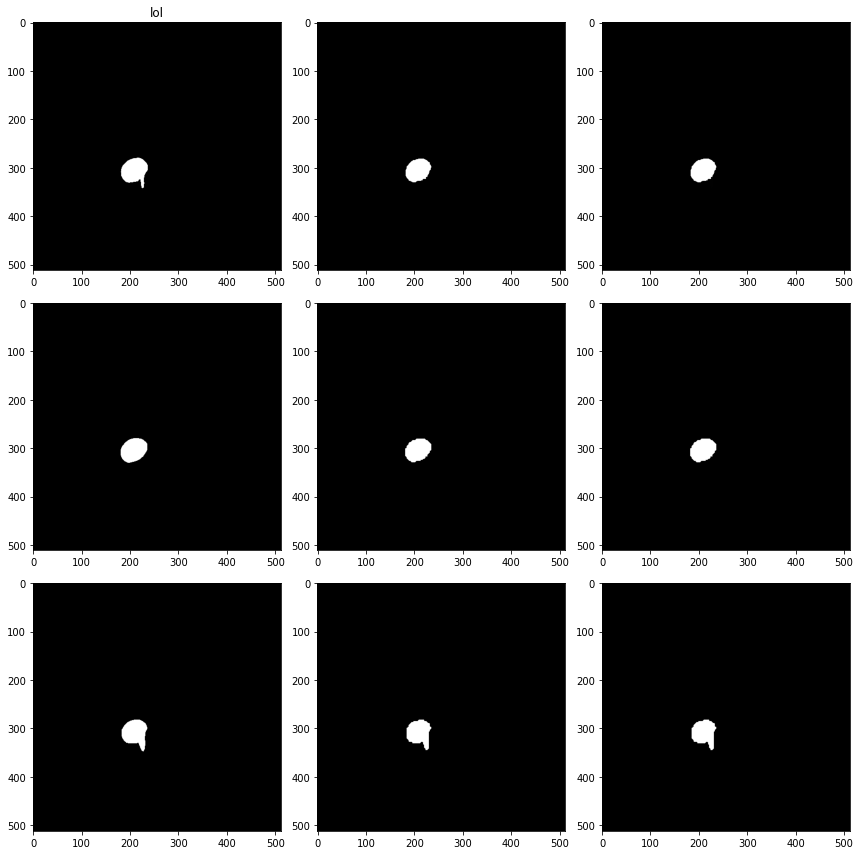

Dice  0.9243442546438906 S Dice 0.9247914759140538
VS-SEG-133


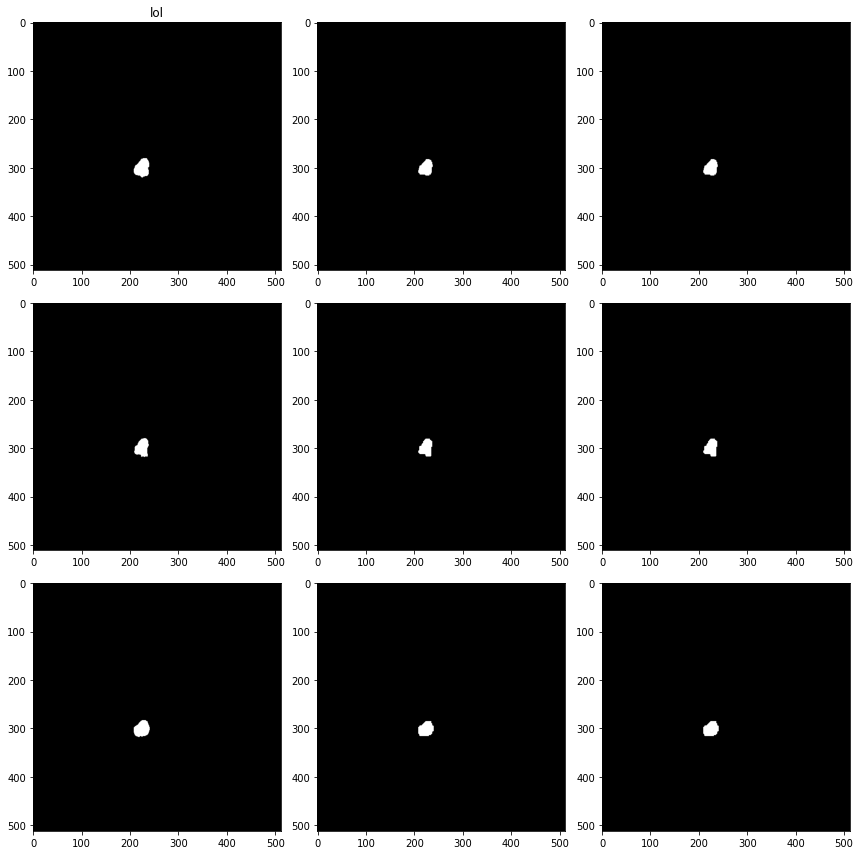

Dice  0.8642779587404995 S Dice 0.89444402355048
VS-SEG-005


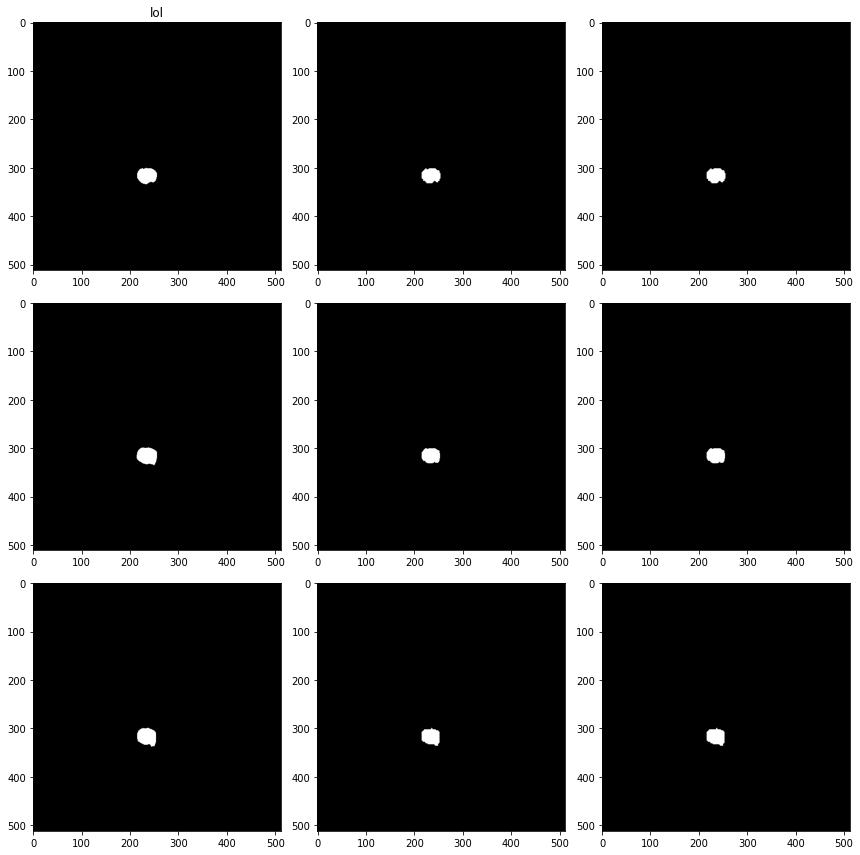

Dice  0.8790731354091238 S Dice 0.9012181710040886
VS-SEG-134


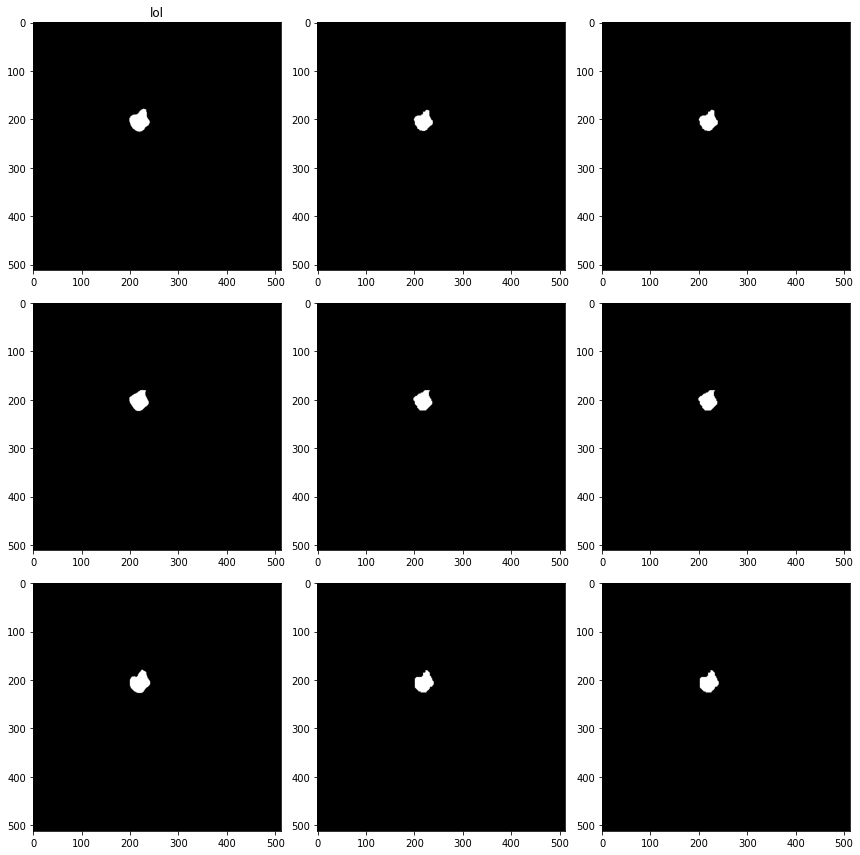

Dice  0.9072535181859941 S Dice 0.9436643985107865
VS-SEG-073


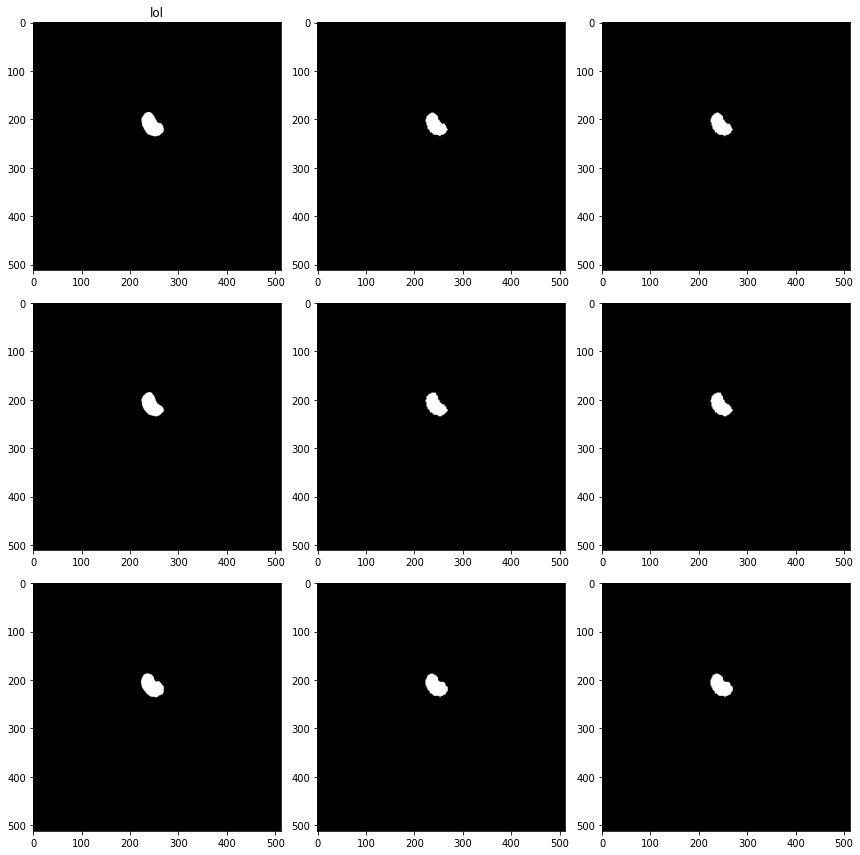

Dice  0.9168221097110663 S Dice 0.9311335097614153
VS-SEG-006


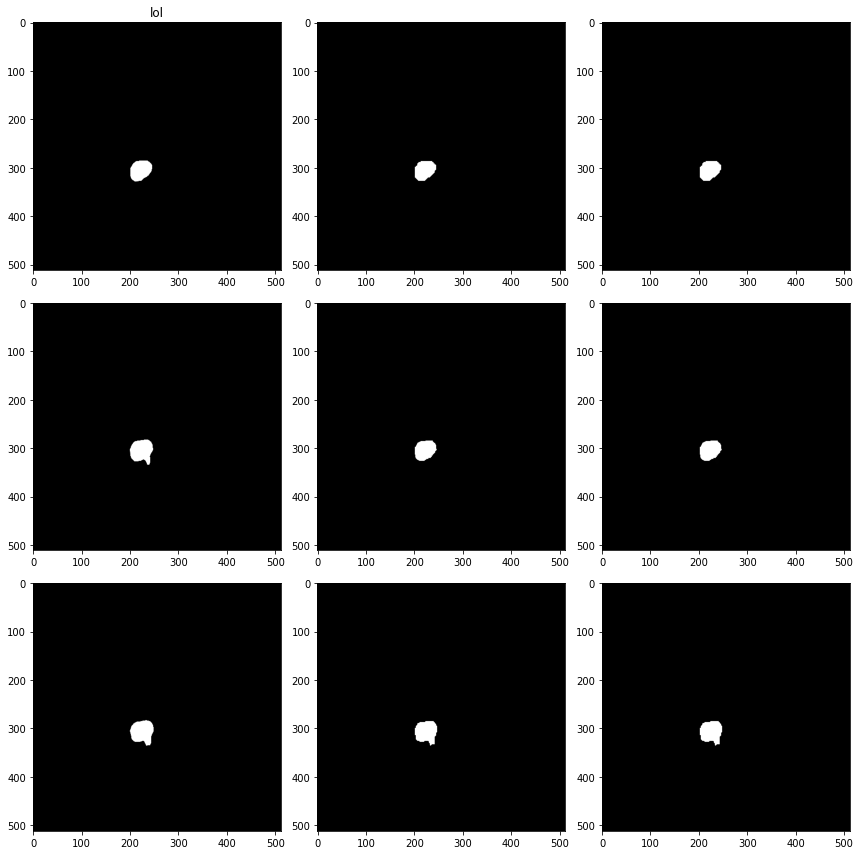

Dice  0.9073206501812848 S Dice 0.9074794771045162
VS-SEG-132


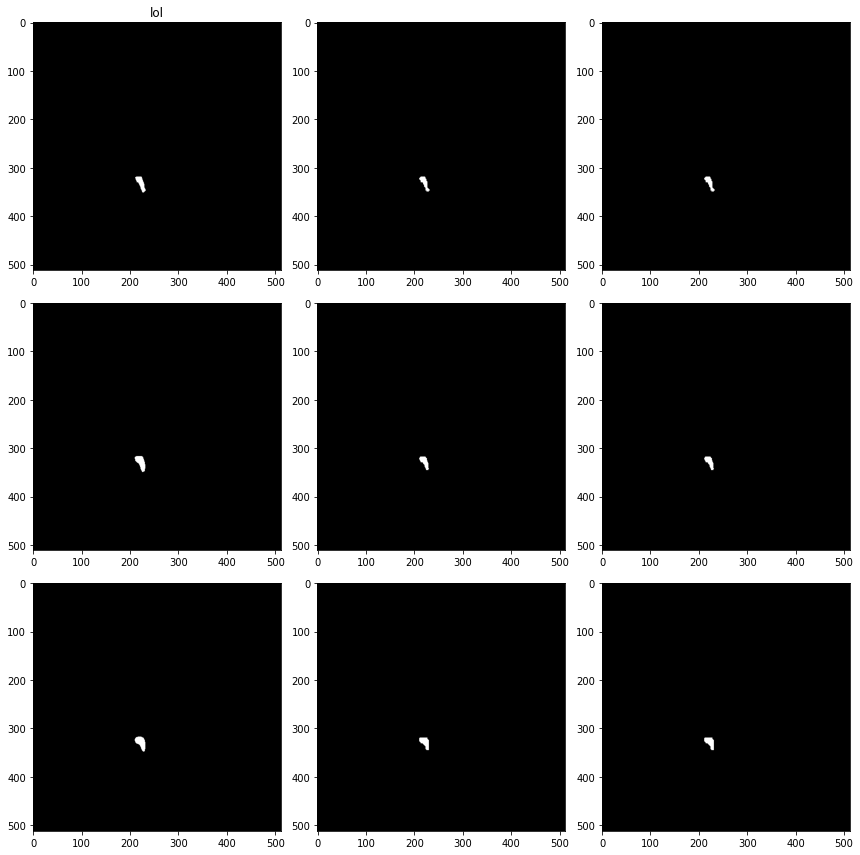

Dice  0.7808946171341926 S Dice 0.8852377157212323
VS-SEG-028


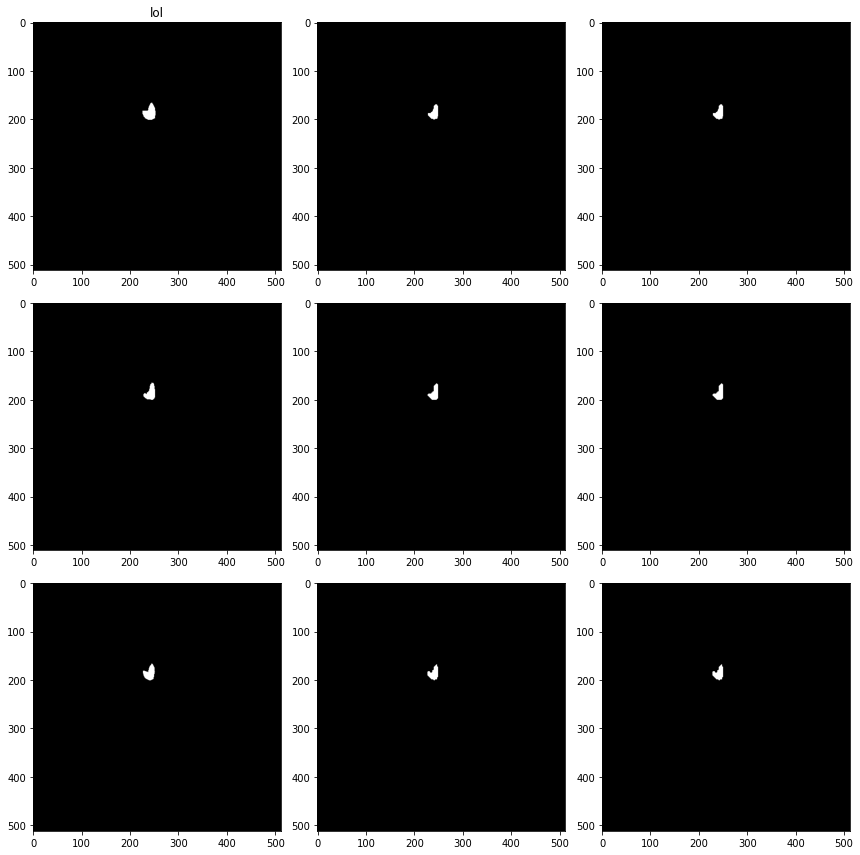

Dice  0.8307178631051753 S Dice 0.9076276806045457
VS-SEG-060


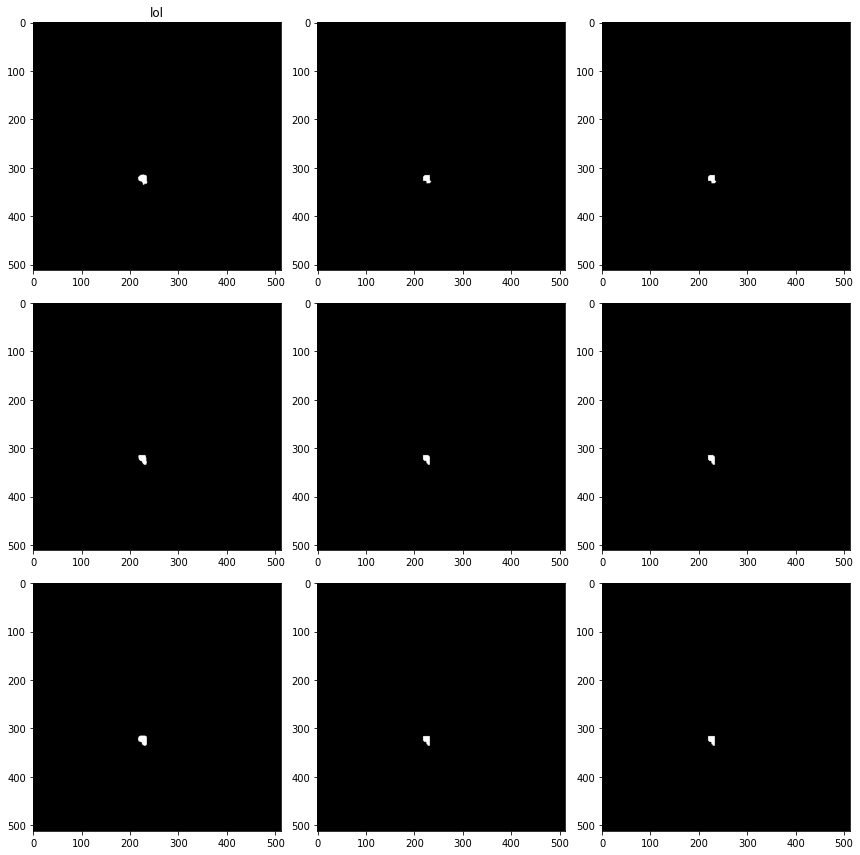

Dice  0.8574065528380249 S Dice 0.995957307066127
VS-SEG-170


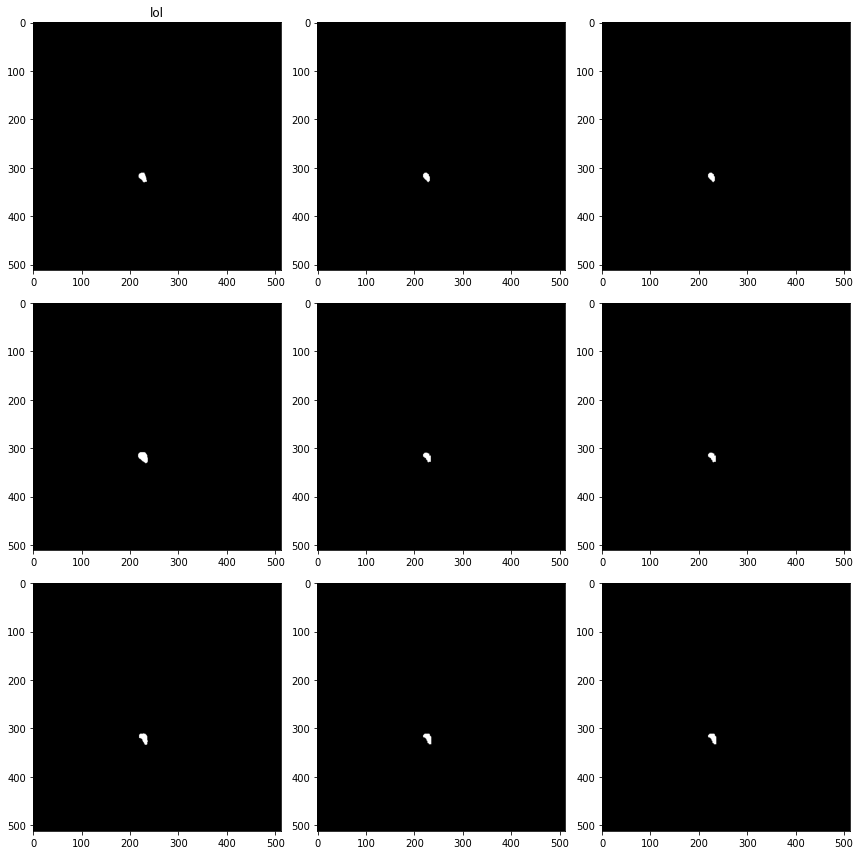

Dice  0.7947103274559194 S Dice 0.9002007468714399
VS-SEG-241


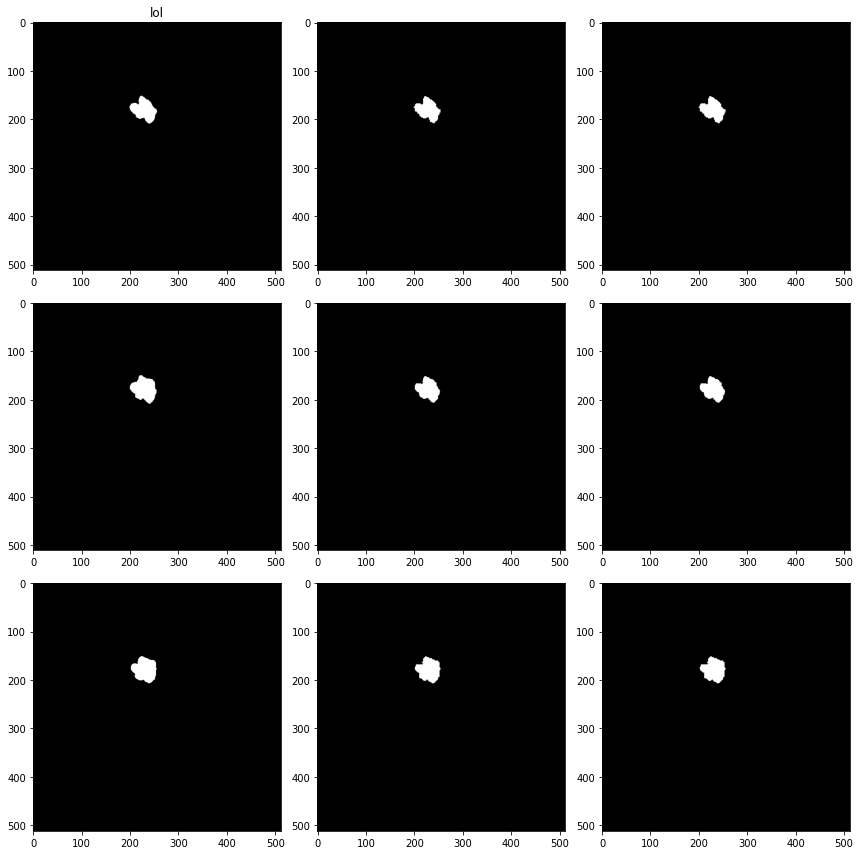

Dice  0.901840490797546 S Dice 0.9082766306100691
VS-SEG-013


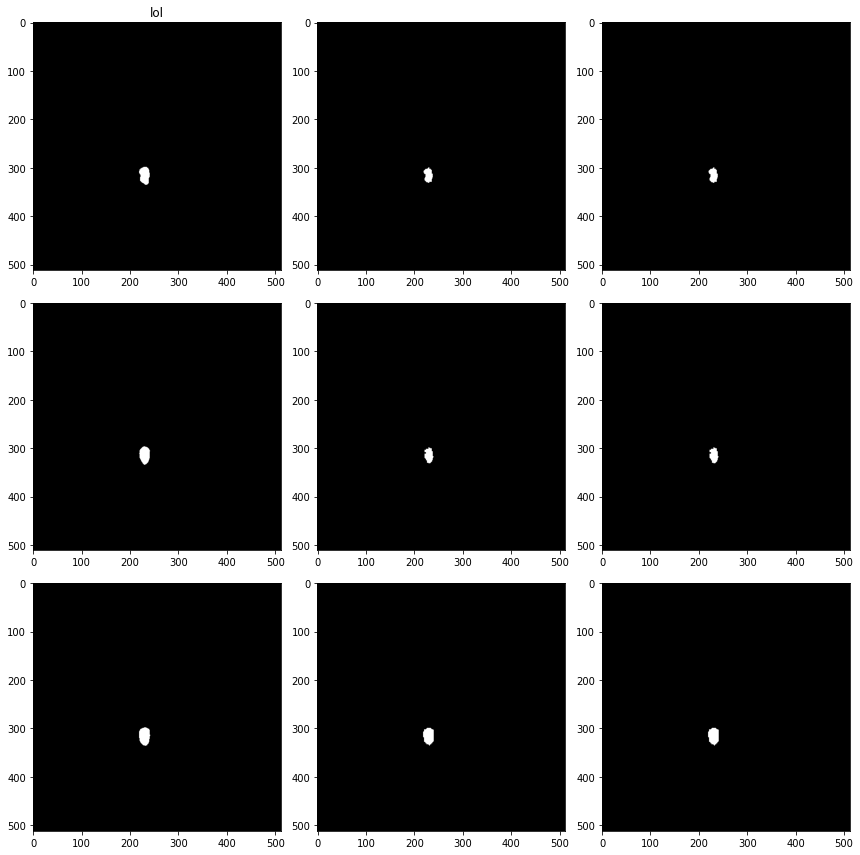

Dice  0.8777353944990965 S Dice 0.9352952513809609
VS-SEG-232


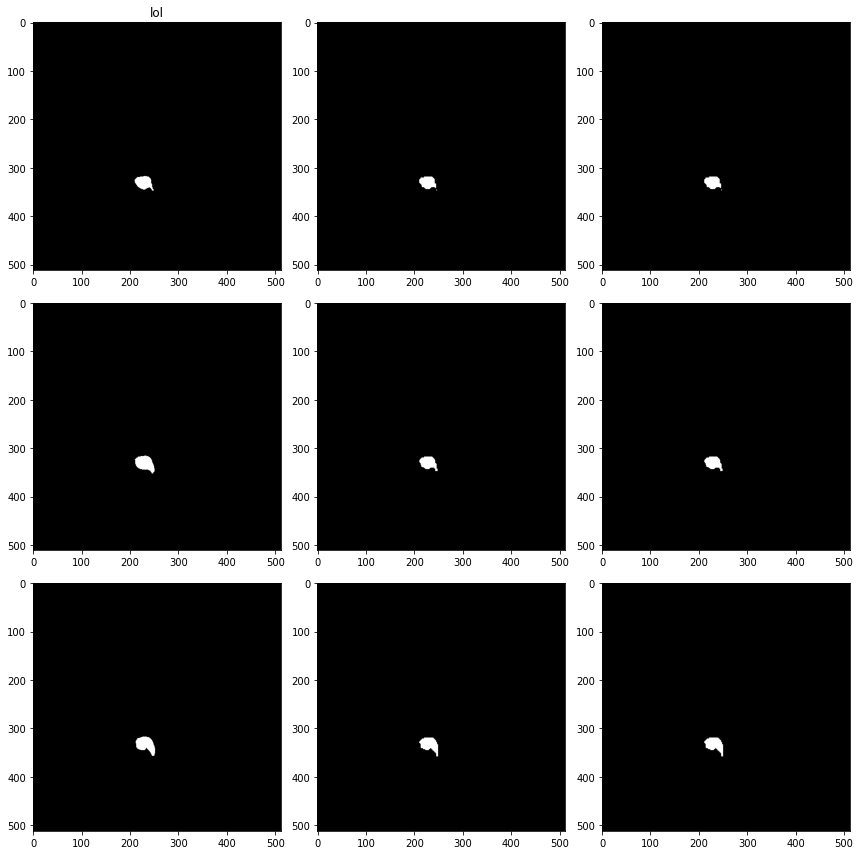

Dice  0.8388297872340426 S Dice 0.8811149885420073
VS-SEG-143


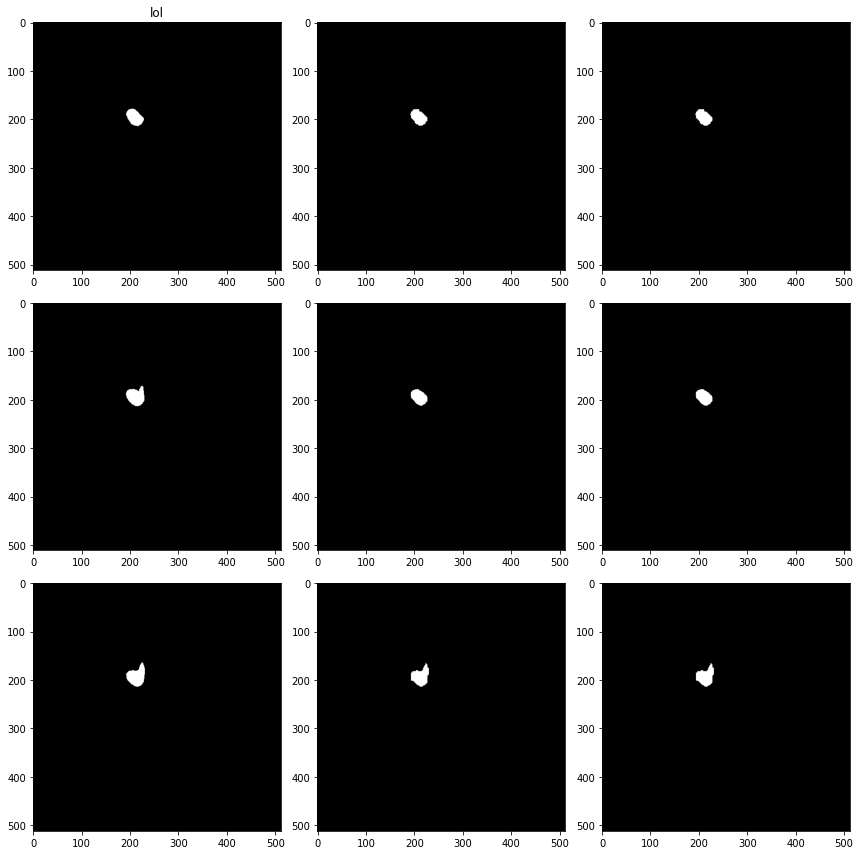

Dice  0.8608745031232254 S Dice 0.8787730972901685
VS-SEG-053


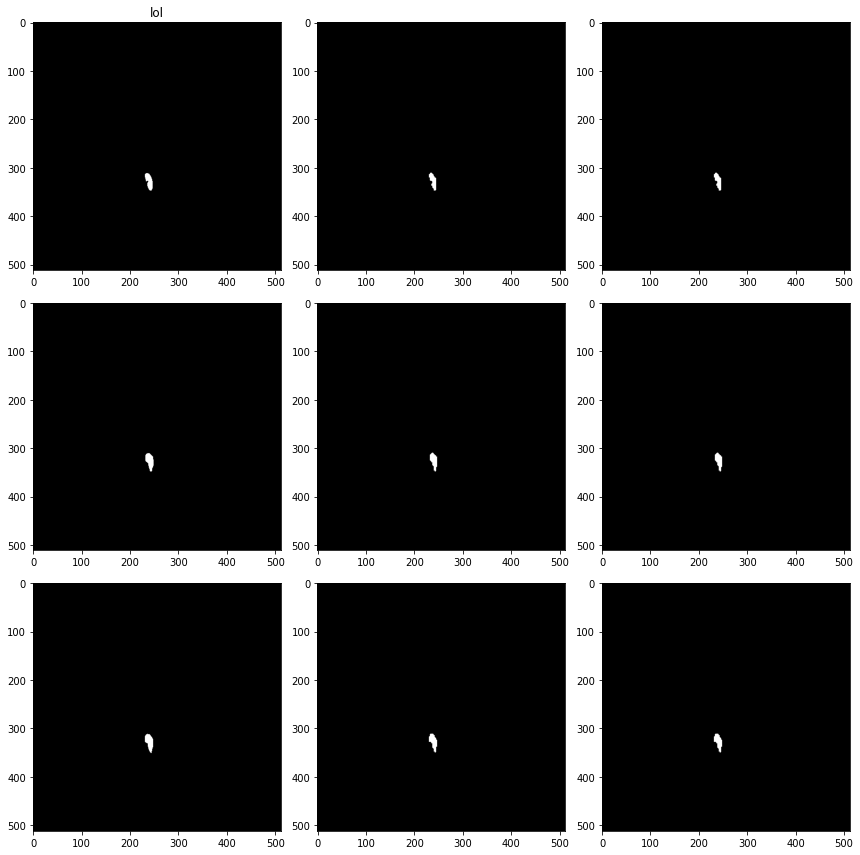

Dice  0.8971913089560148 S Dice 0.9915003099004442
VS-SEG-248


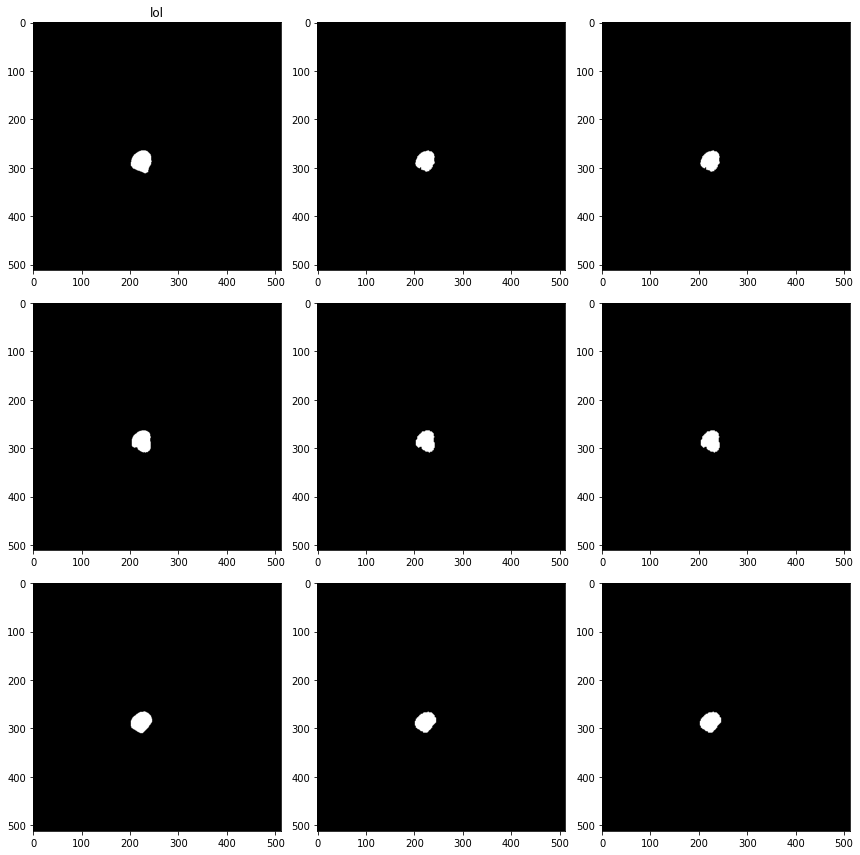

Dice  0.9082251516214727 S Dice 0.9133103382700248
VS-SEG-187


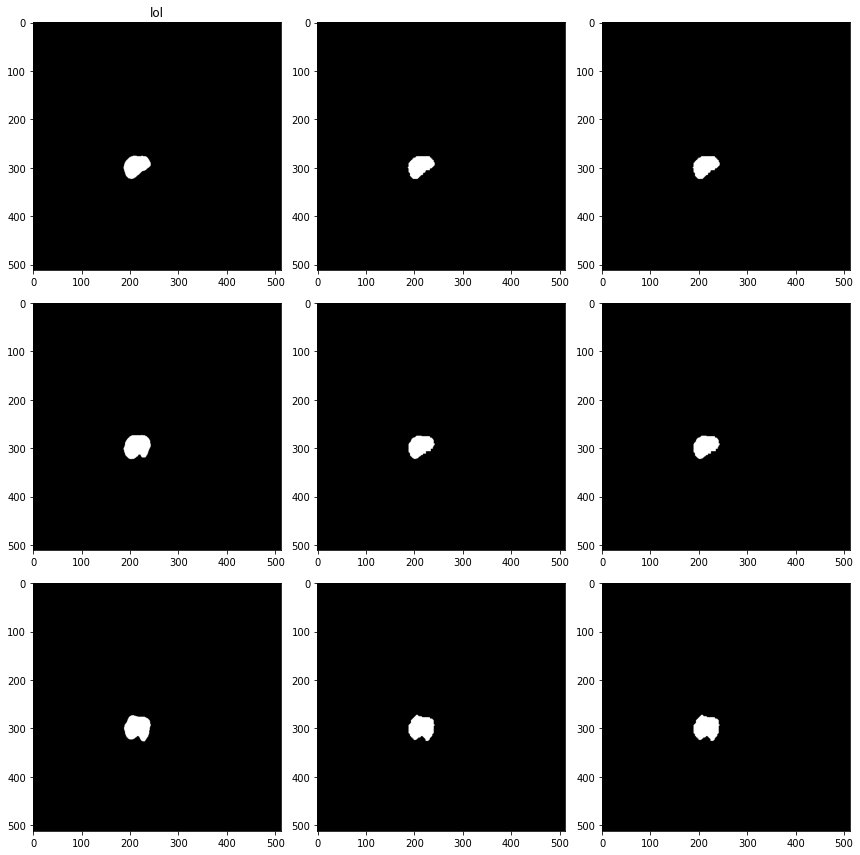

Dice  0.9099013269819667 S Dice 0.9029720916709845
VS-SEG-243


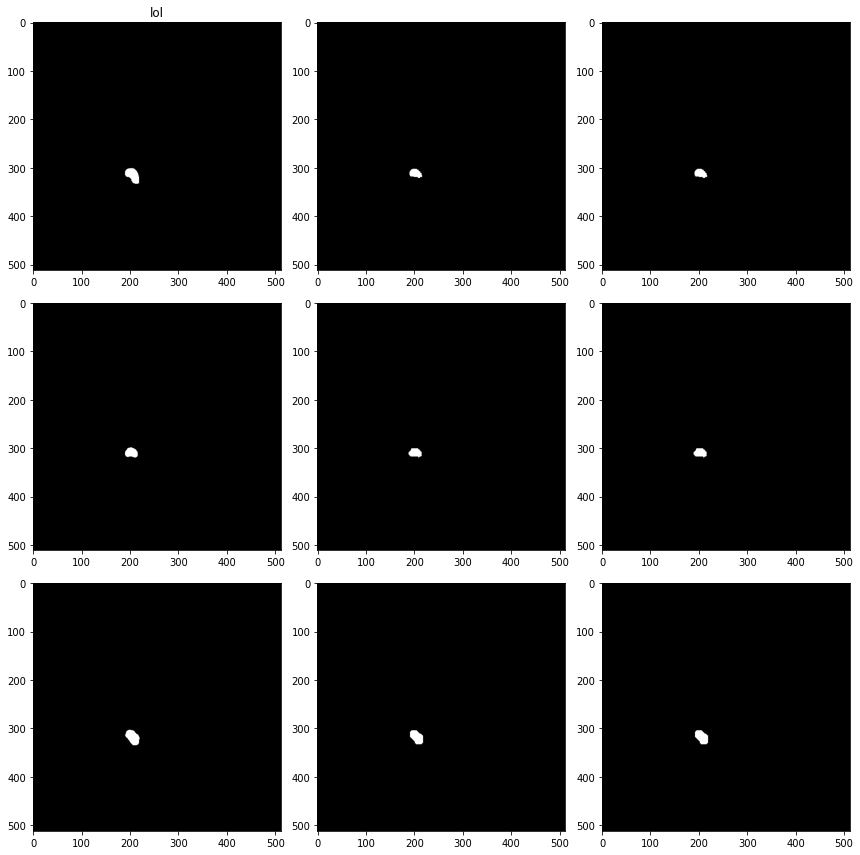

Dice  0.7921502426672293 S Dice 0.8657180131071579
VS-SEG-144


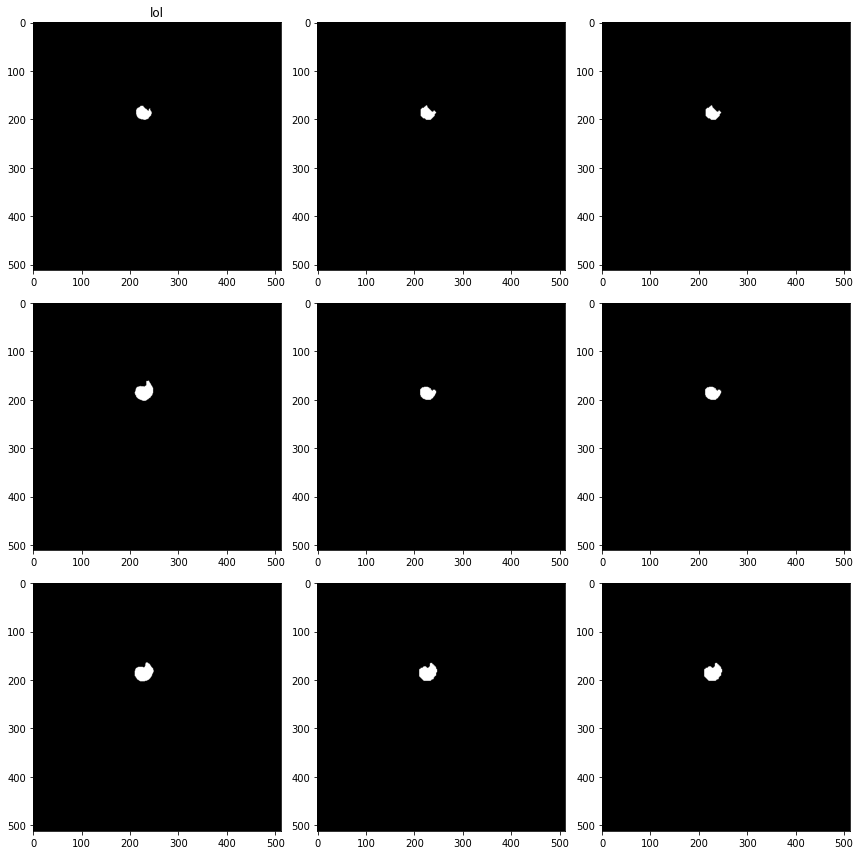

Dice  0.8194492453047586 S Dice 0.8515129140081664
VS-SEG-041


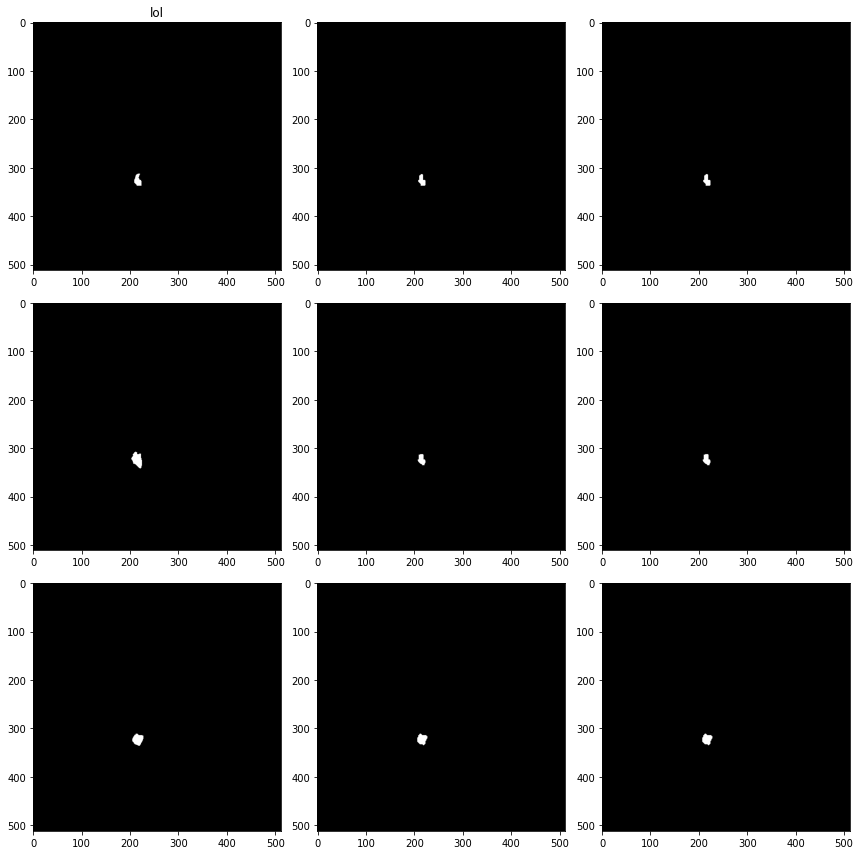

Dice  0.8068857589984351 S Dice 0.8909277429727266
VS-SEG-089


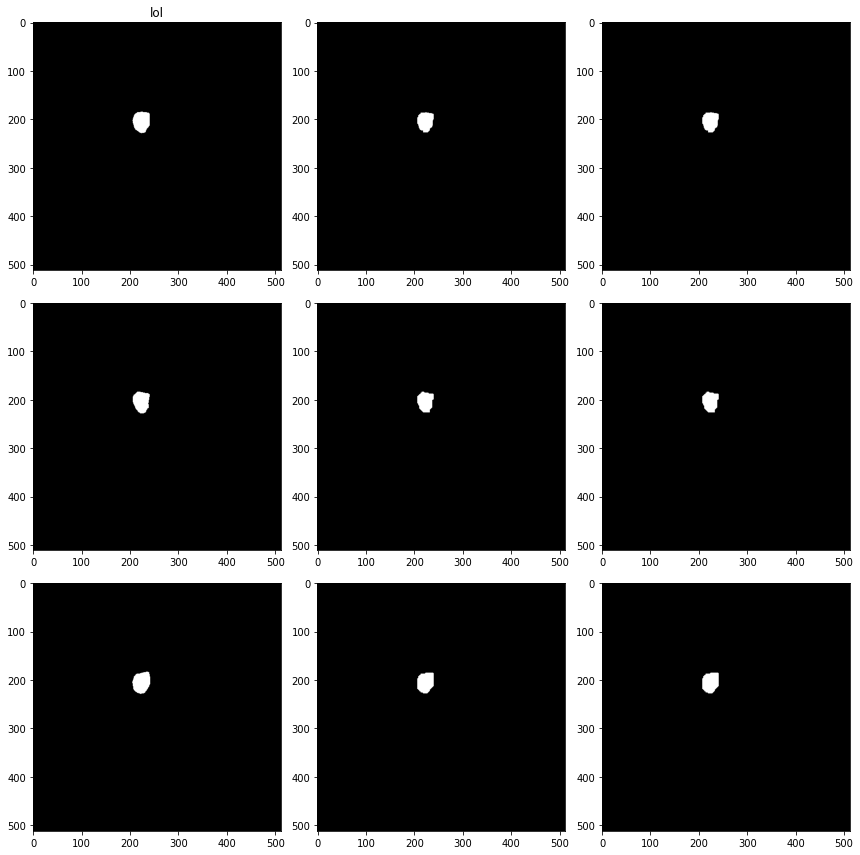

Dice  0.9161849710982659 S Dice 0.9564322313403701
VS-SEG-185


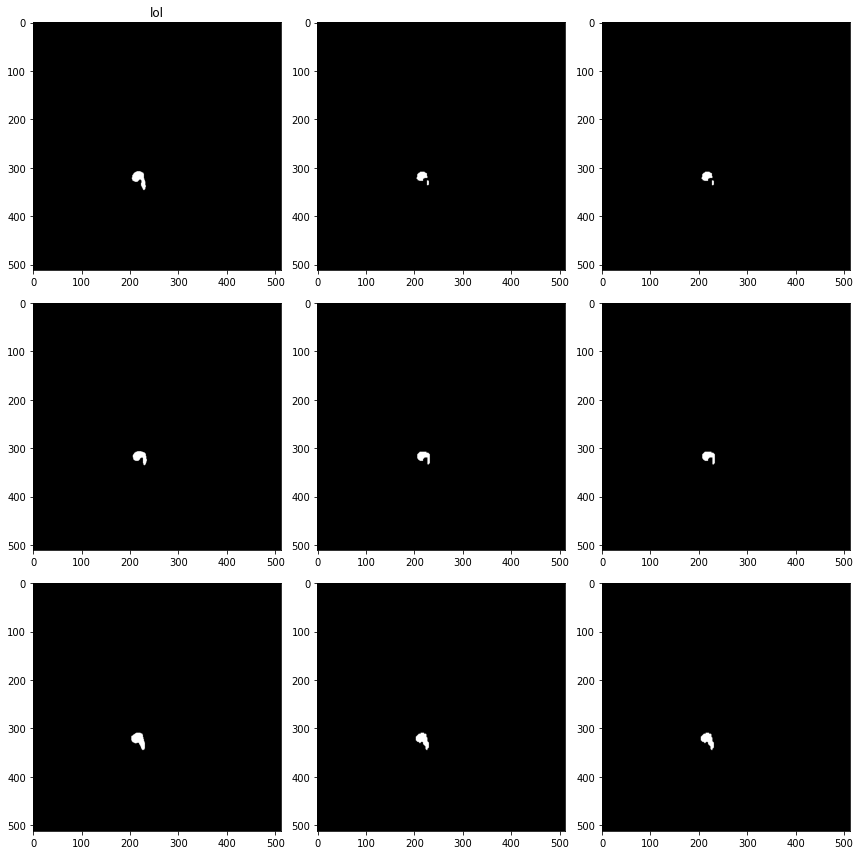

Dice  0.7868409193330329 S Dice 0.8785293021360712
VS-SEG-088


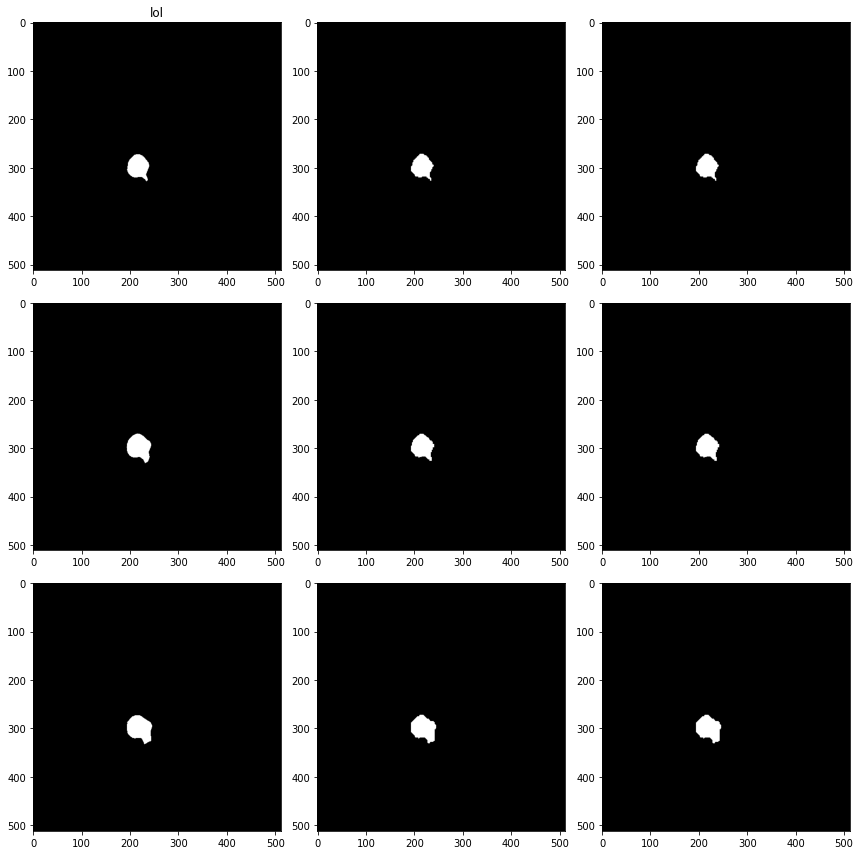

Dice  0.9023950553695597 S Dice 0.8790531219782142
VS-SEG-023


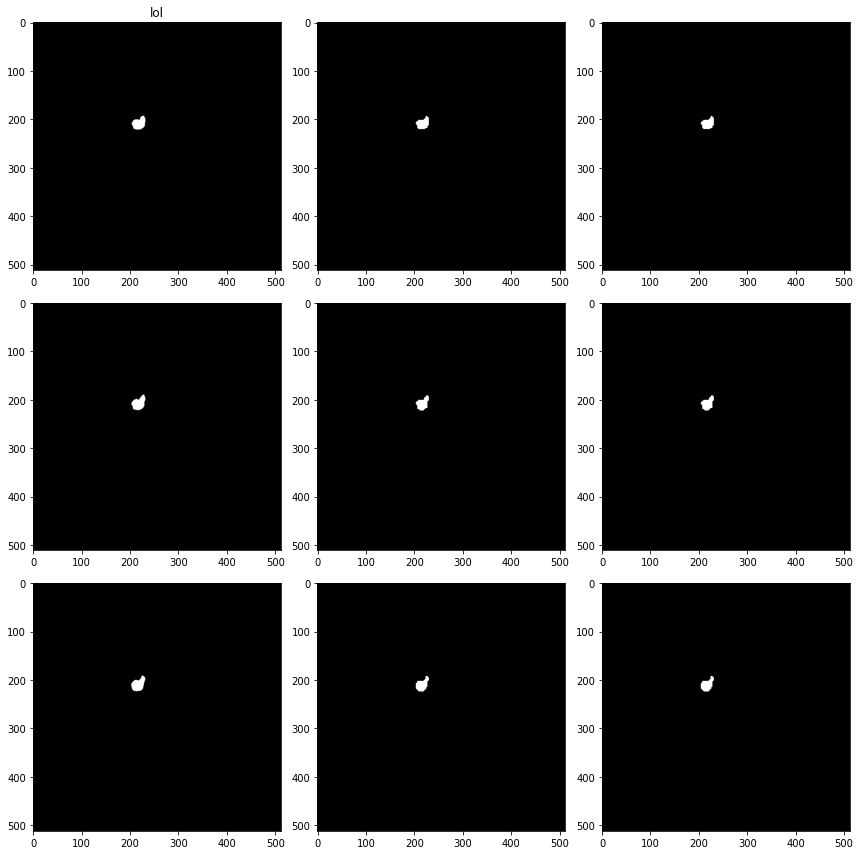

Dice  0.9133151738503444 S Dice 0.9983627125698257
VS-SEG-040


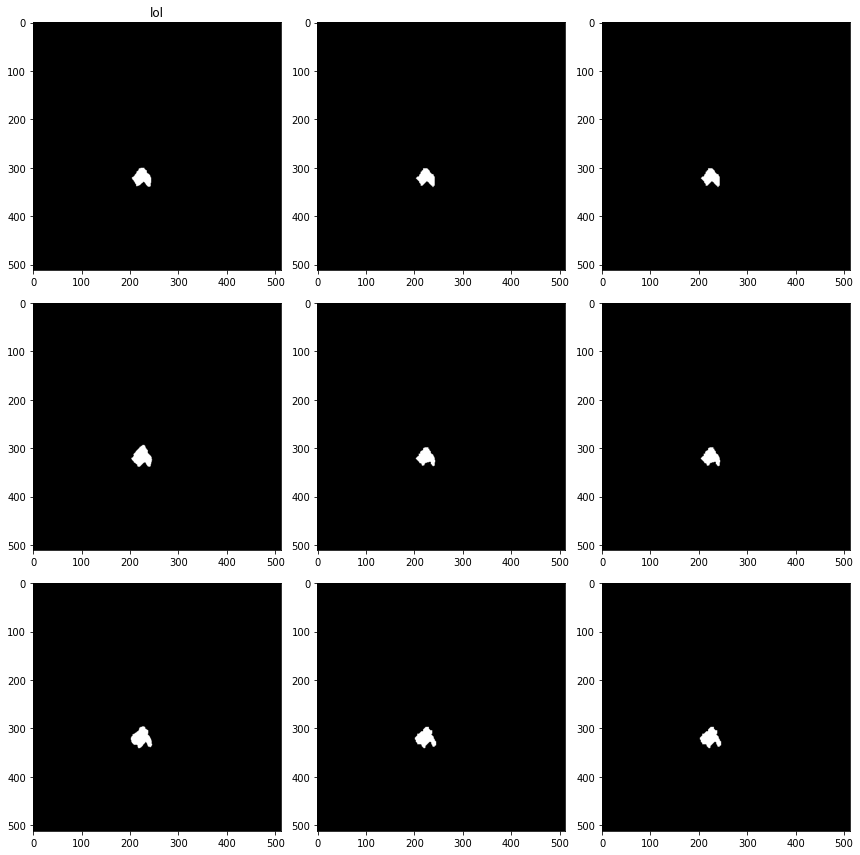

Dice  0.8527440970006381 S Dice 0.9065979766687418
VS-SEG-205


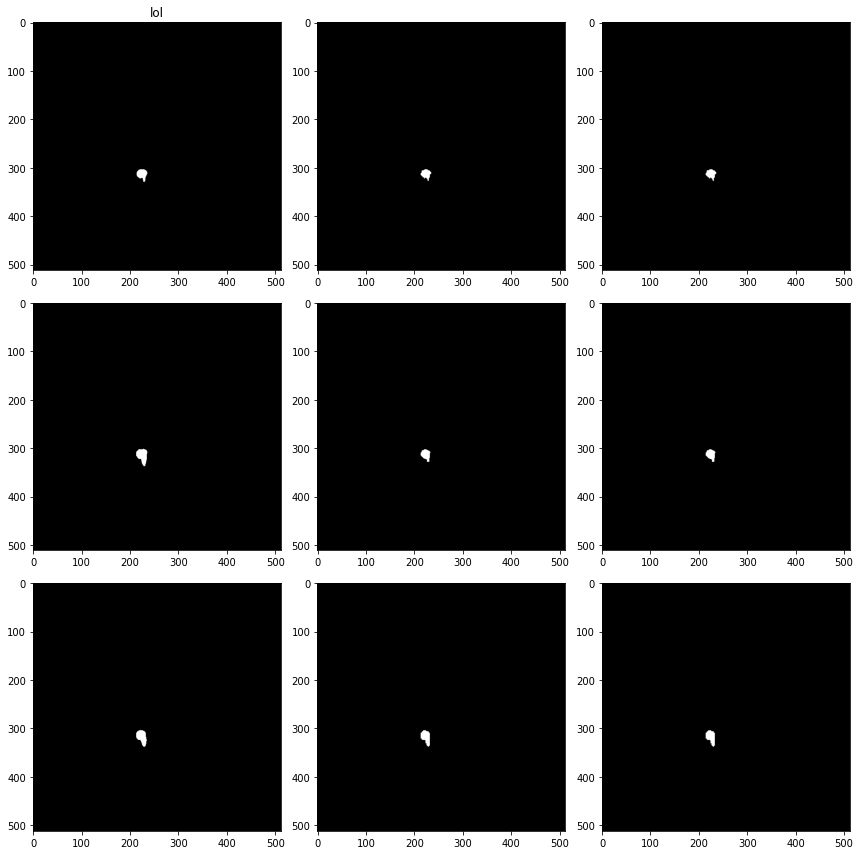

Dice  0.768 S Dice 0.8365652862812689
VS-SEG-165


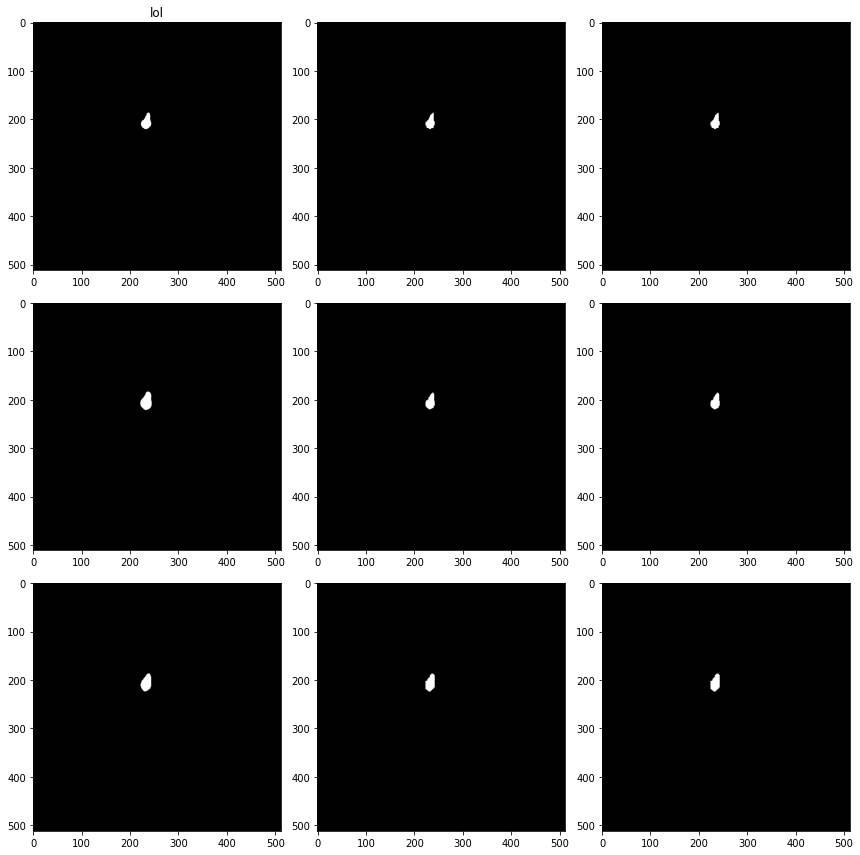

Dice  0.813977929584866 S Dice 0.8956298645446212
VS-SEG-046


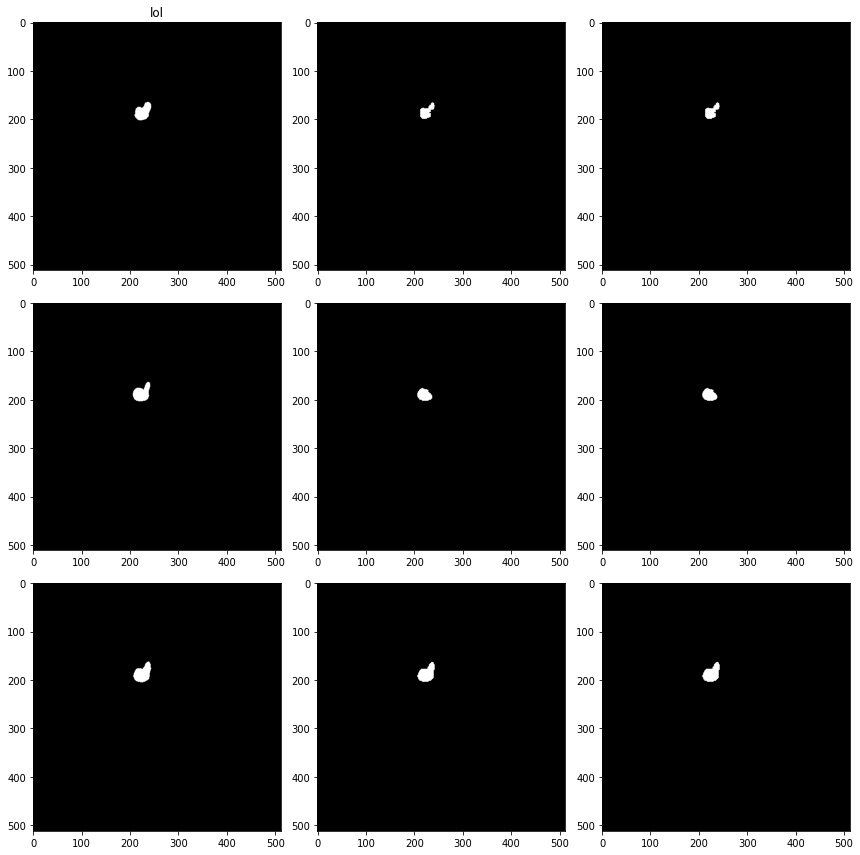

Dice  0.8598091198303287 S Dice 0.9004891085319021
VS-SEG-109


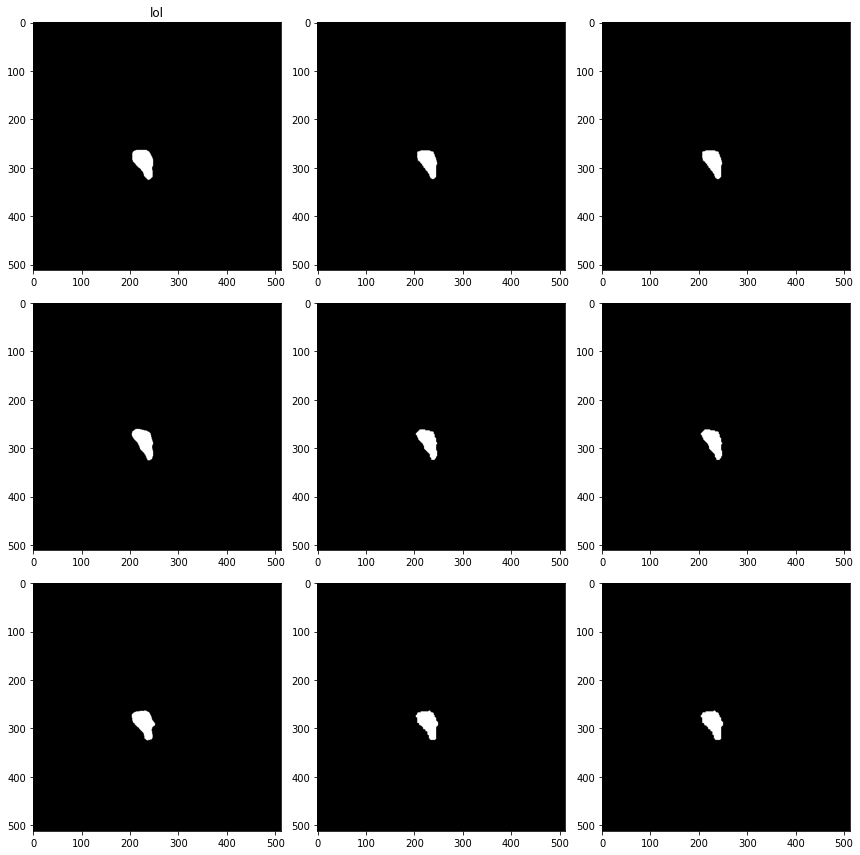

Dice  0.9152287620994408 S Dice 0.9317725791821442
VS-SEG-055


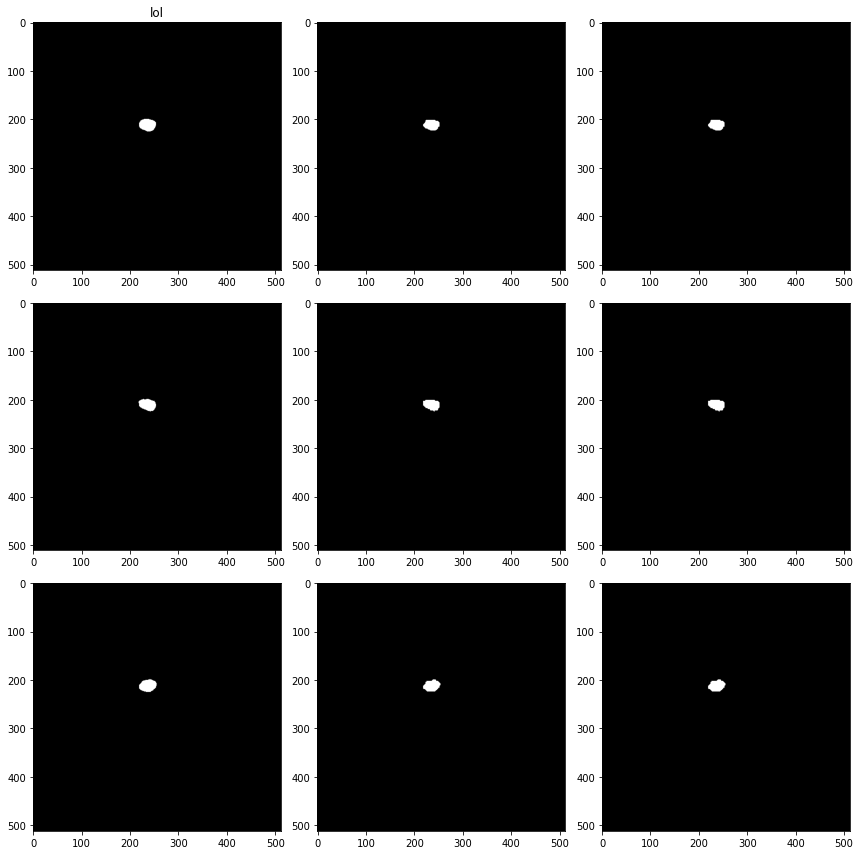

Dice  0.8386180785612872 S Dice 0.8827570885797021
VS-SEG-030


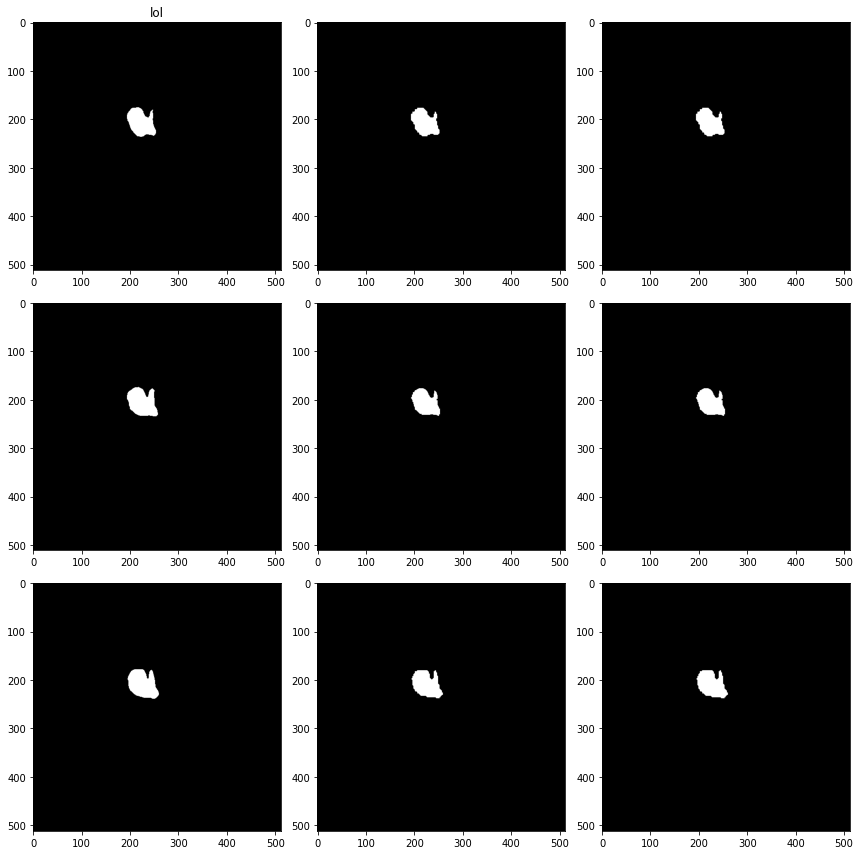

Dice  0.9314592490922042 S Dice 0.9344243334316605
VS-SEG-121


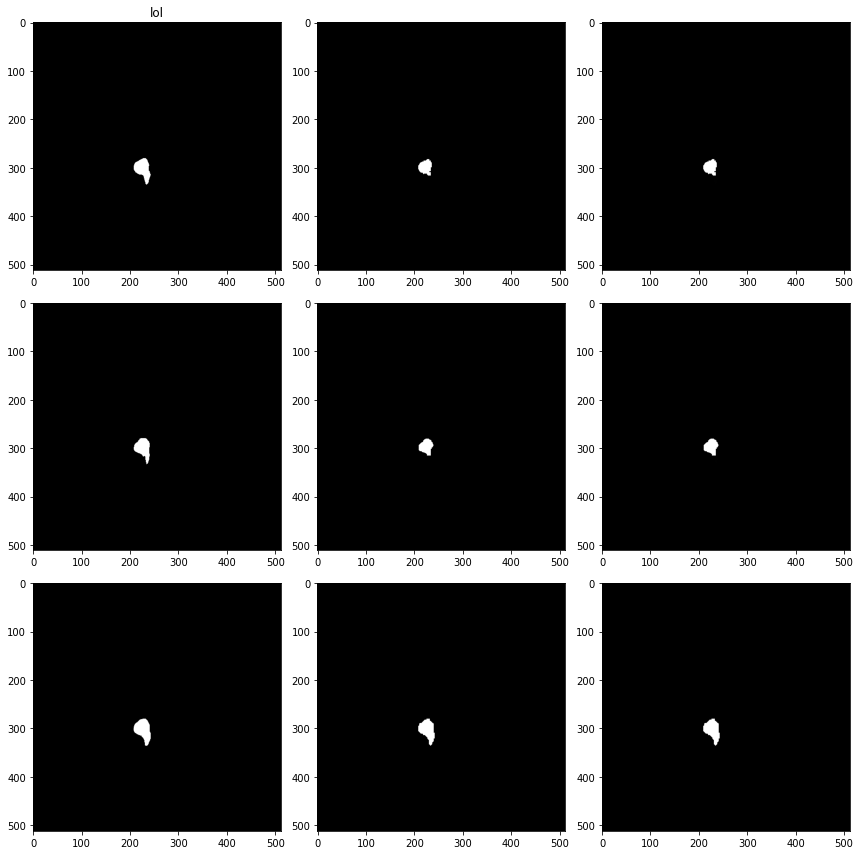

Dice  0.8435754189944135 S Dice 0.8712035719698682
VS-SEG-250


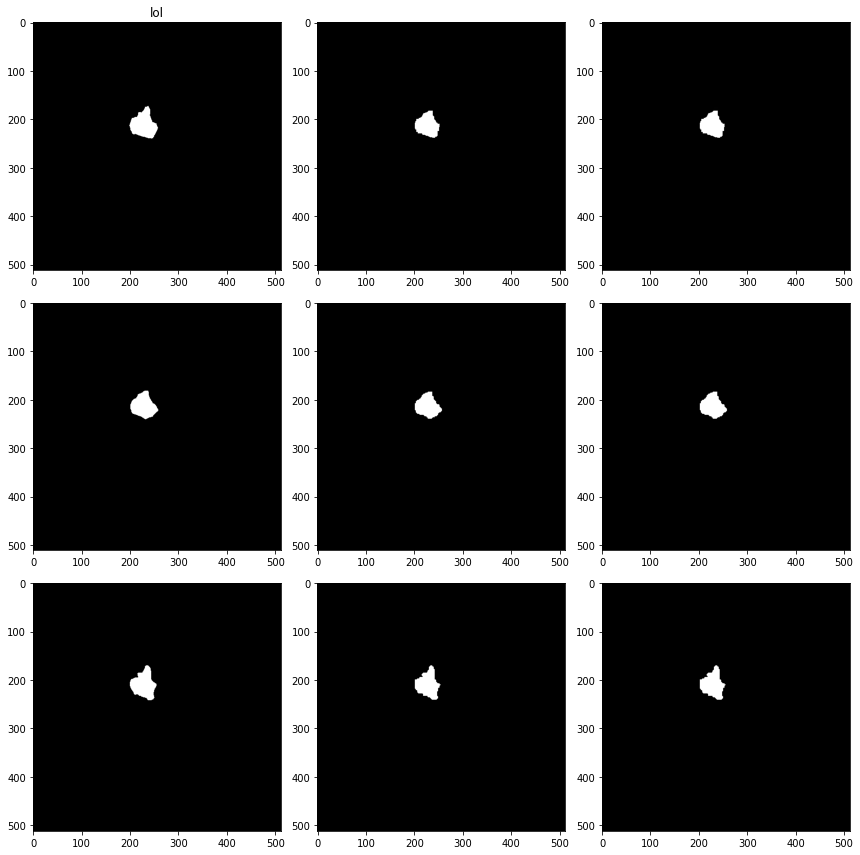

Dice  0.9006143838091796 S Dice 0.9187649786465261
VS-SEG-026


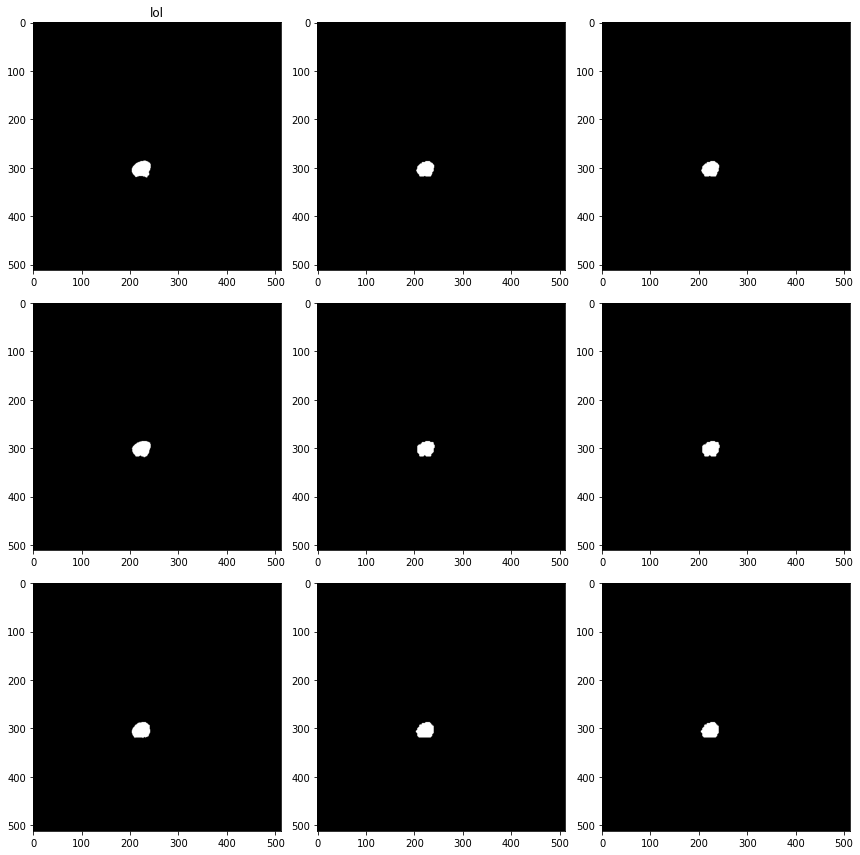

Dice  0.9128863409770688 S Dice 0.9481978364853103
VS-SEG-029


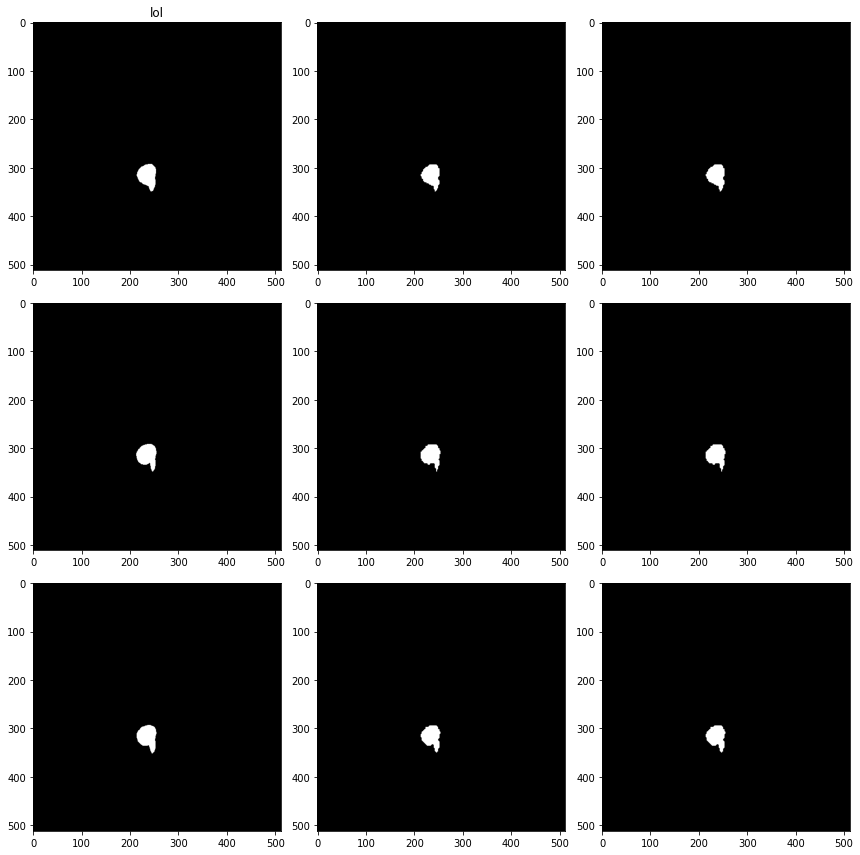

Dice  0.9500396510705789 S Dice 0.9986352505188707
VS-SEG-024


KeyboardInterrupt: 

In [508]:
# With resample
path = '/anvar/public_datasets/preproc_study/schw/orig'

dices = []
s_dices = []
for image in os.listdir(path):
    print(image)
    try:
        img = ants.image_read(path + '/' + image +'/' + 'T1_SEG.nii.gz')
        # resample
        img_res = ants.resample_image(img, (1, 1, 1), False, 0)
        # apply inverse transform
#         img_res_reverse = ants.resample_image(img_res, img.spacing, False, 0)
        channels = np.unique(img.numpy())[1:]
#         img_res = resample_by_channels(img, channels = channels, interpolator = 0)
        img_res_reverse = invert_resample_by_channels(img_res, img, channels = channels, interpolator = 0)
#         img_res_reverse = invert_registrate_by_channels(img_res, img, channels = channels)
        # round inverse labels
        pred = np.round(img_res_reverse.numpy(), 0)
        # calculate metrics
        distances = metrics.compute_surface_distances((img[:,:,:]==1), (pred[:,:,:]==1), spacing)
        dice = metrics.compute_dice_coefficient((img[:,:,:]==1), (pred[:,:,:]==1))
        s_dice = metrics.compute_surface_dice_at_tolerance(distances, 1)

        dices.append(dice)
        s_dices.append(s_dice)
    #     plot_qc(img[:,:,:], pred[:,:,:])
        plot_qc(img[:,:,:]==1, pred[:,:,:]==1)
        plt.show()
        print('Dice ',dice, 'S Dice', s_dice)
    except Exception as e:
        print(' For patient there is size mismatch')
        pass 

In [509]:
# schw resample not func and invert resample by channels
np.array(dices).mean(), np.array(dices).std(), np.array(s_dices).mean(), np.array(s_dices).std()

(0.865514692798645,
 0.04810014868900226,
 0.9217158023527077,
 0.037464316114865046)

#### BGPD

In [512]:
# With resample
path = '/anvar/public_datasets/preproc_study/bgpd/orig'

dices = []
s_dices = []
for image in os.listdir(path):
    print(image)
    try:
        img = ants.image_read(path + '/' + image +'/' + 'mask_GTV_FLAIR.nii.gz')
        # resample
        img_res = ants.resample_image(img, (1, 1, 1), False, 0)
        # apply inverse transform
#         img_res_reverse = ants.resample_image(img_res, img.spacing, False, 0)
#         channels = np.unique(img.numpy())[1:]
        img_res_reverse = ants.resample_image(img_res, img.shape, True, 0)
#         img_res = resample_by_channels(img, channels = channels, interpolator = 0)
#         img_res_reverse = invert_resample_by_channels(img_res, img, channels = channels, interpolator = 0)
        # round inverse labels
        pred = np.round(img_res_reverse.numpy(), 0)
        # calculate metrics
        distances = metrics.compute_surface_distances((img[:,:,:]==1), (pred[:,:,:]==1), spacing)
        dice = metrics.compute_dice_coefficient((img[:,:,:]==1), (pred[:,:,:]==1))
        s_dice = metrics.compute_surface_dice_at_tolerance(distances, 1)

        dices.append(dice)
        s_dices.append(s_dice)
    #     plot_qc(img[:,:,:], pred[:,:,:])
    #     plot_qc(img[:,:,:]==2, pred[:,:,:]==2)
        plt.show()
        print('Dice ',dice, 'S Dice', s_dice)
    except Exception as e:
        print(' For patient there is size mismatch')
        pass 

1360_18
Dice  0.9974184700401347 S Dice 1.0
Patient_98817
Dice  0.9184720743943312 S Dice 0.7316542665296017
Patient_110816
Dice  0.972832475208185 S Dice 0.981460794519784
1421_18
Dice  0.8770120611576918 S Dice 0.8481297982978171
1357_19_4
Dice  0.9765165014330873 S Dice 0.9993244993973127
Patient_49617
Dice  0.9379937188250508 S Dice 0.9010973141363503
Patient_2914
Dice  0.9612926013394186 S Dice 0.9253513371293345
Patient_102117
Dice  0.8921910004811747 S Dice 0.7945915170050286
Patient_24117
Dice  0.8784322515570214 S Dice 0.7942449463370856
1470_18_4
Dice  0.9951703420813637 S Dice 1.0
Patient_92114
Dice  0.8144730786930511 S Dice 0.6063145974544891
Patient_54317
Dice  0.9296982667323187 S Dice 0.7867768024950947
Patient_66615
Dice  0.9130960170235842 S Dice 0.8586857822743468
1302_18_4
Dice  0.9763205131639882 S Dice 0.942237242784815
Patient_43316
Dice  0.6722005478542376 S Dice 0.6447501975296769
1635_18
Dice  0.991954125974375 S Dice 0.99972213915471
Patient_136715
Dice  0.93

Dice  0.9925896120443952 S Dice 0.9999494291353448
1214_18
Dice  0.9834547320467573 S Dice 0.997571868323332
770_18
Dice  0.8324217422205742 S Dice 0.7488565662731693
Patient_138516
Dice  0.9318676008697753 S Dice 0.9713814649118265
Patient_88817
Dice  0.9364678252160048 S Dice 0.9069614004318809
351_18
Dice  0.955165339126237 S Dice 0.9530368140766552
Patient_59315
Dice  0.9302146302024086 S Dice 0.8856177959339606
Patient_127916
Dice  0.8757143444476422 S Dice 0.8192340334910475
Patient_12214
Dice  0.9373503390215008 S Dice 0.8905559776662042
Patient_51815
Dice  0.972475210369066 S Dice 0.9988511646292096
1781_18
Dice  0.9745491429528578 S Dice 0.9995512304403184
660_18_4
Dice  0.9993930713019834 S Dice 1.0
1746_18_4
Dice  0.9991082423882118 S Dice 1.0
573_18_4
Dice  0.9752246316041692 S Dice 0.9847322060002497
644_19_4
Dice  0.9797448947880915 S Dice 0.9997880342163719
664_18_4
Dice  0.9725630799019812 S Dice 0.9996523140120336
Patient_15817
Dice  0.9804691884611068 S Dice 0.9969319

In [506]:
# bdpg resample
np.array(dices).mean(), np.array(dices).std(), np.array(s_dices).mean(), np.array(s_dices).std()

(0.9244866619901899,
 0.07792902166086306,
 0.9004016559774171,
 0.12477461020903705)

## Bad examples of back registration

In [360]:
def resample_by_channels(img, channels = [1,2,3], interpolator = 0):
    # empty array
    img_res = ants.resample_image(img, (1, 1, 1), False, interpolator)
    result_arr = np.zeros_like(img_res.numpy())

    for channel in channels:
        # float is needed by ants to save an image
        temp_img = img.new_image_like((img[:,:,:] == int(channel))*float(channel))
        temp_img_res = ants.resample_image(temp_img, (1, 1, 1), False, interpolator)
        temp_arr = np.round(temp_img_res.numpy(), 0)
        result_arr += (temp_arr[:,:,:] == int(channel))*float(channel)
    img_res =  img_res.new_image_like(result_arr)
    return img_res

def invert_resample_by_channels(img_res, img_orig, channels = [1,2,3], interpolator = 0):
    img_res_inv = ants.resample_image(img_res, img_orig.spacing, False, interpolator)
    result_arr = np.zeros_like(img_res_inv.numpy())

    for channel in channels:
    # for each label in labels separately
        temp_img = img_res.new_image_like((img_res[:,:,:] == int(channel))*float(channel))
        temp_img_res = ants.resample_image(temp_img, img_orig.spacing, False, interpolator)
        temp_arr = np.round(temp_img_res.numpy(), 0)
        result_arr += (temp_arr[:,:,:] == int(channel))*float(channel)

    img_res_reverse = img_res_inv.new_image_like(result_arr)
    return img_res_reverse

In [361]:
img_0_inv = invert_resample_by_channels(img_0, img_orig, channels = [1,2,3], interpolator = 0)
img_1_inv = invert_resample_by_channels(img_1, img_orig, channels = [1,2,3], interpolator = 0)

In [362]:
distances = metrics.compute_surface_distances((img_0_inv[:,:,:]==1),(img_orig[:,:,:]==1), img_orig.spacing)
metrics.compute_dice_coefficient((img_0_inv[:,:,:]==1), (img_orig[:,:,:]==1)), metrics.compute_surface_dice_at_tolerance(distances, 1)

(0.05783544447745973, 0.05118363104634838)

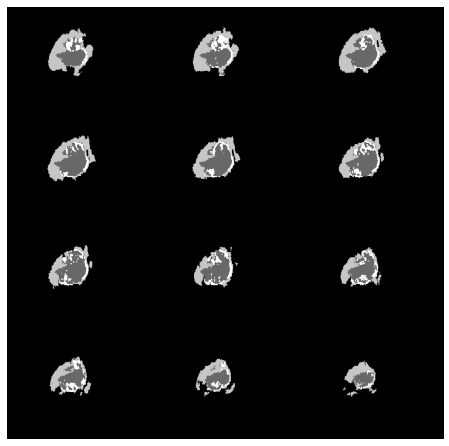

In [365]:
ants.plot(img_orig)

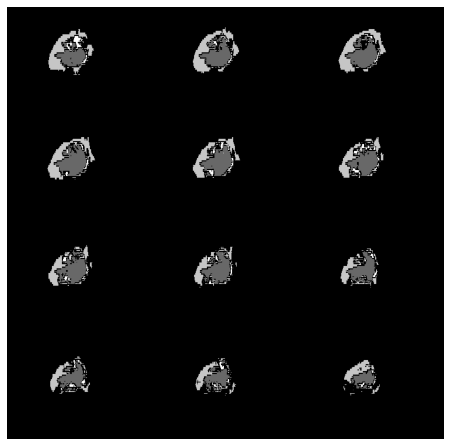

In [367]:
ants.plot(img_1_inv)

### 5. Proofread resample

In [505]:
path = '/anvar/public_datasets/preproc_study/bgpd/orig'
img = ants.image_read(path + '/705_18_4/' + 'T1.nii.gz')

## Check the quality of resampling

In [528]:
path = '/anvar/public_datasets/preproc_study/bgpd/orig'
img = ants.image_read(path + '/705_18_4/' + 'T1.nii.gz')

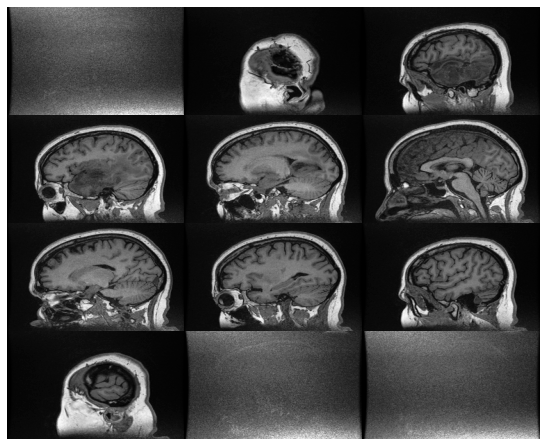

In [529]:
ants.plot(img)

In [530]:
img_res = ants.resample_image(img, (1, 1, 1), False, 0)

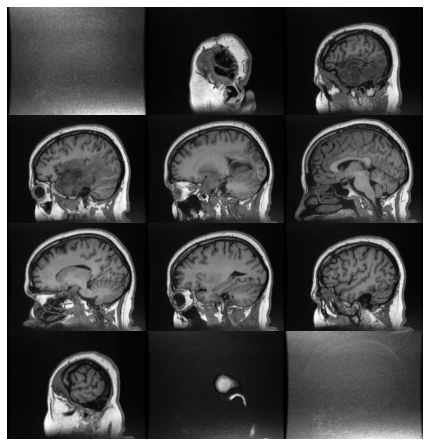

In [531]:
ants.plot(img_res)

In [535]:
path = '/anvar/public_datasets/preproc_study/bgpd/4a_resamp'
img = ants.image_read(path + '/705_18_4/' + 'T1.nii.gz')
seg = ants.image_read(path + '/705_18_4/' + 'mask_GTV_FLAIR.nii.gz')

In [533]:
ants.plot(img)

AssertionError: Image must be non-zero

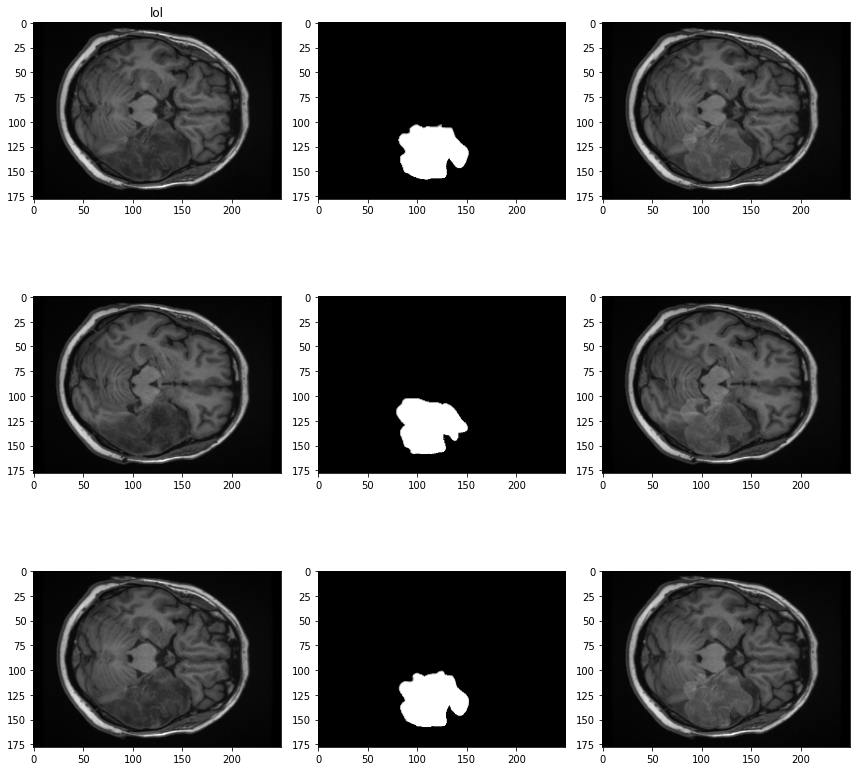

In [536]:
plot_qc(img.numpy(), seg.numpy())

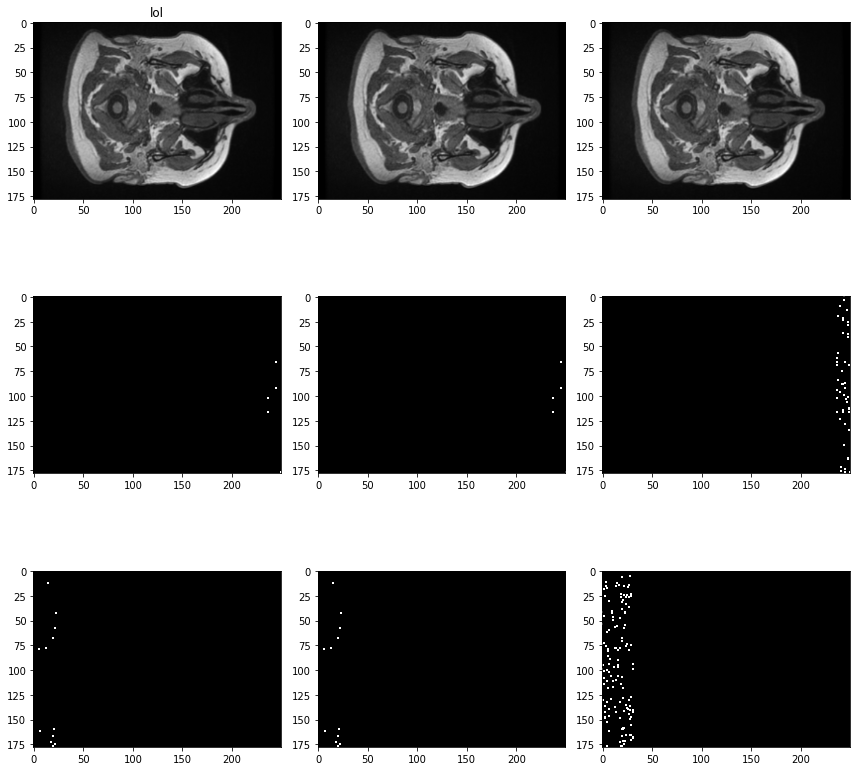

In [538]:
plot_qc(img.numpy(), img.numpy())

In [563]:
np.unique(img.numpy())

array([-3.2467710e+38, -3.1004168e+38, -2.8081274e+38, ...,
        2.5907134e+38,  2.8878855e+38,            nan], dtype=float32)

In [ ]:
## Они выкидываются из обучения и надо вручную их поклипать

In [577]:
np.unique(img.numpy())[1000000]

47.564575

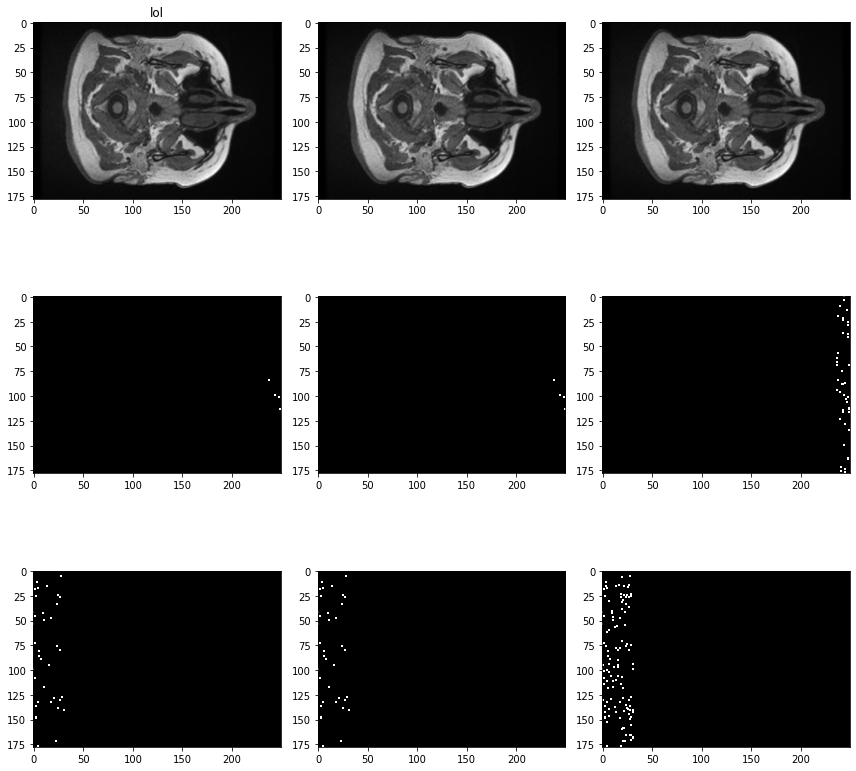

In [564]:
img_inf = img.numpy()
# img_inf[np.isinf(img_inf)] = 0
img_inf[np.isnan(img_inf)] = 0
plot_qc(img_inf, img_inf)

In [565]:
ants.plot(img.new_image_like(img_inf))

AssertionError: Image must be non-zero

In [566]:
np.isnan(img_inf).sum()

0

In [568]:
np.unique(img_inf)

array([-3.2467710e+38, -3.1004168e+38, -2.8081274e+38, ...,
        2.5894098e+38,  2.5907134e+38,  2.8878855e+38], dtype=float32)